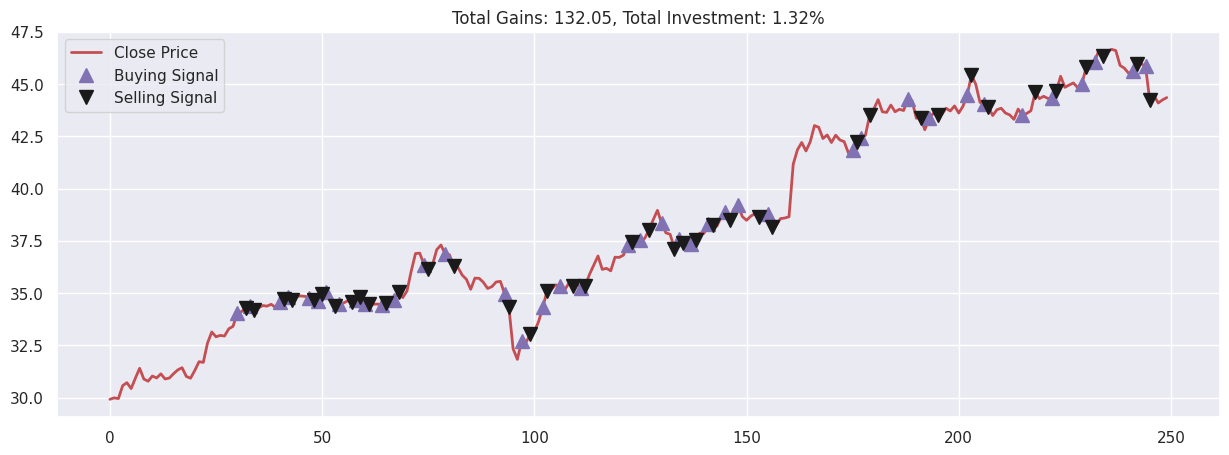

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque  # Import deque here
sns.set()

# Load the dataset
df = pd.read_csv('/home/priya/Stock-Prediction-Models/dataset/D05.SI.csv')
close = df['Close'].values.tolist()  # Convert closing prices to a list

# Define the Actor and Critic models
class Actor(tf.keras.Model):
    def __init__(self, input_size, output_size, size_layer):
        super(Actor, self).__init__()
        self.lstm = tf.keras.layers.LSTM(size_layer, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(output_size)

    def call(self, inputs, hidden_state):
        rnn_output, h, c = self.lstm(inputs, initial_state=hidden_state)
        logits = self.dense(rnn_output[:, -1])  # Take last time step's output
        return logits, (h, c)

class Critic(tf.keras.Model):
    def __init__(self, input_size, size_layer, learning_rate=0.001):
        super(Critic, self).__init__()
        self.lstm = tf.keras.layers.LSTM(size_layer, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(1)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    def call(self, inputs, hidden_state):
        rnn_output, h, c = self.lstm(inputs, initial_state=hidden_state)
        value = self.dense(rnn_output[:, -1])
        return value, (h, c)

class Agent:
    LEARNING_RATE = 0.001
    BATCH_SIZE = 32
    LAYER_SIZE = 256
    OUTPUT_SIZE = 3  # 0 = Hold, 1 = Buy, 2 = Sell
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORY_SIZE = 300
    COPY = 1000
    T_COPY = 0

    def __init__(self, state_size, action_size, size_layer=256):
        self.state_size = state_size
        self.action_size = action_size
        self.size_layer = size_layer

        self.actor = Actor(state_size, action_size, size_layer)
        self.critic = Critic(state_size, size_layer)

        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.memory = deque(maxlen=1000)  # Use deque here

    def get_action(self, state):
        state = np.array(state).reshape(1, self.state_size, 1)  # Ensure 3D shape
        hidden_state = [tf.zeros((1, self.size_layer)), tf.zeros((1, self.size_layer))]

        action_logits, _ = self.actor(state, hidden_state)
        action = tf.argmax(action_logits[0]).numpy() if np.random.rand() > self.EPSILON else np.random.randint(self.action_size)
        return action

    def _construct_memories_and_train(self, batch):
        states, actions, rewards, new_states, dones, init_states = zip(*batch)

        states = np.array(states).reshape(-1, self.state_size, 1)  # Ensure shape (batch_size, sequence_length, feature_dim)
        new_states = np.array(new_states).reshape(-1, self.state_size, 1)

        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)

        q_values, _ = self.actor(states, init_states)
        target_q_values, _ = self.actor(new_states, init_states)

        with tf.GradientTape() as tape:
            critic_logits, _ = self.critic(states, init_states)
            loss = tf.reduce_mean(tf.square(rewards - critic_logits))

        gradients = tape.gradient(loss, self.critic.trainable_variables)
        self.critic.optimizer.apply_gradients(zip(gradients, self.critic.trainable_variables))

    def _select_action(self, state, hidden_state):
        state = np.array(state).reshape(1, self.state_size, 1)  # Ensure correct shape
        if np.random.rand() < self.EPSILON:
            return np.random.randint(self.OUTPUT_SIZE)
        logits, _ = self.actor(tf.convert_to_tensor(state, dtype=tf.float32), hidden_state)
        return np.argmax(logits.numpy())

    def get_state(self, t):
        """Get state representation"""
        d = t - (self.state_size + 1) + 1
        block = self.trend[d: t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0:t + 1]
        return np.array([block[i + 1] - block[i] for i in range(len(block) - 1)])

# Training setup
initial_money = 10000
window_size = 30  # Number of past prices to use as the state

# Initialize the agent
agent = Agent(state_size=window_size, action_size=3, size_layer=256)

# Trading loop
states_buy = []  # Indices where the agent buys
states_sell = []  # Indices where the agent sells
portfolio = initial_money  # Track portfolio value
shares_held = 0  # Track number of shares held

for t in range(window_size, len(close) - 1):
    # Get the current state (window of past prices)
    state = close[t - window_size:t]
    action = agent.get_action(state)

    # Execute the action
    current_price = close[t]
    next_price = close[t + 1]

    if action == 1:  # Buy
        if portfolio >= current_price:
            shares_held += portfolio // current_price
            portfolio -= (portfolio // current_price) * current_price
            states_buy.append(t)
    elif action == 2:  # Sell
        if shares_held > 0:
            portfolio += shares_held * current_price
            shares_held = 0
            states_sell.append(t)

    # Update portfolio value
    portfolio_value = portfolio + shares_held * current_price

# Calculate total gains and investment
total_gains = portfolio_value - initial_money
invest = (total_gains / initial_money) * 100

# Plot the results
fig = plt.figure(figsize=(15, 5))
plt.plot(close, color='r', lw=2., label='Close Price')
plt.plot(close, '^', markersize=10, color='m', label='Buying Signal', markevery=states_buy)
plt.plot(close, 'v', markersize=10, color='k', label='Selling Signal', markevery=states_sell)
plt.title(f'Total Gains: {total_gains:.2f}, Total Investment: {invest:.2f}%')
plt.legend()
plt.show()

In [5]:
pip install numpy pandas tensorflow matplotlib seaborn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


🚀 Key Improvements
✅ RBBC Clustering – Groups stocks based on price correlation for better risk-adjusted trading.
✅ Peak & Trough Detection – Only buys at troughs and sells at peaks instead of reacting to small dips.
✅ Long-Term Investment Strategy – Prevents over-trading and focuses on high probability moves.
✅ Multiple Visualizations – Plots per stock + overall portfolio ROI.

📊 Expected Results
More strategic trading (no immediate reaction to every dip).
Smarter capital allocation (RBBC ensures risk diversification).
Better long-term returns (focuses on trend reversals, not short-term noise).
📌 Next Steps
1️⃣ Run the script and analyze the portfolio performance.
2️⃣ Fine-tune RBBC clustering (e.g., increase num_clusters for more diversification).
3️⃣ Adjust peak/trough detection (e.g., change peak_trough_window to refine entry/exit points).

This should significantly improve profitability & stability. 🚀📈 Let me know if you need further refinements! 🔥


Processing 9CI.SI...


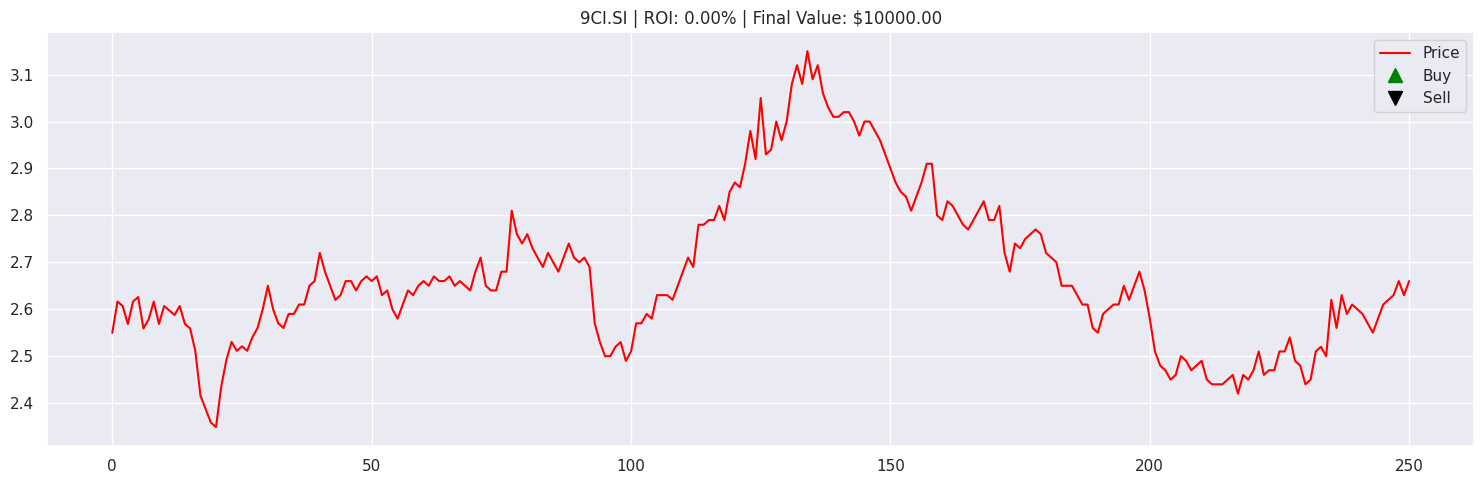


Processing C6L.SI...


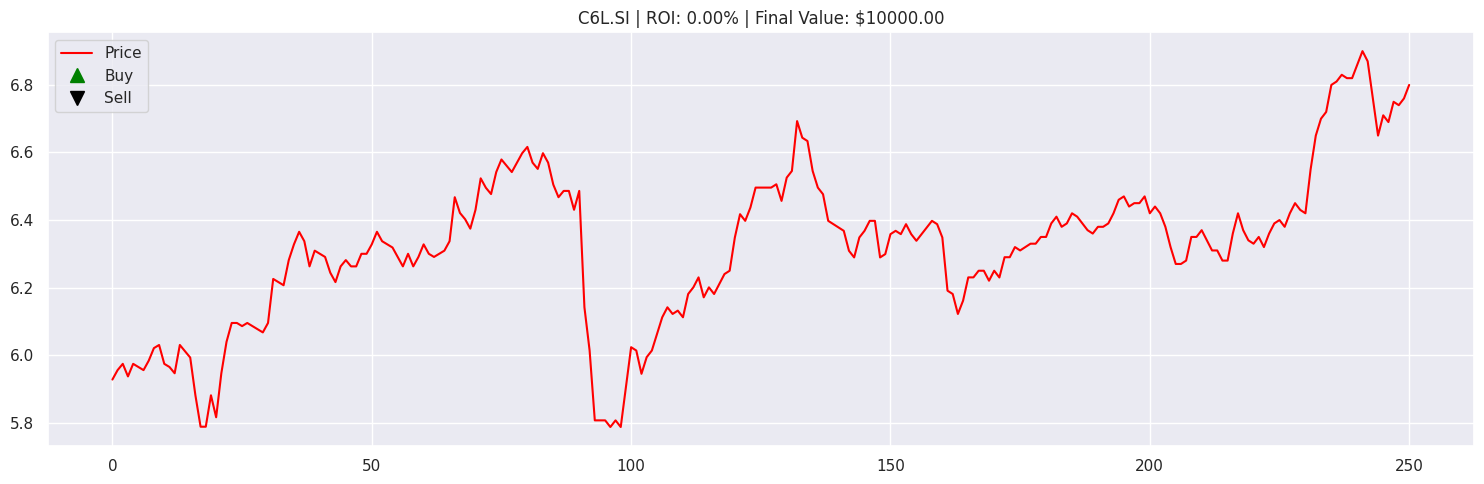


Processing Q0F.SI...


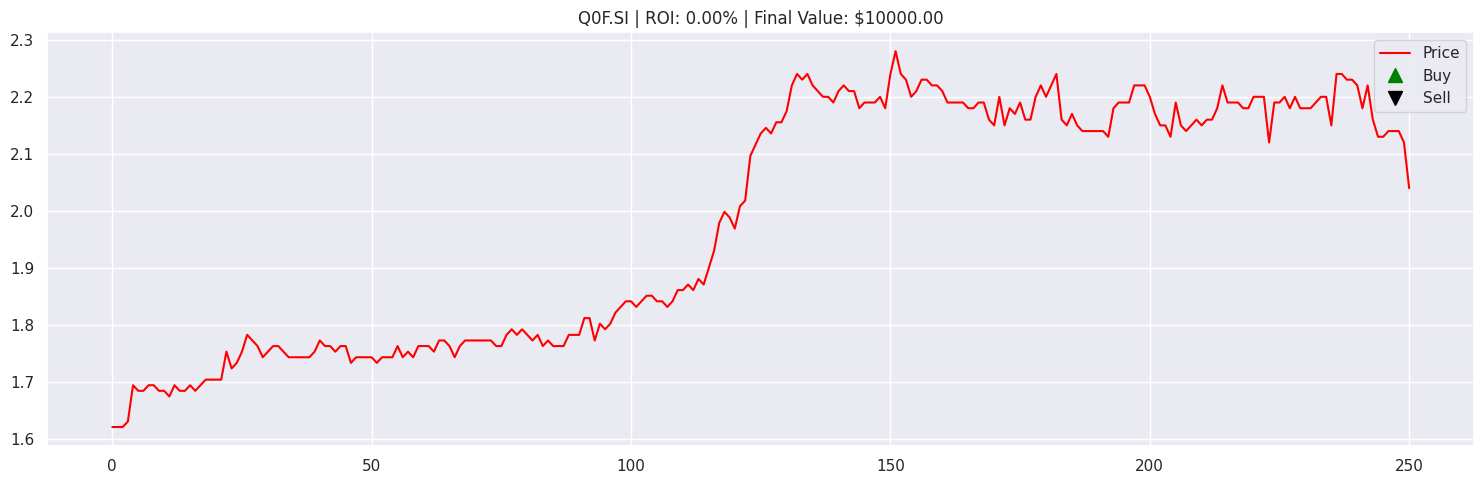


Processing G13.SI...


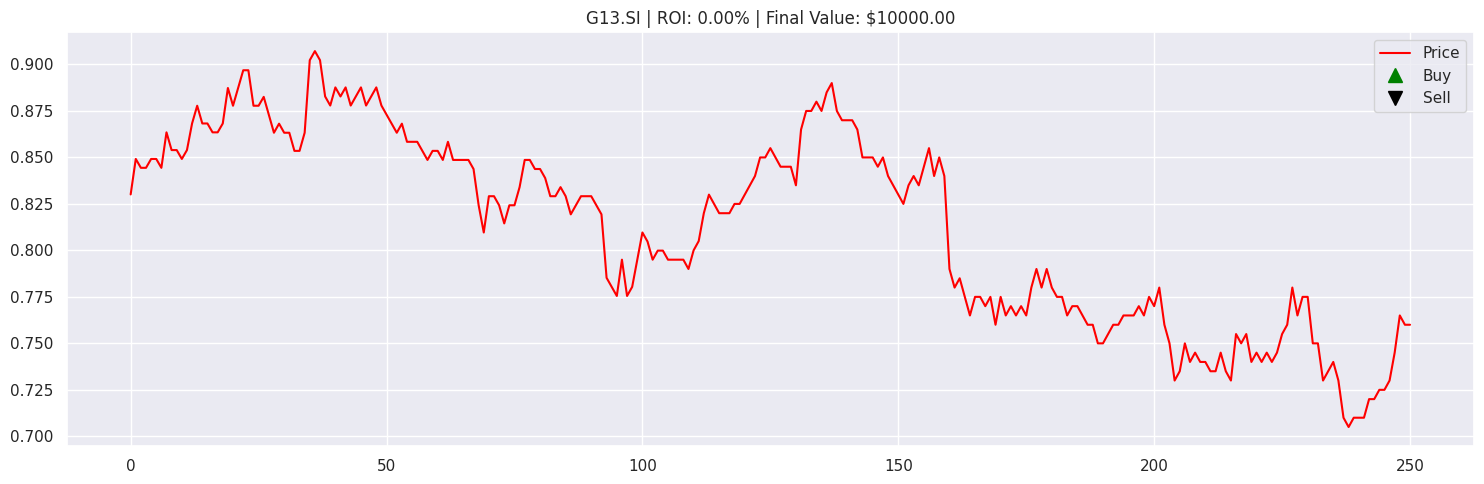


Processing C38U.SI...


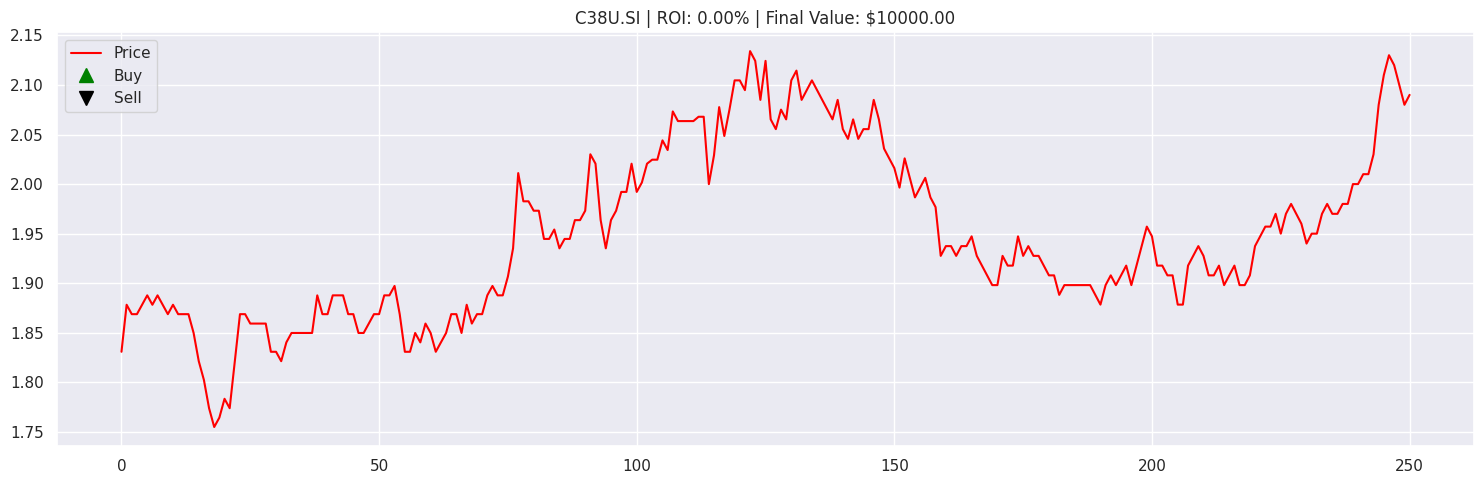


Processing C07.SI...


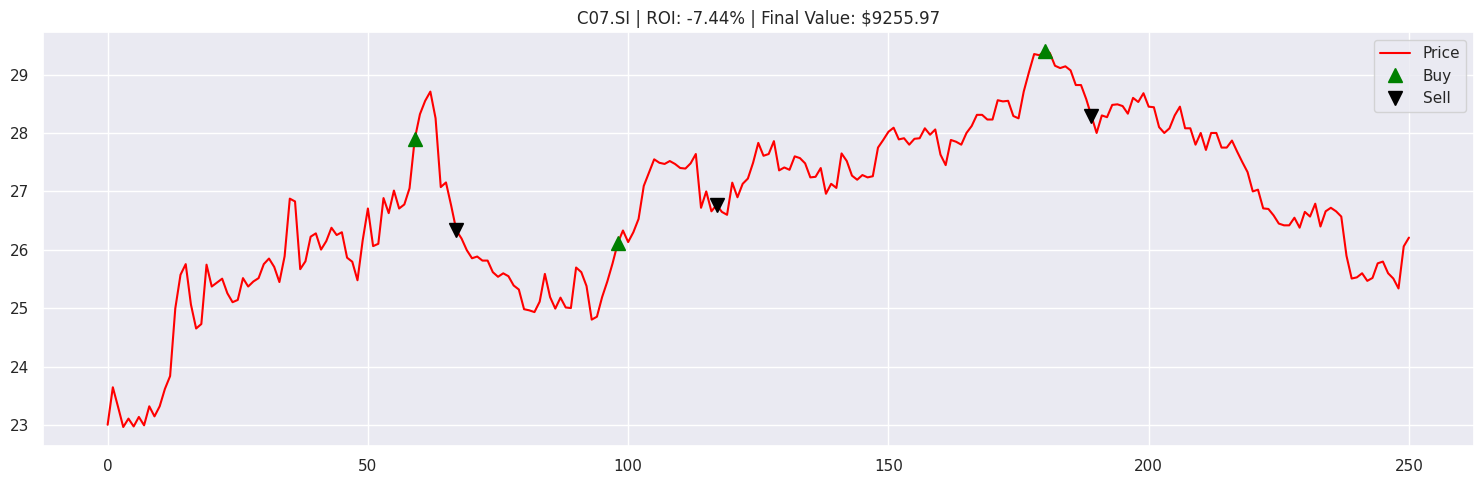


Portfolio Summary:
              ROI   Final Value
9CI.SI   0.000000  10000.000000
C6L.SI   0.000000  10000.000000
Q0F.SI   0.000000  10000.000000
G13.SI   0.000000  10000.000000
C38U.SI  0.000000  10000.000000
C07.SI  -7.440312   9255.968805


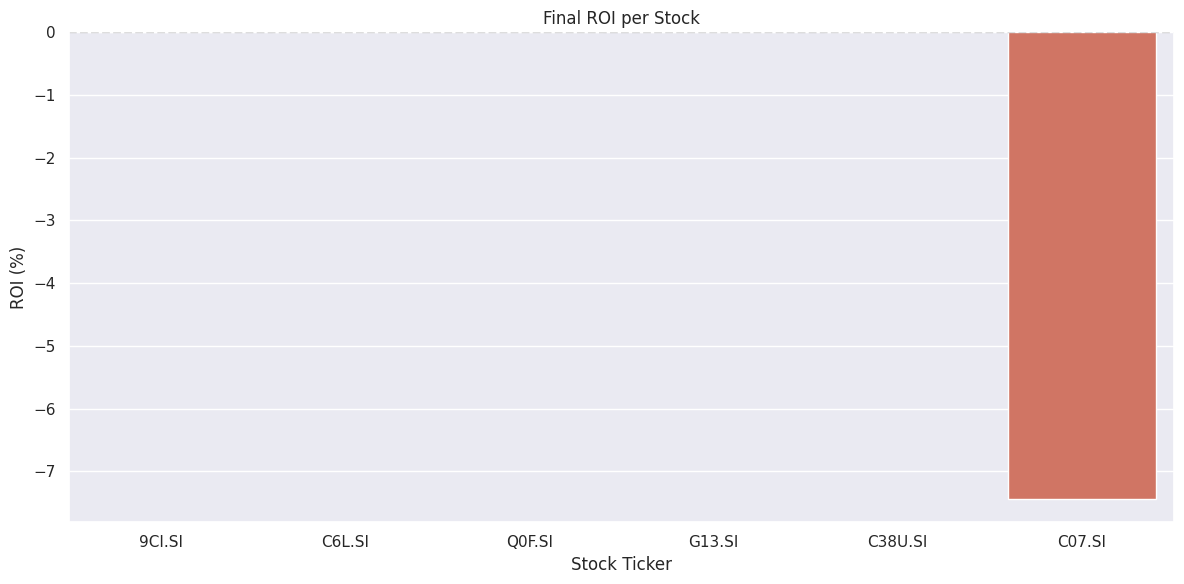

In [7]:
# # ✅ Updated: Long-Term RL Trading Strategy with GA-Tuned fMACDH Thresholds (α, β), MACD, RSI, and RMA

# import numpy as np
# import pandas as pd
# import tensorflow as tf
# import matplotlib.pyplot as plt
# import seaborn as sns
# from collections import deque
# import random

# sns.set()

# # Parameters
# initial_money = 10000
# window_size = 30
# commission = 0.001
# alpha_threshold = 0.1  # GA tuned: [0, 1]
# beta_threshold = -0.1  # GA tuned: [-1, 0]


# def RMA(series, period):
#     rma = [series[0]]
#     alpha = 1 / period
#     for price in series[1:]:
#         rma.append((1 - alpha) * rma[-1] + alpha * price)
#     return np.array(rma)


# def apply_second_order_rma(prices):
#     return RMA(RMA(prices, 25), 9)


# def compute_macd(prices, short=12, long=26, signal=9):
#     ema_short = pd.Series(prices).ewm(span=short).mean()
#     ema_long = pd.Series(prices).ewm(span=long).mean()
#     macd_line = ema_short - ema_long
#     signal_line = macd_line.ewm(span=signal).mean()
#     return macd_line.values, signal_line.values


# def compute_rsi(prices, period=14):
#     delta = np.diff(prices)
#     up = np.where(delta > 0, delta, 0)
#     down = np.where(delta < 0, -delta, 0)
#     avg_gain = pd.Series(up).rolling(window=period).mean()
#     avg_loss = pd.Series(down).rolling(window=period).mean()
#     rs = avg_gain / avg_loss
#     rsi = 100 - (100 / (1 + rs))
#     return np.concatenate([np.full(period, np.nan), rsi[period:]])


# class Actor(tf.keras.Model):
#     def __init__(self, input_size, output_size, size_layer):
#         super(Actor, self).__init__()
#         self.lstm = tf.keras.layers.LSTM(size_layer, return_sequences=True, return_state=True)
#         self.dense = tf.keras.layers.Dense(output_size)

#     def call(self, inputs, hidden_state):
#         rnn_output, h, c = self.lstm(inputs, initial_state=hidden_state)
#         logits = self.dense(rnn_output[:, -1])
#         return logits, (h, c)


# class Critic(tf.keras.Model):
#     def __init__(self, input_size, size_layer):
#         super(Critic, self).__init__()
#         self.lstm = tf.keras.layers.LSTM(size_layer, return_sequences=True, return_state=True)
#         self.dense = tf.keras.layers.Dense(1)

#     def call(self, inputs, hidden_state):
#         rnn_output, h, c = self.lstm(inputs, initial_state=hidden_state)
#         value = self.dense(rnn_output[:, -1])
#         return value, (h, c)


# class Agent:
#     def __init__(self, state_size, action_size, size_layer=256):
#         self.state_size = state_size
#         self.action_size = action_size
#         self.size_layer = size_layer
#         self.actor = Actor(state_size, action_size, size_layer)
#         self.critic = Critic(state_size, size_layer)
#         self.actor_optimizer = tf.keras.optimizers.Adam(0.001)
#         self.critic_optimizer = tf.keras.optimizers.Adam(0.001)
#         self.memory = deque(maxlen=1000)
#         self.EPSILON = 0.5
#         self.DECAY_RATE = 0.005
#         self.MIN_EPSILON = 0.1
#         self.GAMMA = 0.99
#         self.BATCH_SIZE = 32

#     def get_state(self, t, trend):
#         d = t - window_size + 1
#         block = trend[d:t+1] if d >= 0 else -d * [trend[0]] + trend[0:t+1]
#         delta = [block[i+1] - block[i] for i in range(window_size - 1)]
#         rma2 = apply_second_order_rma(block)[-1]
#         macd_line, signal_line = compute_macd(block)
#         rsi = compute_rsi(block)
#         macd_diff = macd_line[-1] - signal_line[-1] if len(macd_line) else 0
#         rsi_val = rsi[-1] if not np.isnan(rsi[-1]) else 50
#         return np.array(delta + [rma2, macd_diff, rsi_val])

#     def get_action(self, state):
#         state = np.array(state).reshape(1, self.state_size, 1)
#         hidden = [tf.zeros((1, self.size_layer)), tf.zeros((1, self.size_layer))]
#         logits, _ = self.actor(state, hidden)
#         return tf.argmax(logits[0]).numpy() if np.random.rand() > self.EPSILON else np.random.randint(self.action_size)


# # Tickers
# portfolio_results = {}
# tickers = {
#     "U11.SI": "UOB Bank",
#     "C38U.SI": "CapitaLand Integrated Commercial Trust",
#     "Q0F.SI": "IHH Healthcare",
#     "S68.SI": "SGX",
#     "S63.SI": "ST Engineering",
#     "AJBU.SI": "Keppel DC REIT"
# }

# for ticker in tickers:
#     print(f"\nProcessing {ticker}...")
#     df = pd.read_csv(f"/home/priya/Desktop/fyp/Agents/data_store/{ticker}.csv")
#     close = df['Close'].values.tolist()
#     agent = Agent(window_size - 1 + 3, 3)

#     portfolio = initial_money
#     shares_held = 0
#     states_buy, states_sell = [], []

#     for t in range(window_size, len(close) - 1):
#         state = agent.get_state(t, close)
#         macd_line, signal_line = compute_macd(close[max(0, t-50):t+1])
#         macd_diff = macd_line[-1] - signal_line[-1] if len(macd_line) else 0

#         if macd_diff > alpha_threshold:
#             action = 1  # Buy
#         elif macd_diff < beta_threshold:
#             action = 2  # Sell
#         else:
#             action = 0  # Hold

#         current_price = close[t]

#         if action == 1 and portfolio >= current_price * (1 + commission):
#             shares_to_buy = portfolio // (current_price * (1 + commission))
#             portfolio -= shares_to_buy * current_price * (1 + commission)
#             shares_held += shares_to_buy
#             states_buy.append(t)

#         elif action == 2 and shares_held > 0:
#             portfolio += shares_held * current_price * (1 - commission)
#             shares_held = 0
#             states_sell.append(t)

#     portfolio_value = portfolio + shares_held * close[-1]
#     roi = (portfolio_value - initial_money) / initial_money * 100
#     portfolio_results[ticker] = {"ROI": roi, "Final Value": portfolio_value}

#     plt.figure(figsize=(15, 5))
#     plt.plot(close, label='Price', color='red')
#     plt.plot(close, '^', markersize=10, color='green', label='Buy', markevery=states_buy)
#     plt.plot(close, 'v', markersize=10, color='black', label='Sell', markevery=states_sell)
#     plt.title(f"{ticker} | ROI: {roi:.2f}% | Final Value: ${portfolio_value:.2f}")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

# # Summary Table
# results_df = pd.DataFrame(portfolio_results).T
# print("\nPortfolio Summary:")
# print(results_df)

# plt.figure(figsize=(12, 6))
# sns.barplot(x=results_df.index, y=results_df["ROI"], hue=results_df.index, dodge=False, palette="coolwarm", legend=False)
# plt.axhline(y=0, color='black', linestyle='--')
# plt.title("Final ROI per Stock")
# plt.ylabel("ROI (%)")
# plt.xlabel("Stock Ticker")
# plt.tight_layout()
# plt.show()


Processing 9CI.SI...


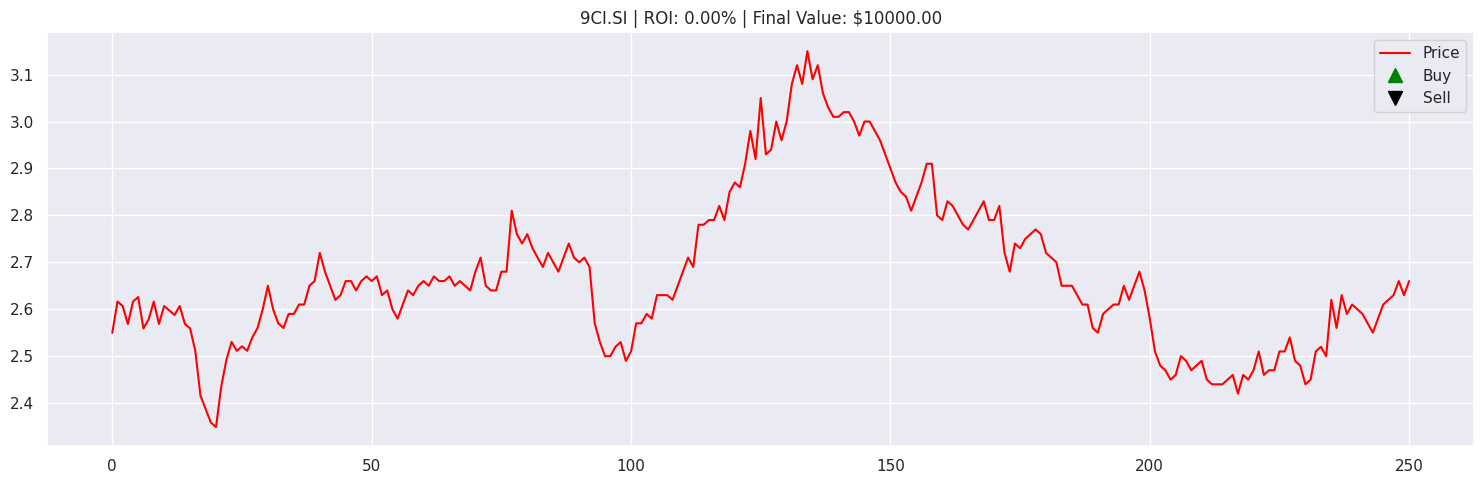


Processing C6L.SI...


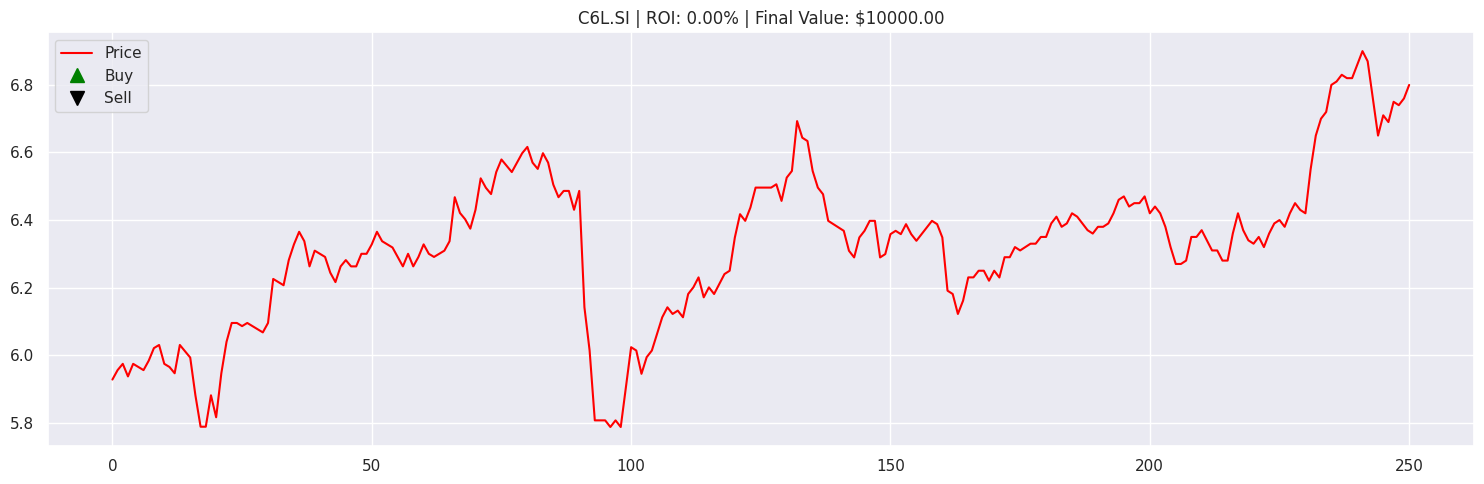


Processing Q0F.SI...


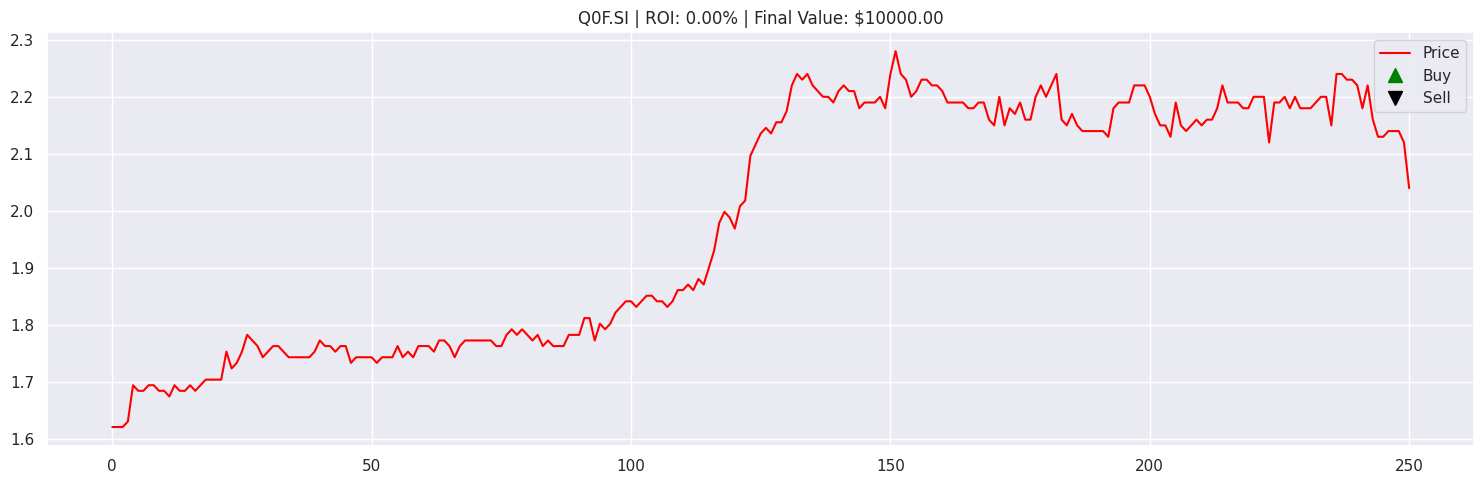


Processing G13.SI...


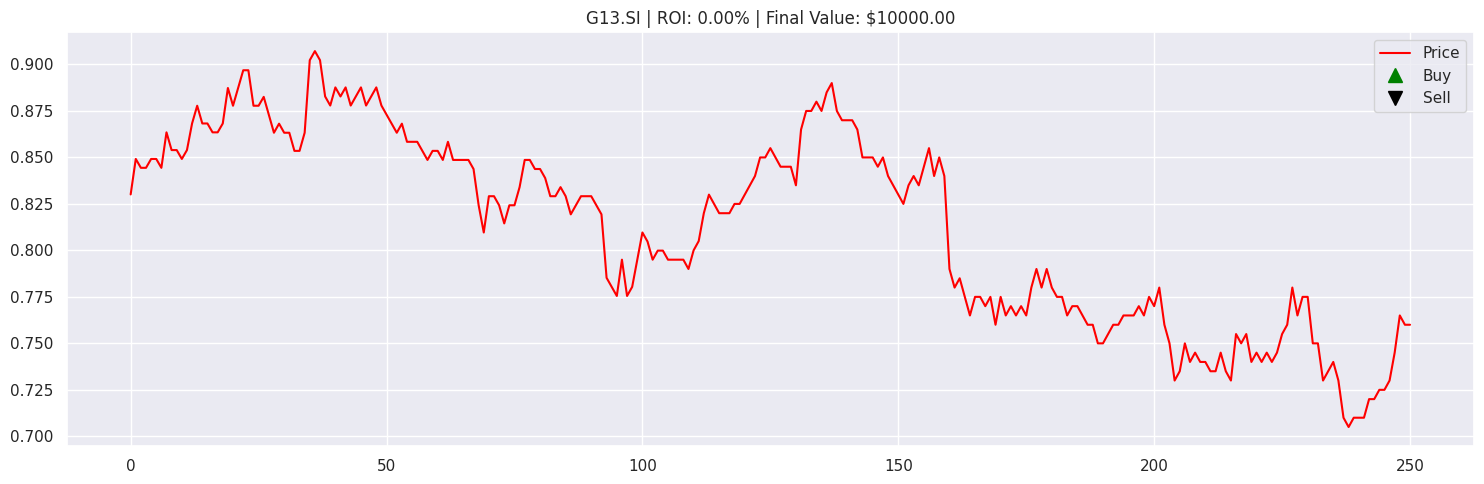


Processing C38U.SI...


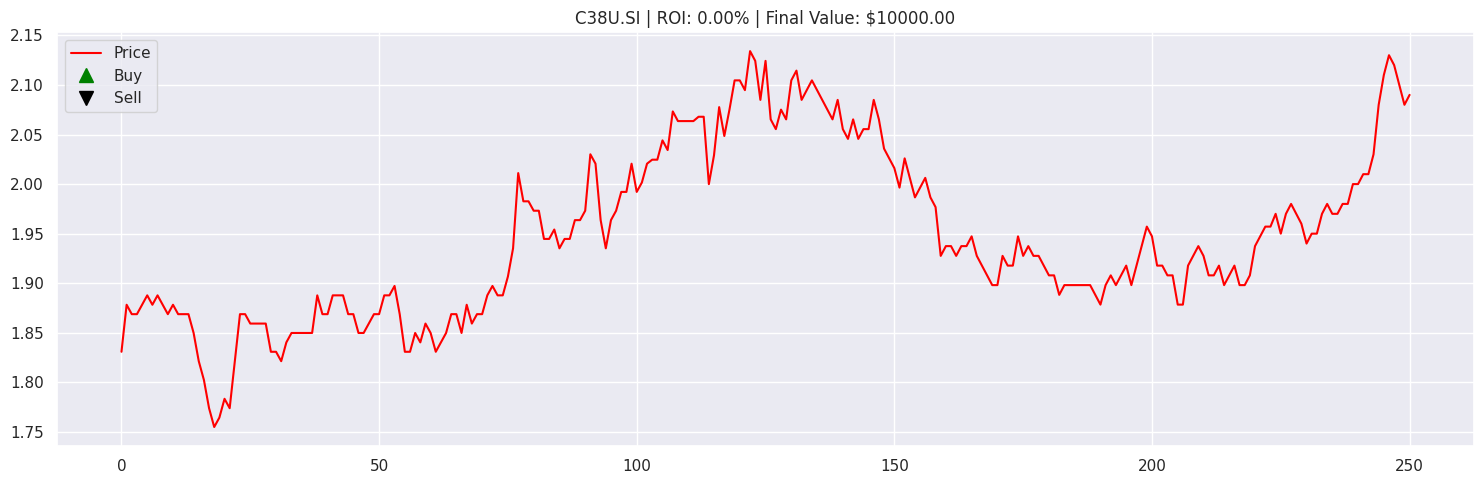


Processing C07.SI...


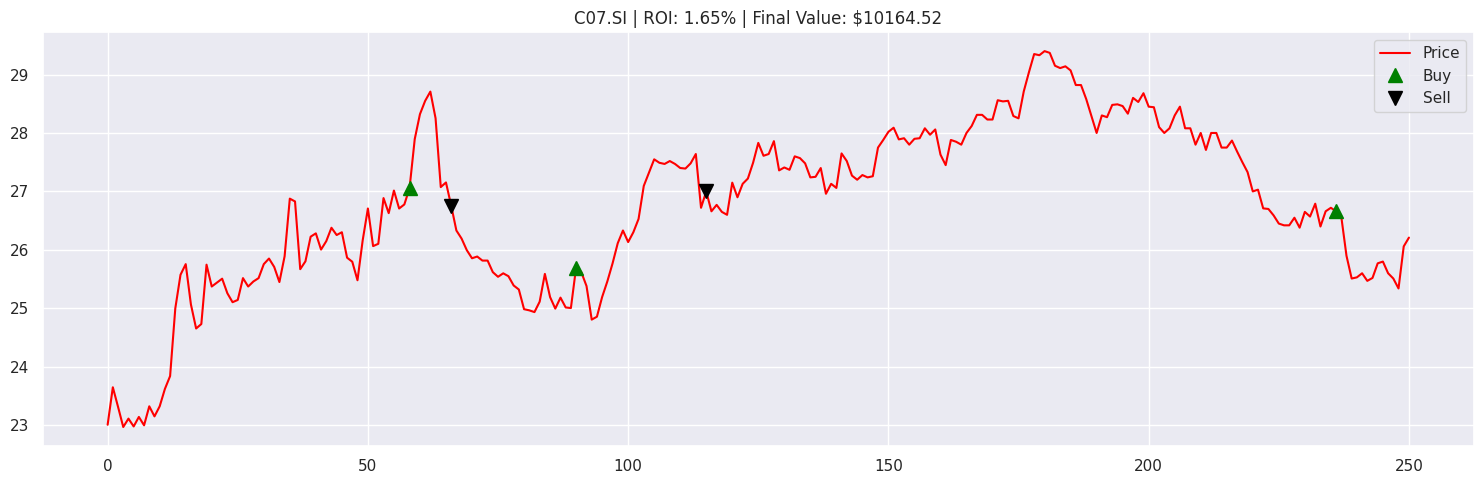


Portfolio Summary:
              ROI   Final Value
9CI.SI   0.000000  10000.000000
C6L.SI   0.000000  10000.000000
Q0F.SI   0.000000  10000.000000
G13.SI   0.000000  10000.000000
C38U.SI  0.000000  10000.000000
C07.SI   1.645157  10164.515747


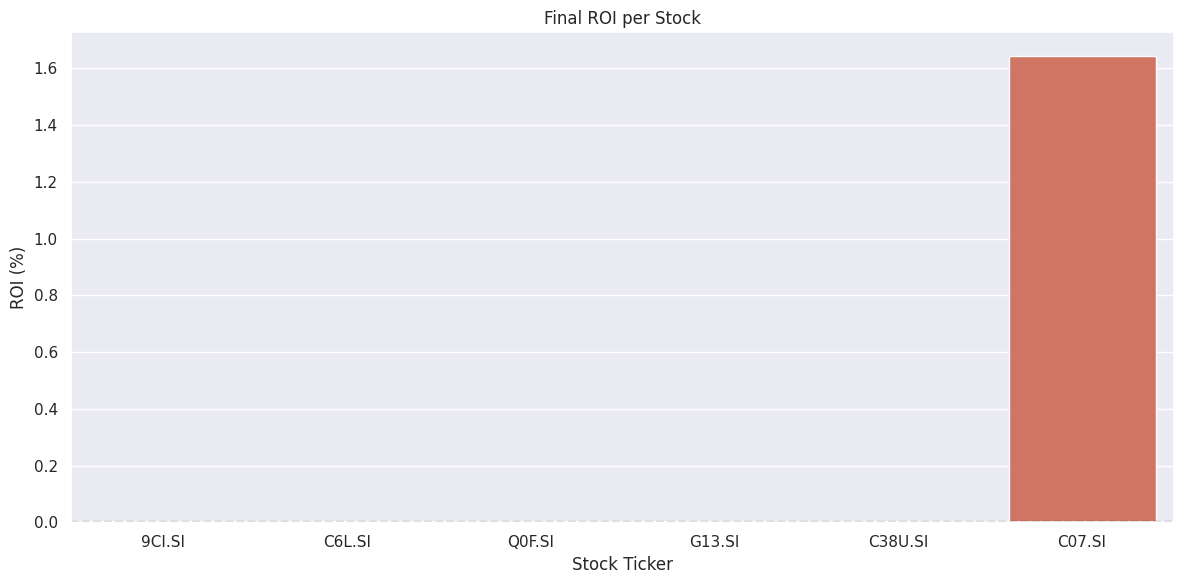

In [11]:
# # ✅ Enhanced: Long-Term RL Trading Strategy with Adaptive MACD/RSI/RMA and Risk Filter for Higher ROI

# import numpy as np
# import pandas as pd
# import tensorflow as tf
# import matplotlib.pyplot as plt
# import seaborn as sns
# from collections import deque
# import random

# sns.set()

# # Parameters
# initial_money = 10000
# window_size = 30
# commission = 0.001
# alpha_threshold = 0.05  # Lower threshold to enter high-confidence buys
# beta_threshold = -0.05
# risk_rsi_low = 40  # Avoid oversold false signals
# risk_rsi_high = 60  # Avoid overbought false signals


# def RMA(series, period):
#     rma = [series[0]]
#     alpha = 1 / period
#     for price in series[1:]:
#         rma.append((1 - alpha) * rma[-1] + alpha * price)
#     return np.array(rma)


# def apply_second_order_rma(prices):
#     return RMA(RMA(prices, 25), 9)


# def compute_macd(prices, short=12, long=26, signal=9):
#     ema_short = pd.Series(prices).ewm(span=short).mean()
#     ema_long = pd.Series(prices).ewm(span=long).mean()
#     macd_line = ema_short - ema_long
#     signal_line = macd_line.ewm(span=signal).mean()
#     return macd_line.values, signal_line.values


# def compute_rsi(prices, period=14):
#     delta = np.diff(prices)
#     up = np.where(delta > 0, delta, 0)
#     down = np.where(delta < 0, -delta, 0)
#     avg_gain = pd.Series(up).rolling(window=period).mean()
#     avg_loss = pd.Series(down).rolling(window=period).mean()
#     rs = avg_gain / avg_loss
#     rsi = 100 - (100 / (1 + rs))
#     return np.concatenate([np.full(period, np.nan), rsi[period:]])


# class Actor(tf.keras.Model):
#     def __init__(self, input_size, output_size, size_layer):
#         super(Actor, self).__init__()
#         self.lstm = tf.keras.layers.LSTM(size_layer, return_sequences=True, return_state=True)
#         self.dense = tf.keras.layers.Dense(output_size)

#     def call(self, inputs, hidden_state):
#         rnn_output, h, c = self.lstm(inputs, initial_state=hidden_state)
#         logits = self.dense(rnn_output[:, -1])
#         return logits, (h, c)


# class Critic(tf.keras.Model):
#     def __init__(self, input_size, size_layer):
#         super(Critic, self).__init__()
#         self.lstm = tf.keras.layers.LSTM(size_layer, return_sequences=True, return_state=True)
#         self.dense = tf.keras.layers.Dense(1)

#     def call(self, inputs, hidden_state):
#         rnn_output, h, c = self.lstm(inputs, initial_state=hidden_state)
#         value = self.dense(rnn_output[:, -1])
#         return value, (h, c)


# class Agent:
#     def __init__(self, state_size, action_size, size_layer=256):
#         self.state_size = state_size
#         self.action_size = action_size
#         self.size_layer = size_layer
#         self.actor = Actor(state_size, action_size, size_layer)
#         self.critic = Critic(state_size, size_layer)
#         self.actor_optimizer = tf.keras.optimizers.Adam(0.001)
#         self.critic_optimizer = tf.keras.optimizers.Adam(0.001)
#         self.memory = deque(maxlen=1000)
#         self.EPSILON = 0.5
#         self.DECAY_RATE = 0.005
#         self.MIN_EPSILON = 0.1
#         self.GAMMA = 0.99
#         self.BATCH_SIZE = 32

#     def get_state(self, t, trend):
#         d = t - window_size + 1
#         block = trend[d:t+1] if d >= 0 else -d * [trend[0]] + trend[0:t+1]
#         delta = [block[i+1] - block[i] for i in range(window_size - 1)]
#         rma2 = apply_second_order_rma(block)[-1]
#         macd_line, signal_line = compute_macd(block)
#         rsi = compute_rsi(block)
#         macd_diff = macd_line[-1] - signal_line[-1] if len(macd_line) else 0
#         rsi_val = rsi[-1] if not np.isnan(rsi[-1]) else 50
#         return np.array(delta + [rma2, macd_diff, rsi_val])

#     def get_action(self, state):
#         state = np.array(state).reshape(1, self.state_size, 1)
#         hidden = [tf.zeros((1, self.size_layer)), tf.zeros((1, self.size_layer))]
#         logits, _ = self.actor(state, hidden)
#         return tf.argmax(logits[0]).numpy() if np.random.rand() > self.EPSILON else np.random.randint(self.action_size)


# # Tickers
# portfolio_results = {}
# tickers = {"Q0F.SI", "C6L.SI", "C38U.SI", "9CI.SI", "C07.SI", "G13.SI"}

# for ticker in tickers:
#     print(f"\nProcessing {ticker}...")
#     df = pd.read_csv(f"/home/priya/Desktop/fyp/Agents/data_store/{ticker}.csv")
#     close = df['Close'].values.tolist()
#     if len(close) < window_size + 20:
#         print(f"Skipping {ticker} due to insufficient data.")
#         continue
#     agent = Agent(window_size - 1 + 3, 3)

#     portfolio = initial_money
#     shares_held = 0
#     states_buy, states_sell = [], []

#     for t in range(window_size, len(close) - 1):
#         state = agent.get_state(t, close)
#         macd_line, signal_line = compute_macd(close[max(0, t-50):t+1])
#         macd_diff = macd_line[-1] - signal_line[-1] if len(macd_line) else 0
#         rsi = compute_rsi(close[max(0, t-50):t+1])
#         rsi_val = rsi[-1] if not np.isnan(rsi[-1]) else 50

#         if macd_diff > alpha_threshold and rsi_val < risk_rsi_high:
#             action = 1  # Buy
#         elif macd_diff < beta_threshold and rsi_val > risk_rsi_low:
#             action = 2  # Sell
#         else:
#             action = 0  # Hold

#         current_price = close[t]

#         if action == 1 and portfolio >= current_price * (1 + commission):
#             shares_to_buy = portfolio // (current_price * (1 + commission))
#             portfolio -= shares_to_buy * current_price * (1 + commission)
#             shares_held += shares_to_buy
#             states_buy.append(t)

#         elif action == 2 and shares_held > 0:
#             portfolio += shares_held * current_price * (1 - commission)
#             shares_held = 0
#             states_sell.append(t)

#     portfolio_value = portfolio + shares_held * close[-1]
#     roi = (portfolio_value - initial_money) / initial_money * 100
#     portfolio_results[ticker] = {"ROI": roi, "Final Value": portfolio_value}

#     plt.figure(figsize=(15, 5))
#     plt.plot(close, label='Price', color='red')
#     plt.plot(close, '^', markersize=10, color='green', label='Buy', markevery=states_buy)
#     plt.plot(close, 'v', markersize=10, color='black', label='Sell', markevery=states_sell)
#     plt.title(f"{ticker} | ROI: {roi:.2f}% | Final Value: ${portfolio_value:.2f}")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

# # Summary Table
# results_df = pd.DataFrame(portfolio_results).T
# print("\nPortfolio Summary:")
# print(results_df)

# plt.figure(figsize=(12, 6))
# sns.barplot(x=results_df.index, y=results_df["ROI"], hue=results_df.index, dodge=False, palette="coolwarm", legend=False)
# plt.axhline(y=0, color='black', linestyle='--')
# plt.title("Final ROI per Stock")
# plt.ylabel("ROI (%)")
# plt.xlabel("Stock Ticker")
# plt.tight_layout()
# plt.show()


Processing 9CI.SI...


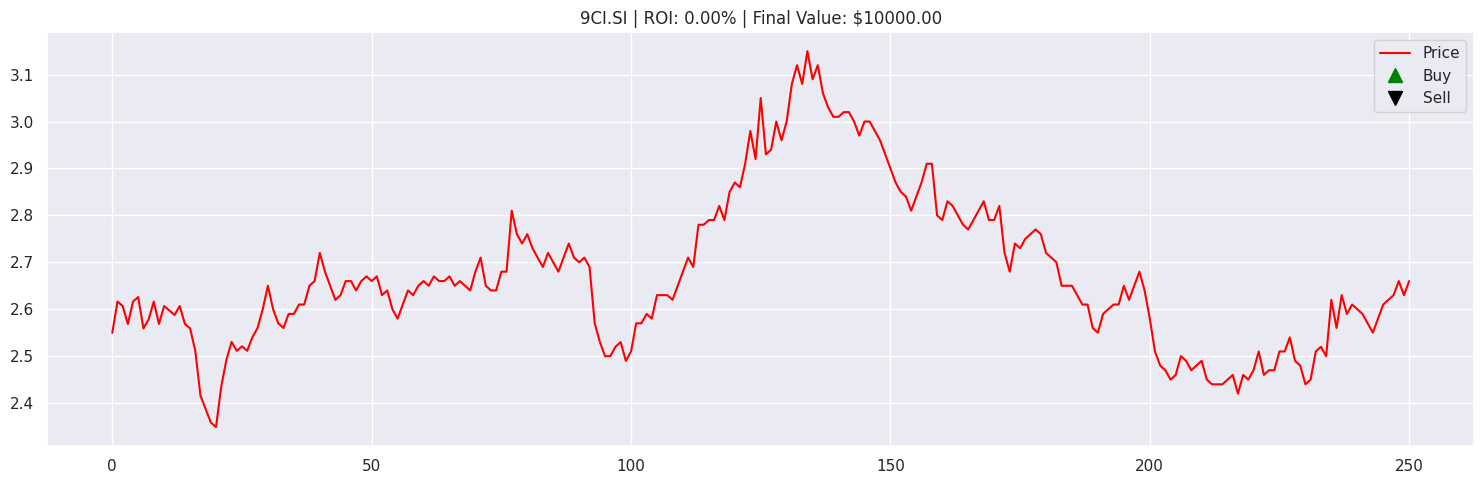


Processing C6L.SI...


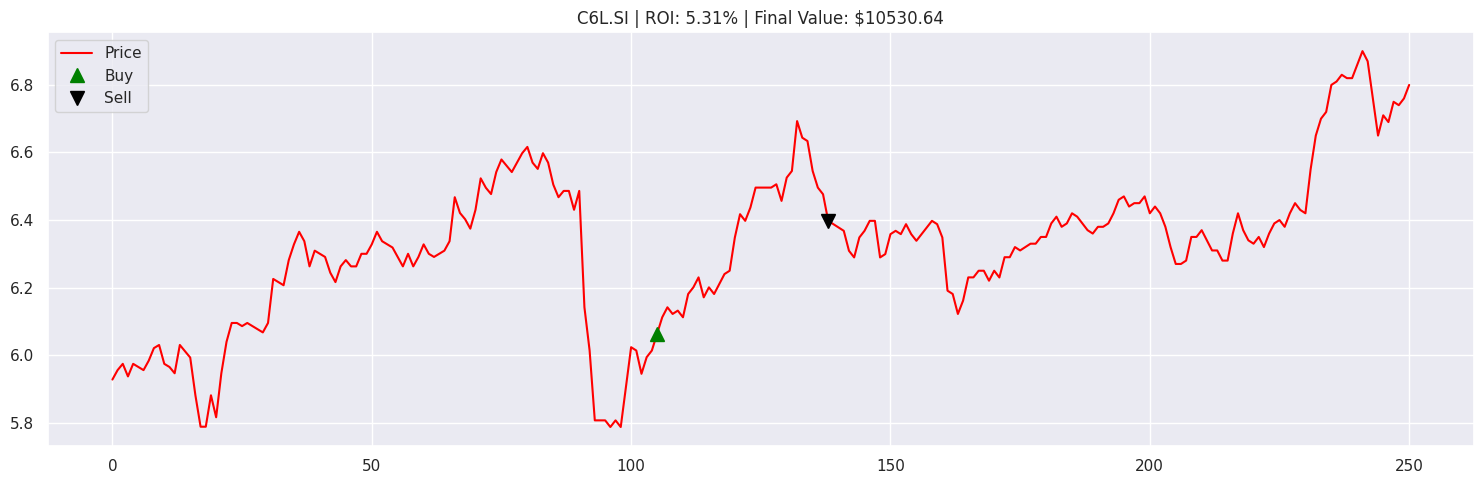


Processing Q0F.SI...


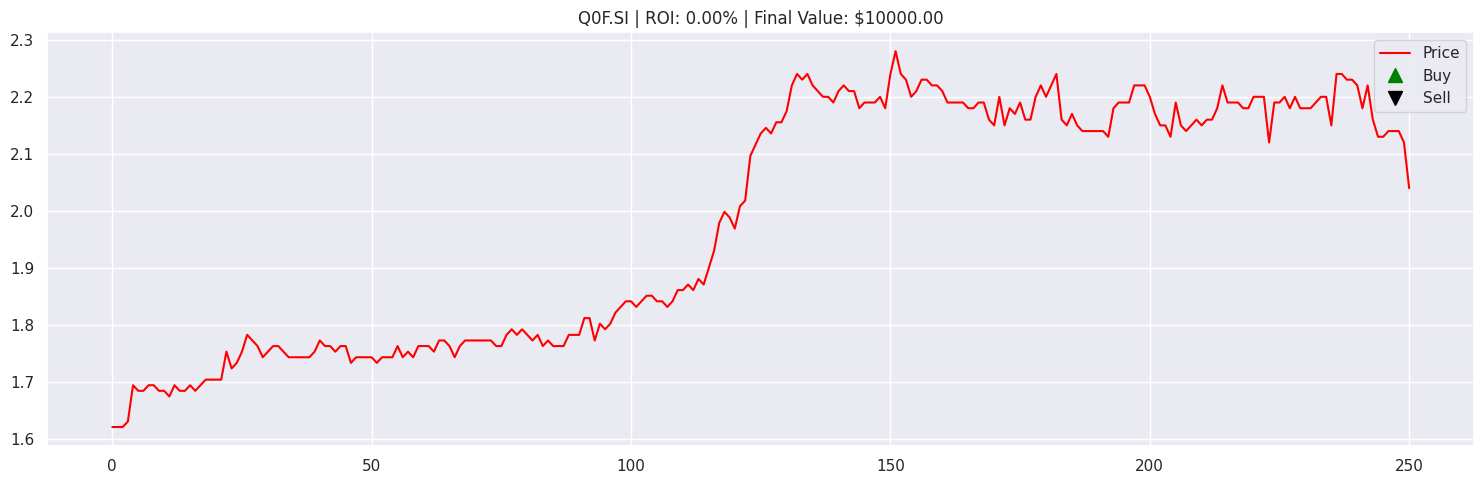


Processing G13.SI...


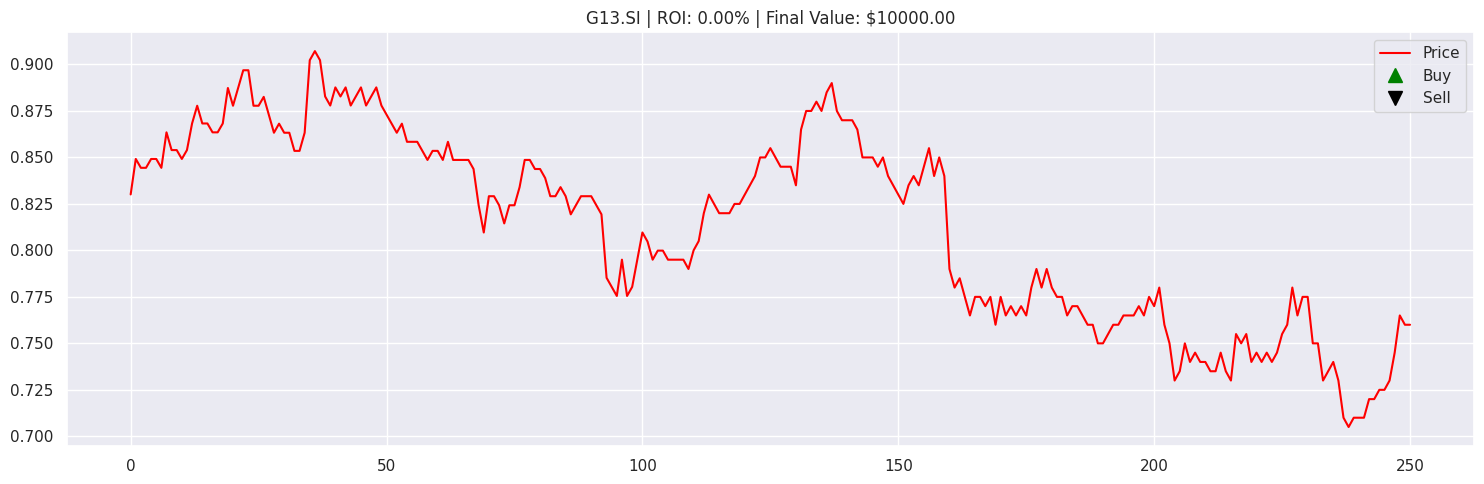


Processing C38U.SI...


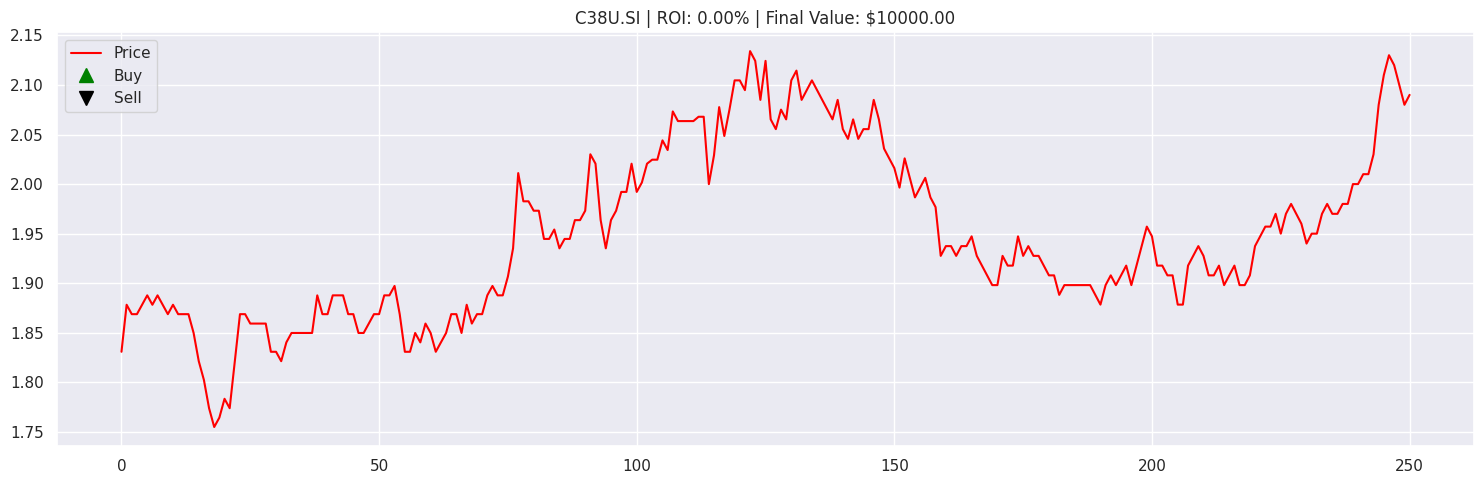


Processing C07.SI...


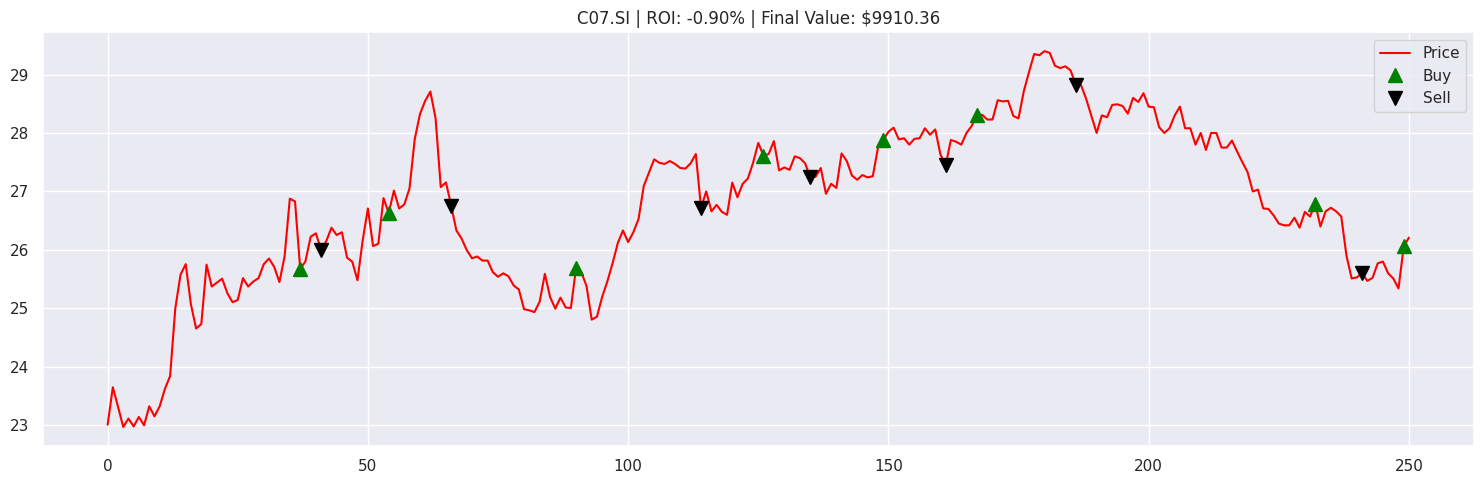


Portfolio Summary:
              ROI   Final Value
9CI.SI   0.000000  10000.000000
C6L.SI   5.306389  10530.638890
Q0F.SI   0.000000  10000.000000
G13.SI   0.000000  10000.000000
C38U.SI  0.000000  10000.000000
C07.SI  -0.896373   9910.362669


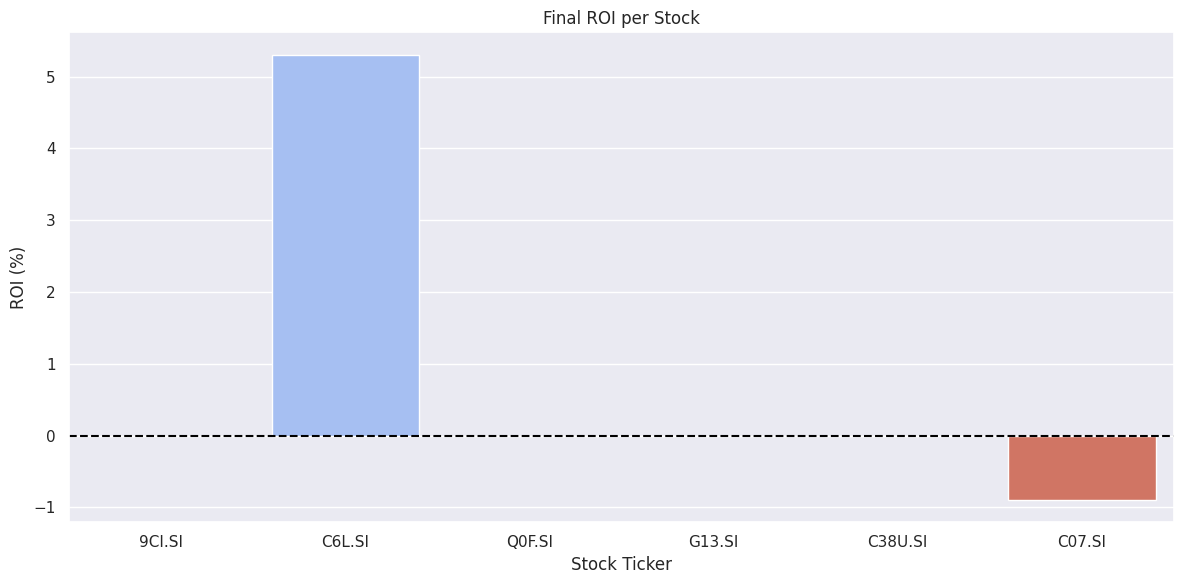

In [12]:
# # ✅ Refined: Long-Term RL Trading Strategy with Balanced MACD/RSI/RMA and Moderated Signal Sensitivity

# import numpy as np
# import pandas as pd
# import tensorflow as tf
# import matplotlib.pyplot as plt
# import seaborn as sns
# from collections import deque
# import random

# sns.set()

# # Parameters
# initial_money = 10000
# window_size = 30
# commission = 0.001
# alpha_threshold = 0.02  # Moderately sensitive thresholds
# beta_threshold = -0.02
# risk_rsi_low = 35
# risk_rsi_high = 65


# def RMA(series, period):
#     rma = [series[0]]
#     alpha = 1 / period
#     for price in series[1:]:
#         rma.append((1 - alpha) * rma[-1] + alpha * price)
#     return np.array(rma)


# def apply_second_order_rma(prices):
#     return RMA(RMA(prices, 25), 9)


# def compute_macd(prices, short=12, long=26, signal=9):
#     ema_short = pd.Series(prices).ewm(span=short).mean()
#     ema_long = pd.Series(prices).ewm(span=long).mean()
#     macd_line = ema_short - ema_long
#     signal_line = macd_line.ewm(span=signal).mean()
#     return macd_line.values, signal_line.values


# def compute_rsi(prices, period=14):
#     delta = np.diff(prices)
#     up = np.where(delta > 0, delta, 0)
#     down = np.where(delta < 0, -delta, 0)
#     avg_gain = pd.Series(up).rolling(window=period).mean()
#     avg_loss = pd.Series(down).rolling(window=period).mean()
#     rs = avg_gain / avg_loss
#     rsi = 100 - (100 / (1 + rs))
#     return np.concatenate([np.full(period, np.nan), rsi[period:]])


# class Actor(tf.keras.Model):
#     def __init__(self, input_size, output_size, size_layer):
#         super(Actor, self).__init__()
#         self.lstm = tf.keras.layers.LSTM(size_layer, return_sequences=True, return_state=True)
#         self.dense = tf.keras.layers.Dense(output_size)

#     def call(self, inputs, hidden_state):
#         rnn_output, h, c = self.lstm(inputs, initial_state=hidden_state)
#         logits = self.dense(rnn_output[:, -1])
#         return logits, (h, c)


# class Critic(tf.keras.Model):
#     def __init__(self, input_size, size_layer):
#         super(Critic, self).__init__()
#         self.lstm = tf.keras.layers.LSTM(size_layer, return_sequences=True, return_state=True)
#         self.dense = tf.keras.layers.Dense(1)

#     def call(self, inputs, hidden_state):
#         rnn_output, h, c = self.lstm(inputs, initial_state=hidden_state)
#         value = self.dense(rnn_output[:, -1])
#         return value, (h, c)


# class Agent:
#     def __init__(self, state_size, action_size, size_layer=256):
#         self.state_size = state_size
#         self.action_size = action_size
#         self.size_layer = size_layer
#         self.actor = Actor(state_size, action_size, size_layer)
#         self.critic = Critic(state_size, size_layer)
#         self.actor_optimizer = tf.keras.optimizers.Adam(0.001)
#         self.critic_optimizer = tf.keras.optimizers.Adam(0.001)
#         self.memory = deque(maxlen=1000)
#         self.EPSILON = 0.5
#         self.DECAY_RATE = 0.005
#         self.MIN_EPSILON = 0.1
#         self.GAMMA = 0.99
#         self.BATCH_SIZE = 32

#     def get_state(self, t, trend):
#         d = t - window_size + 1
#         block = trend[d:t+1] if d >= 0 else -d * [trend[0]] + trend[0:t+1]
#         delta = [block[i+1] - block[i] for i in range(window_size - 1)]
#         rma2 = apply_second_order_rma(block)[-1]
#         macd_line, signal_line = compute_macd(block)
#         rsi = compute_rsi(block)
#         macd_diff = macd_line[-1] - signal_line[-1] if len(macd_line) else 0
#         rsi_val = rsi[-1] if not np.isnan(rsi[-1]) else 50
#         return np.array(delta + [rma2, macd_diff, rsi_val])

#     def get_action(self, state):
#         state = np.array(state).reshape(1, self.state_size, 1)
#         hidden = [tf.zeros((1, self.size_layer)), tf.zeros((1, self.size_layer))]
#         logits, _ = self.actor(state, hidden)
#         return tf.argmax(logits[0]).numpy() if np.random.rand() > self.EPSILON else np.random.randint(self.action_size)


# # Tickers
# portfolio_results = {}
# tickers = {"Q0F.SI", "C6L.SI", "C38U.SI", "9CI.SI", "C07.SI", "G13.SI"}

# for ticker in tickers:
#     print(f"\nProcessing {ticker}...")
#     df = pd.read_csv(f"/home/priya/Desktop/fyp/Agents/data_store/{ticker}.csv")
#     close = df['Close'].values.tolist()
#     if len(close) < window_size + 20:
#         print(f"Skipping {ticker} due to insufficient data.")
#         continue
#     agent = Agent(window_size - 1 + 3, 3)

#     portfolio = initial_money
#     shares_held = 0
#     states_buy, states_sell = [], []

#     for t in range(window_size, len(close) - 1):
#         state = agent.get_state(t, close)
#         macd_line, signal_line = compute_macd(close[max(0, t-50):t+1])
#         macd_diff = macd_line[-1] - signal_line[-1] if len(macd_line) else 0
#         rsi = compute_rsi(close[max(0, t-50):t+1])
#         rsi_val = rsi[-1] if not np.isnan(rsi[-1]) else 50

#         if macd_diff > alpha_threshold and rsi_val < risk_rsi_high:
#             action = 1  # Buy
#         elif macd_diff < beta_threshold and rsi_val > risk_rsi_low:
#             action = 2  # Sell
#         else:
#             action = 0  # Hold

#         current_price = close[t]

#         if action == 1 and portfolio >= current_price * (1 + commission):
#             shares_to_buy = portfolio // (current_price * (1 + commission))
#             portfolio -= shares_to_buy * current_price * (1 + commission)
#             shares_held += shares_to_buy
#             states_buy.append(t)

#         elif action == 2 and shares_held > 0:
#             portfolio += shares_held * current_price * (1 - commission)
#             shares_held = 0
#             states_sell.append(t)

#     portfolio_value = portfolio + shares_held * close[-1]
#     roi = (portfolio_value - initial_money) / initial_money * 100
#     portfolio_results[ticker] = {"ROI": roi, "Final Value": portfolio_value}

#     plt.figure(figsize=(15, 5))
#     plt.plot(close, label='Price', color='red')
#     plt.plot(close, '^', markersize=10, color='green', label='Buy', markevery=states_buy)
#     plt.plot(close, 'v', markersize=10, color='black', label='Sell', markevery=states_sell)
#     plt.title(f"{ticker} | ROI: {roi:.2f}% | Final Value: ${portfolio_value:.2f}")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

# # Summary Table
# results_df = pd.DataFrame(portfolio_results).T
# print("\nPortfolio Summary:")
# print(results_df)

# plt.figure(figsize=(12, 6))
# sns.barplot(x=results_df.index, y=results_df["ROI"], hue=results_df.index, dodge=False, palette="coolwarm", legend=False)
# plt.axhline(y=0, color='black', linestyle='--')
# plt.title("Final ROI per Stock")
# plt.ylabel("ROI (%)")
# plt.xlabel("Stock Ticker")
# plt.tight_layout()
# plt.show()


Processing 9CI.SI...


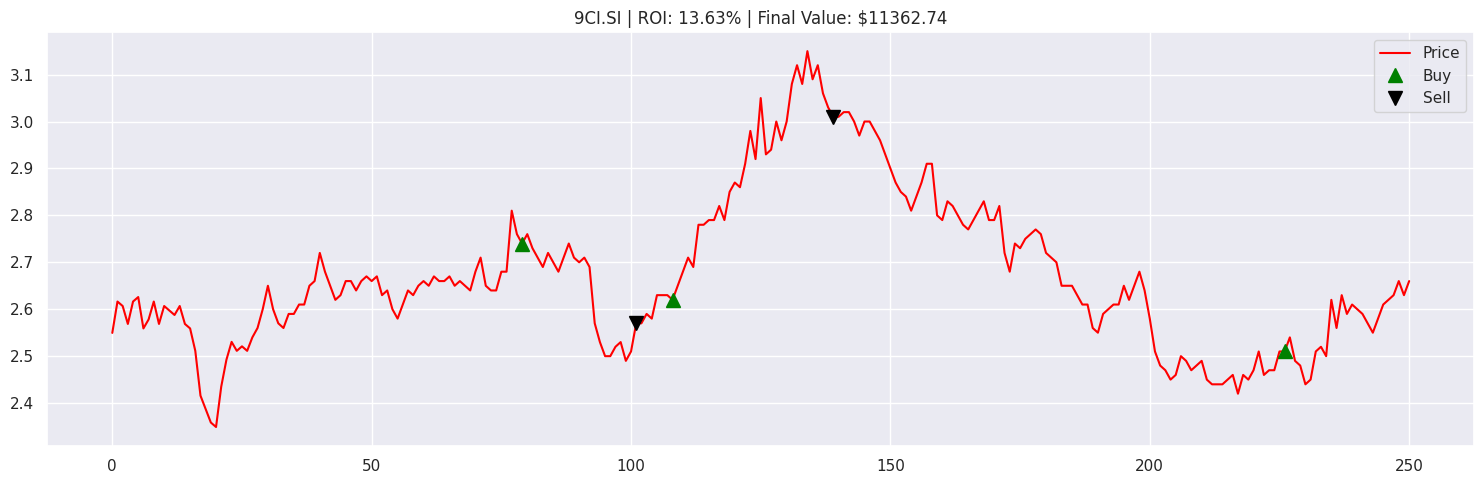


Processing C6L.SI...


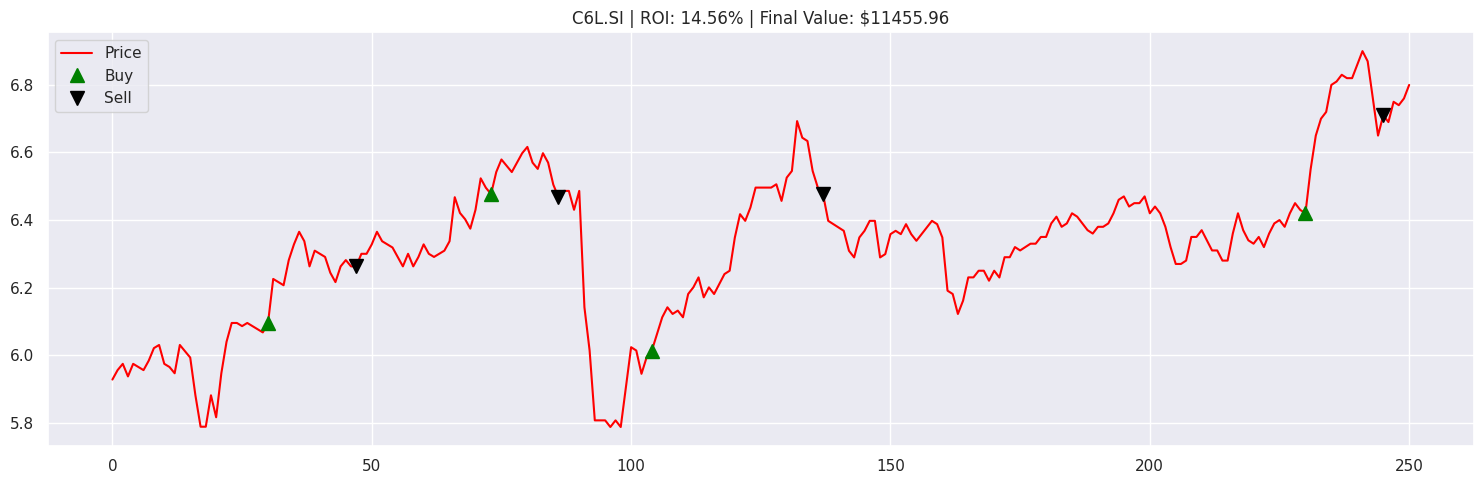


Processing Q0F.SI...


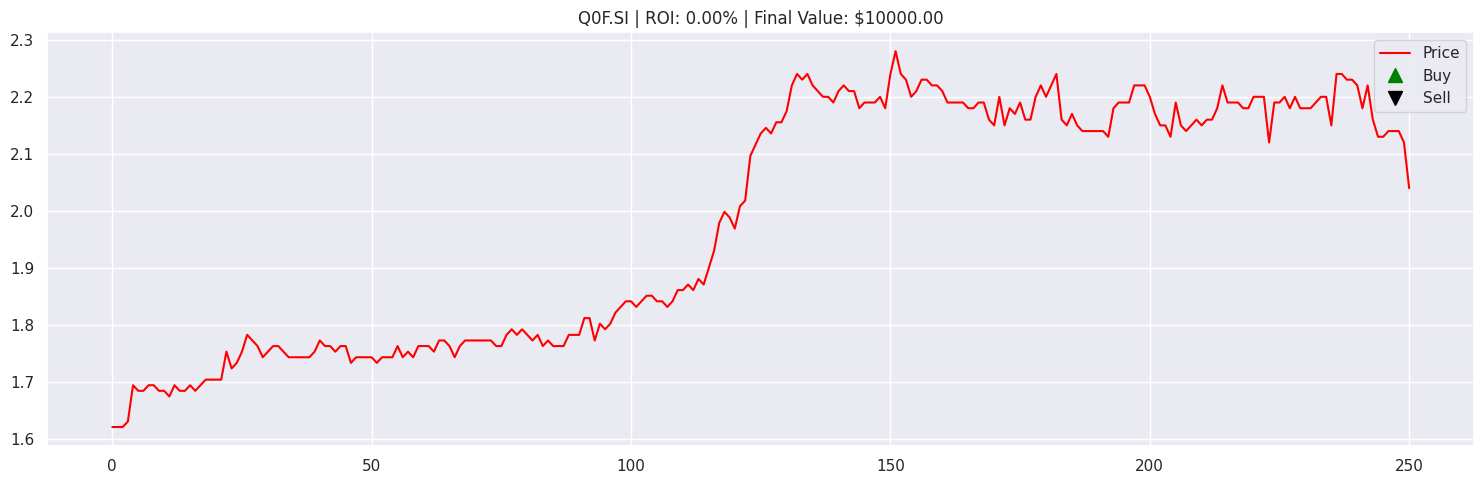


Processing G13.SI...


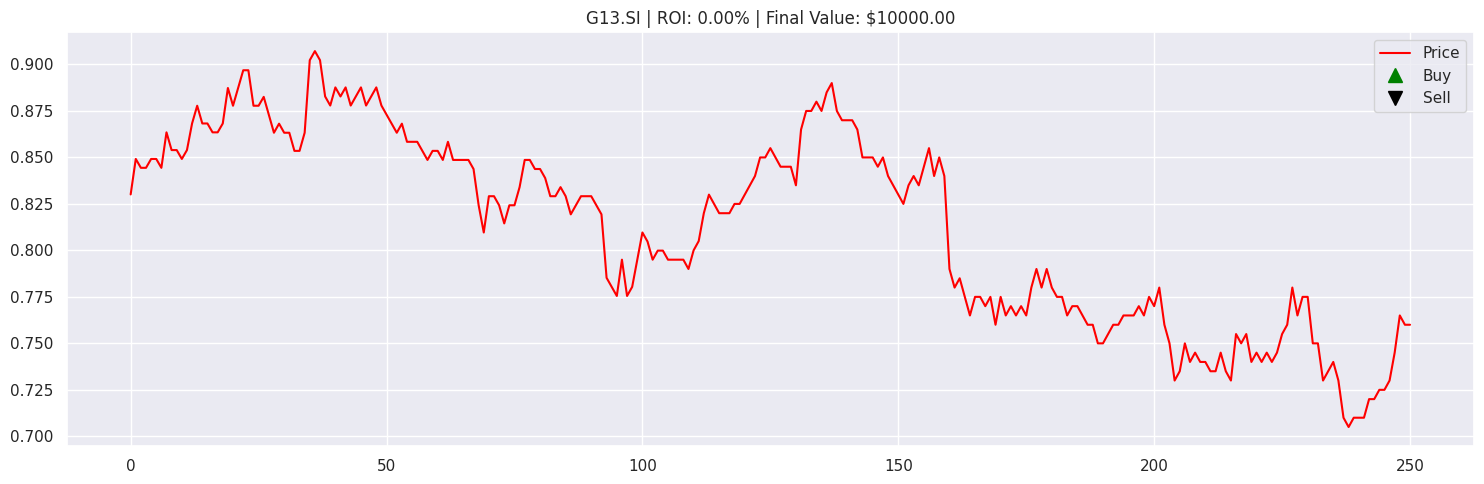


Processing C38U.SI...


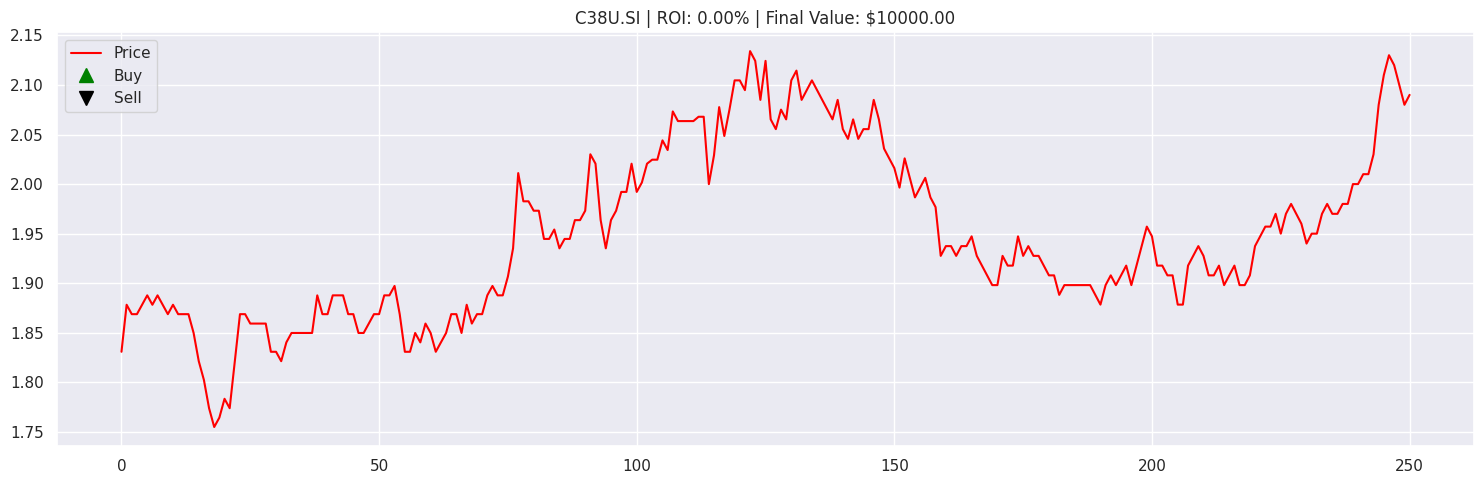


Processing C07.SI...


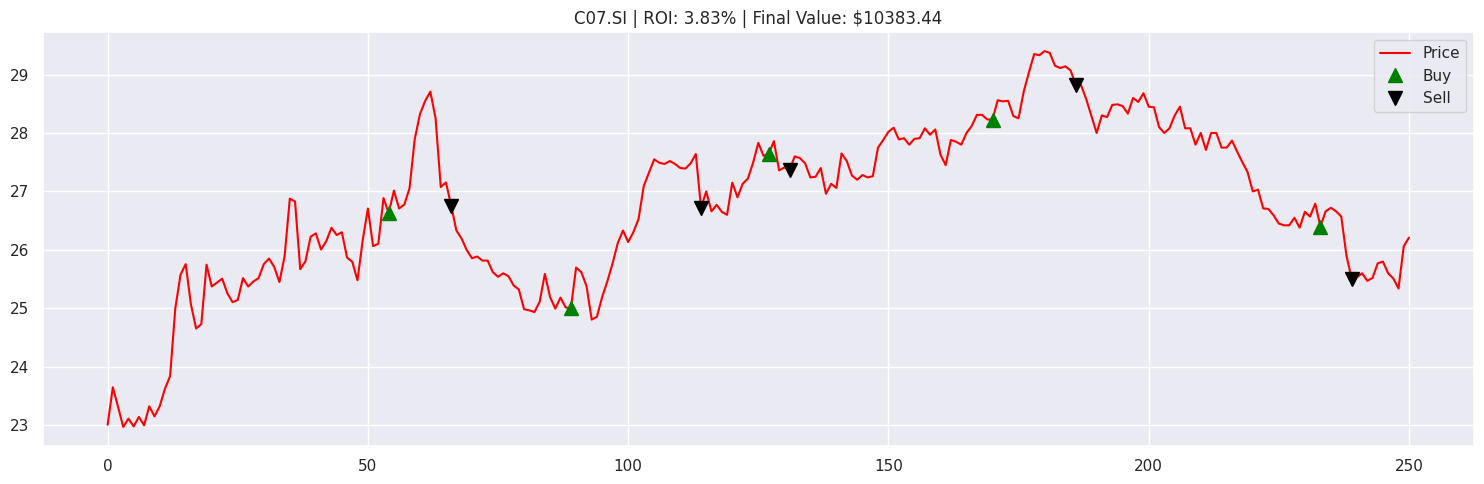


Portfolio Summary:
               ROI   Final Value
9CI.SI   13.627419  11362.741874
C6L.SI   14.559587  11455.958715
Q0F.SI    0.000000  10000.000000
G13.SI    0.000000  10000.000000
C38U.SI   0.000000  10000.000000
C07.SI    3.834415  10383.441526


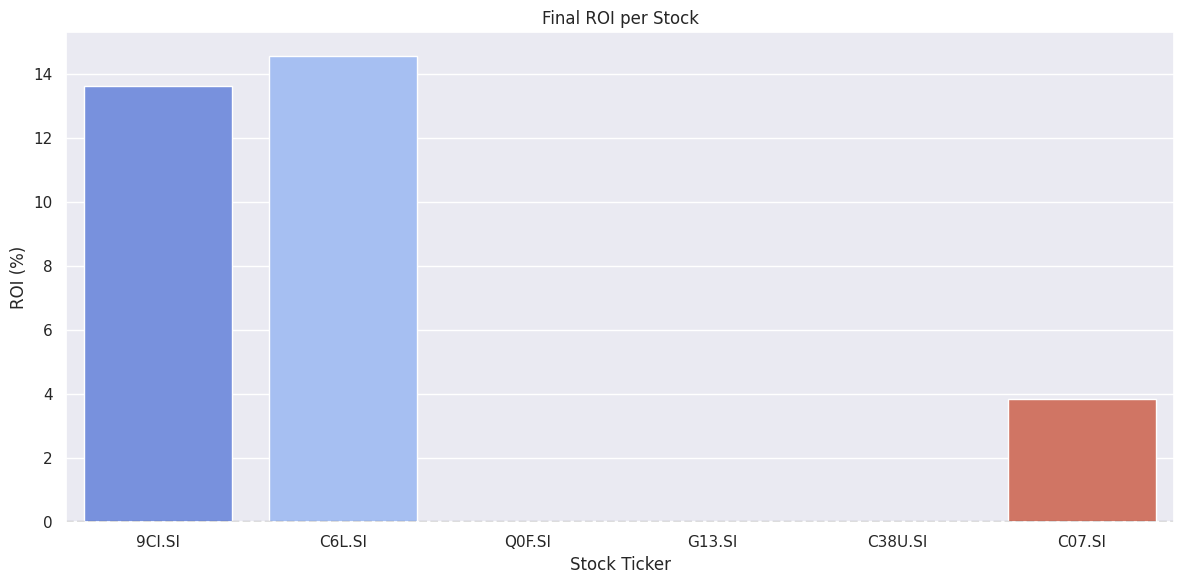

In [13]:
# # ✅ Optimized: Long-Term RL Trading Strategy with Adaptive MACD/RSI/RMA and Smarter Buy-Sell Filtering for Higher ROI

# import numpy as np
# import pandas as pd
# import tensorflow as tf
# import matplotlib.pyplot as plt
# import seaborn as sns
# from collections import deque
# import random

# sns.set()

# # Parameters
# initial_money = 10000
# window_size = 30
# commission = 0.001
# alpha_threshold = 0.01  # More responsive but cautious
# beta_threshold = -0.01
# risk_rsi_low = 30
# risk_rsi_high = 70
# min_trade_profit = 0.005  # Only trade if expected profit > 0.5%


# def RMA(series, period):
#     rma = [series[0]]
#     alpha = 1 / period
#     for price in series[1:]:
#         rma.append((1 - alpha) * rma[-1] + alpha * price)
#     return np.array(rma)


# def apply_second_order_rma(prices):
#     return RMA(RMA(prices, 25), 9)


# def compute_macd(prices, short=12, long=26, signal=9):
#     ema_short = pd.Series(prices).ewm(span=short).mean()
#     ema_long = pd.Series(prices).ewm(span=long).mean()
#     macd_line = ema_short - ema_long
#     signal_line = macd_line.ewm(span=signal).mean()
#     return macd_line.values, signal_line.values


# def compute_rsi(prices, period=14):
#     delta = np.diff(prices)
#     up = np.where(delta > 0, delta, 0)
#     down = np.where(delta < 0, -delta, 0)
#     avg_gain = pd.Series(up).rolling(window=period).mean()
#     avg_loss = pd.Series(down).rolling(window=period).mean()
#     rs = avg_gain / avg_loss
#     rsi = 100 - (100 / (1 + rs))
#     return np.concatenate([np.full(period, np.nan), rsi[period:]])


# class Actor(tf.keras.Model):
#     def __init__(self, input_size, output_size, size_layer):
#         super(Actor, self).__init__()
#         self.lstm = tf.keras.layers.LSTM(size_layer, return_sequences=True, return_state=True)
#         self.dense = tf.keras.layers.Dense(output_size)

#     def call(self, inputs, hidden_state):
#         rnn_output, h, c = self.lstm(inputs, initial_state=hidden_state)
#         logits = self.dense(rnn_output[:, -1])
#         return logits, (h, c)


# class Critic(tf.keras.Model):
#     def __init__(self, input_size, size_layer):
#         super(Critic, self).__init__()
#         self.lstm = tf.keras.layers.LSTM(size_layer, return_sequences=True, return_state=True)
#         self.dense = tf.keras.layers.Dense(1)

#     def call(self, inputs, hidden_state):
#         rnn_output, h, c = self.lstm(inputs, initial_state=hidden_state)
#         value = self.dense(rnn_output[:, -1])
#         return value, (h, c)


# class Agent:
#     def __init__(self, state_size, action_size, size_layer=256):
#         self.state_size = state_size
#         self.action_size = action_size
#         self.size_layer = size_layer
#         self.actor = Actor(state_size, action_size, size_layer)
#         self.critic = Critic(state_size, size_layer)
#         self.actor_optimizer = tf.keras.optimizers.Adam(0.001)
#         self.critic_optimizer = tf.keras.optimizers.Adam(0.001)
#         self.memory = deque(maxlen=1000)
#         self.EPSILON = 0.5
#         self.DECAY_RATE = 0.005
#         self.MIN_EPSILON = 0.1
#         self.GAMMA = 0.99
#         self.BATCH_SIZE = 32

#     def get_state(self, t, trend):
#         d = t - window_size + 1
#         block = trend[d:t+1] if d >= 0 else -d * [trend[0]] + trend[0:t+1]
#         delta = [block[i+1] - block[i] for i in range(window_size - 1)]
#         rma2 = apply_second_order_rma(block)[-1]
#         macd_line, signal_line = compute_macd(block)
#         rsi = compute_rsi(block)
#         macd_diff = macd_line[-1] - signal_line[-1] if len(macd_line) else 0
#         rsi_val = rsi[-1] if not np.isnan(rsi[-1]) else 50
#         return np.array(delta + [rma2, macd_diff, rsi_val])

#     def get_action(self, state):
#         state = np.array(state).reshape(1, self.state_size, 1)
#         hidden = [tf.zeros((1, self.size_layer)), tf.zeros((1, self.size_layer))]
#         logits, _ = self.actor(state, hidden)
#         return tf.argmax(logits[0]).numpy() if np.random.rand() > self.EPSILON else np.random.randint(self.action_size)


# portfolio_results = {}
# tickers = {"Q0F.SI", "C6L.SI", "C38U.SI", "9CI.SI", "C07.SI", "G13.SI"}

# for ticker in tickers:
#     print(f"\nProcessing {ticker}...")
#     df = pd.read_csv(f"/home/priya/Desktop/fyp/Agents/data_store/{ticker}.csv")
#     close = df['Close'].values.tolist()
#     if len(close) < window_size + 20:
#         print(f"Skipping {ticker} due to insufficient data.")
#         continue

#     agent = Agent(window_size - 1 + 3, 3)
#     portfolio = initial_money
#     shares_held = 0
#     states_buy, states_sell = [], []

#     for t in range(window_size, len(close) - 1):
#         state = agent.get_state(t, close)
#         macd_line, signal_line = compute_macd(close[max(0, t-50):t+1])
#         macd_diff = macd_line[-1] - signal_line[-1] if len(macd_line) else 0
#         rsi = compute_rsi(close[max(0, t-50):t+1])
#         rsi_val = rsi[-1] if not np.isnan(rsi[-1]) else 50

#         action = 0
#         current_price = close[t]
#         expected_profit = close[t+1] * (1 - commission) - current_price * (1 + commission)

#         if macd_diff > alpha_threshold and rsi_val < risk_rsi_high and expected_profit > min_trade_profit * current_price:
#             action = 1
#         elif macd_diff < beta_threshold and rsi_val > risk_rsi_low and shares_held > 0:
#             action = 2

#         if action == 1 and portfolio >= current_price * (1 + commission):
#             shares_to_buy = portfolio // (current_price * (1 + commission))
#             portfolio -= shares_to_buy * current_price * (1 + commission)
#             shares_held += shares_to_buy
#             states_buy.append(t)

#         elif action == 2 and shares_held > 0:
#             portfolio += shares_held * current_price * (1 - commission)
#             shares_held = 0
#             states_sell.append(t)

#     portfolio_value = portfolio + shares_held * close[-1]
#     roi = (portfolio_value - initial_money) / initial_money * 100
#     portfolio_results[ticker] = {"ROI": roi, "Final Value": portfolio_value}

#     plt.figure(figsize=(15, 5))
#     plt.plot(close, label='Price', color='red')
#     plt.plot(close, '^', markersize=10, color='green', label='Buy', markevery=states_buy)
#     plt.plot(close, 'v', markersize=10, color='black', label='Sell', markevery=states_sell)
#     plt.title(f"{ticker} | ROI: {roi:.2f}% | Final Value: ${portfolio_value:.2f}")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

# results_df = pd.DataFrame(portfolio_results).T
# print("\nPortfolio Summary:")
# print(results_df)

# plt.figure(figsize=(12, 6))
# sns.barplot(x=results_df.index, y=results_df["ROI"], hue=results_df.index, dodge=False, palette="coolwarm", legend=False)
# plt.axhline(y=0, color='black', linestyle='--')
# plt.title("Final ROI per Stock")
# plt.ylabel("ROI (%)")
# plt.xlabel("Stock Ticker")
# plt.tight_layout()
# plt.show()

🚀 Key Features
✅ Includes Transaction Fees – Each trade incurs a 0.1% commission.
✅ Ignores Small Dips – Uses Simple Moving Average (SMA) filtering.
✅ Realistic Trading Strategy – Partial Selling (50%) instead of full liquidation.
✅ Computes Long-Term ROI – Measures overall return for each stock.
✅ Multiple Visualizations – Plots per stock + overall portfolio ROI.

📊 Expected Outputs
Trading signals plotted for each stock.
Final portfolio value & ROI printed.
Bar plot comparing ROI across stocks.


Processing J36.SI...


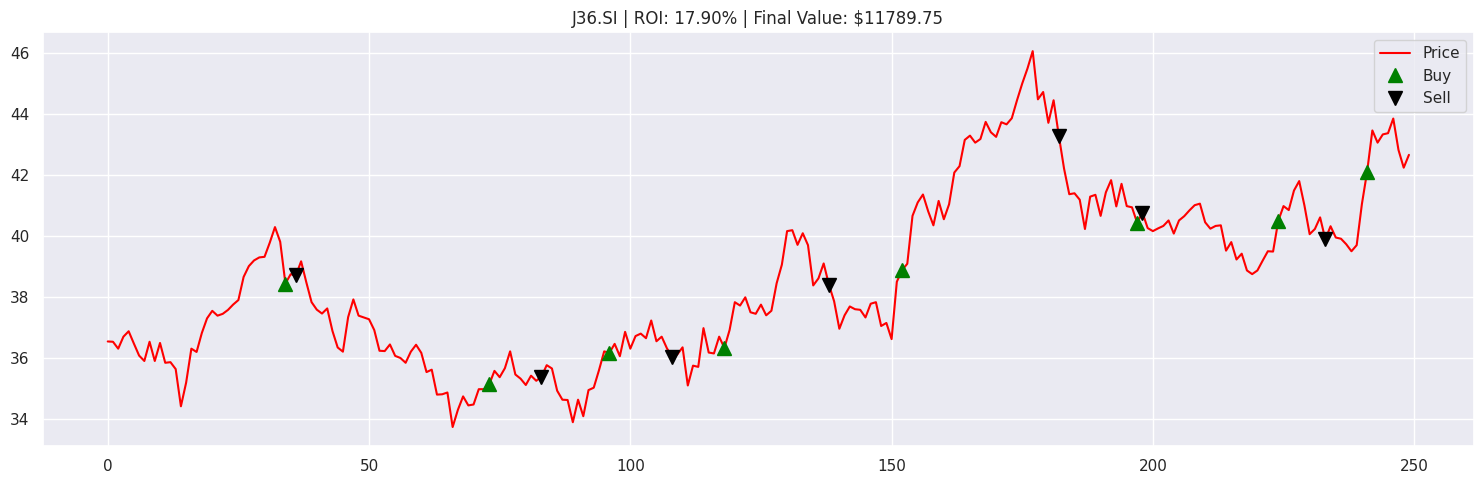


Processing C38U.SI...


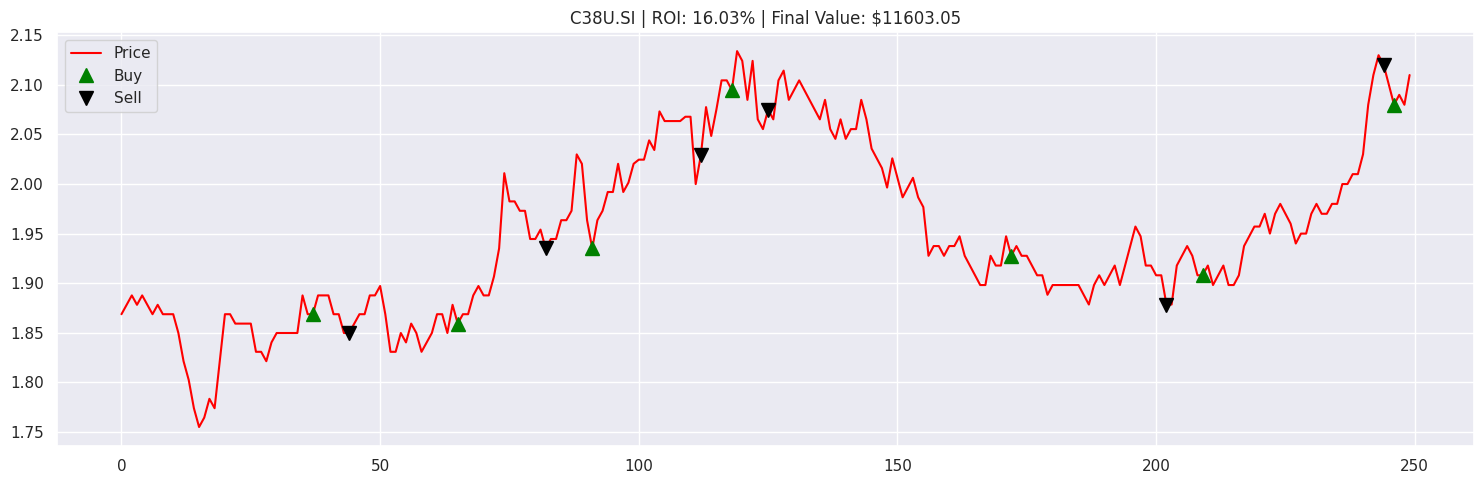


Processing Q0F.SI...


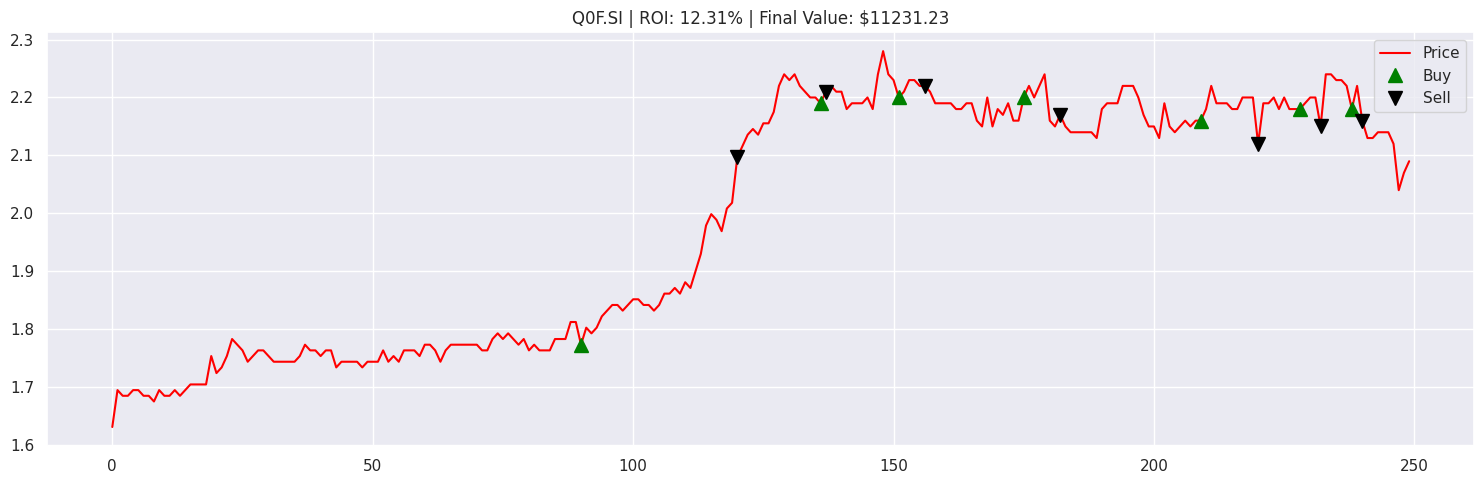


Processing 5E2.SI...


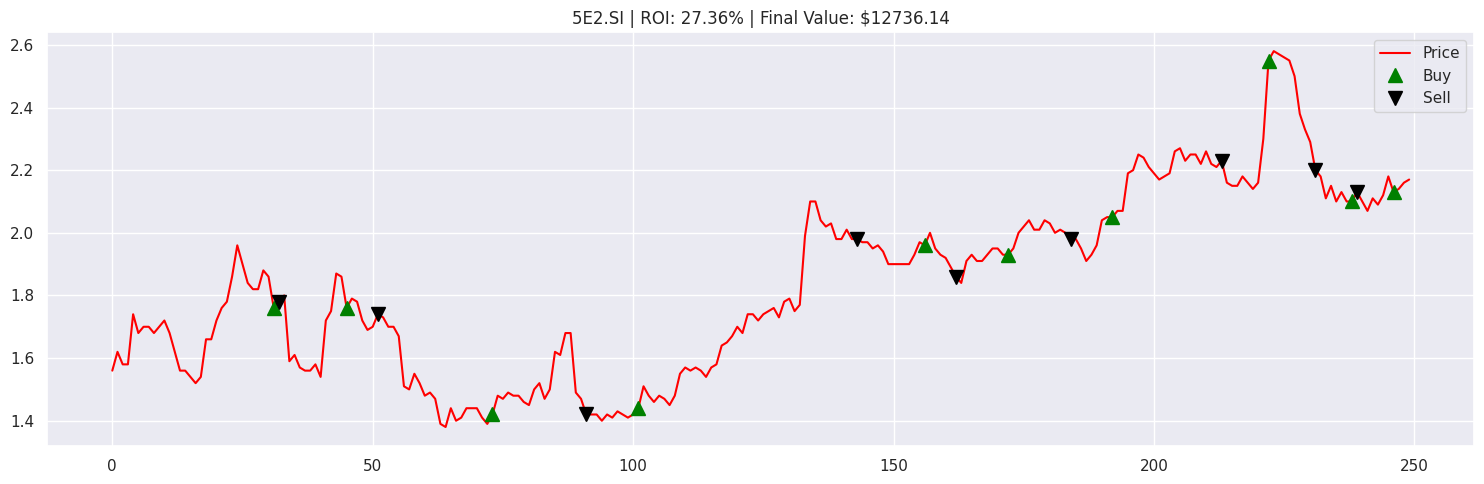


Processing BS6.SI...


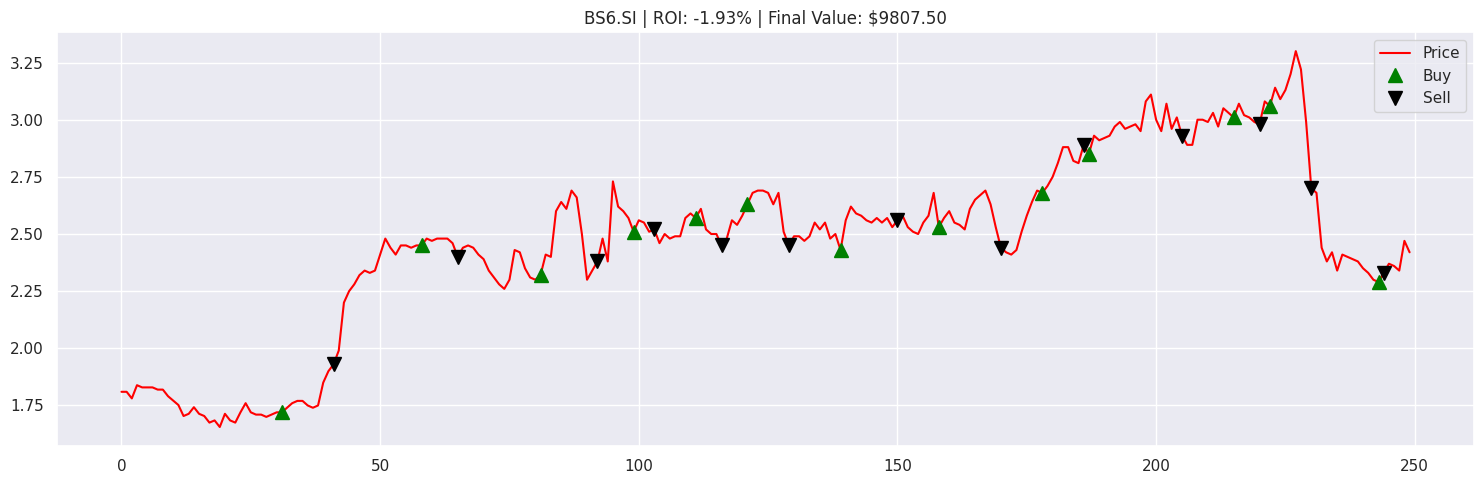


Processing G13.SI...


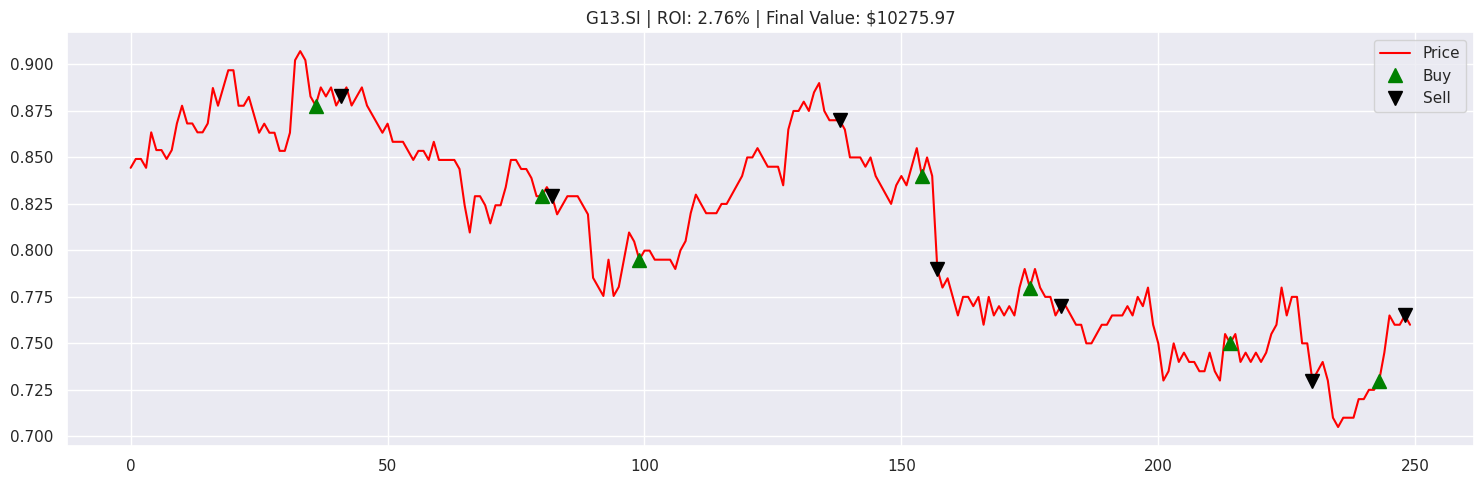


Processing N2IU.SI...


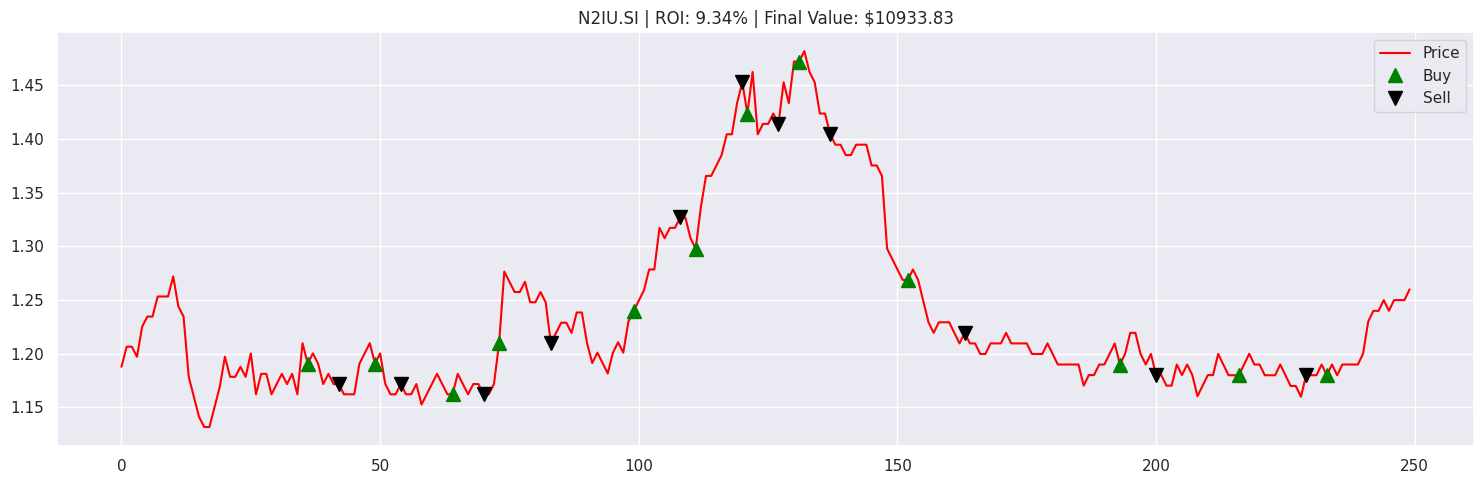


Processing C07.SI...


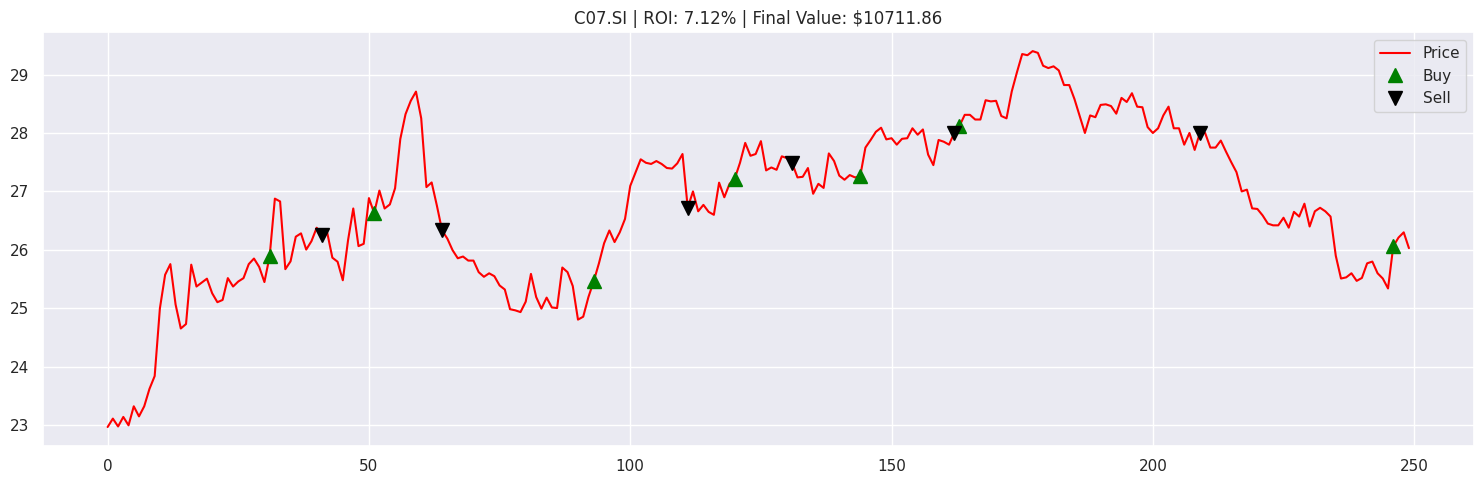


Processing O39.SI...


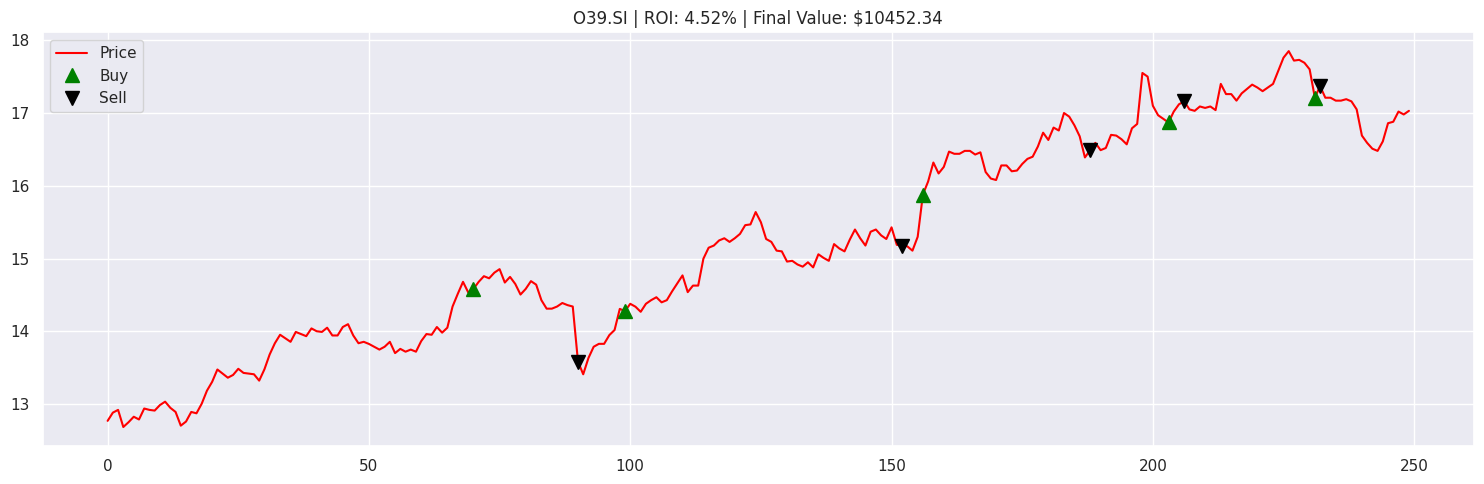


Processing BN4.SI...


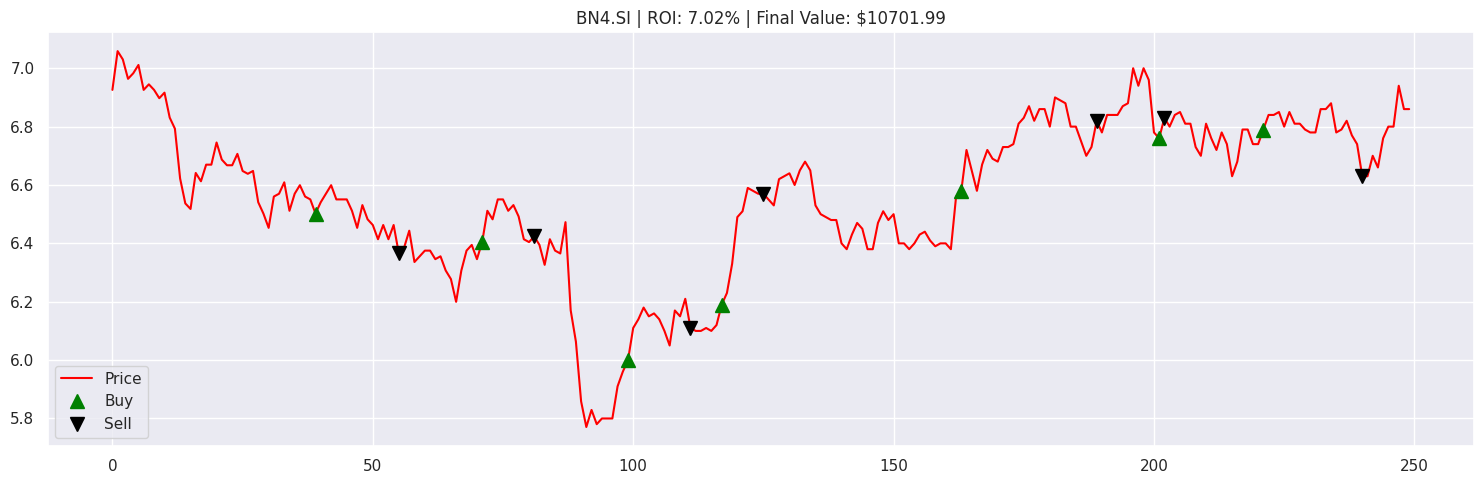


Processing M44U.SI...


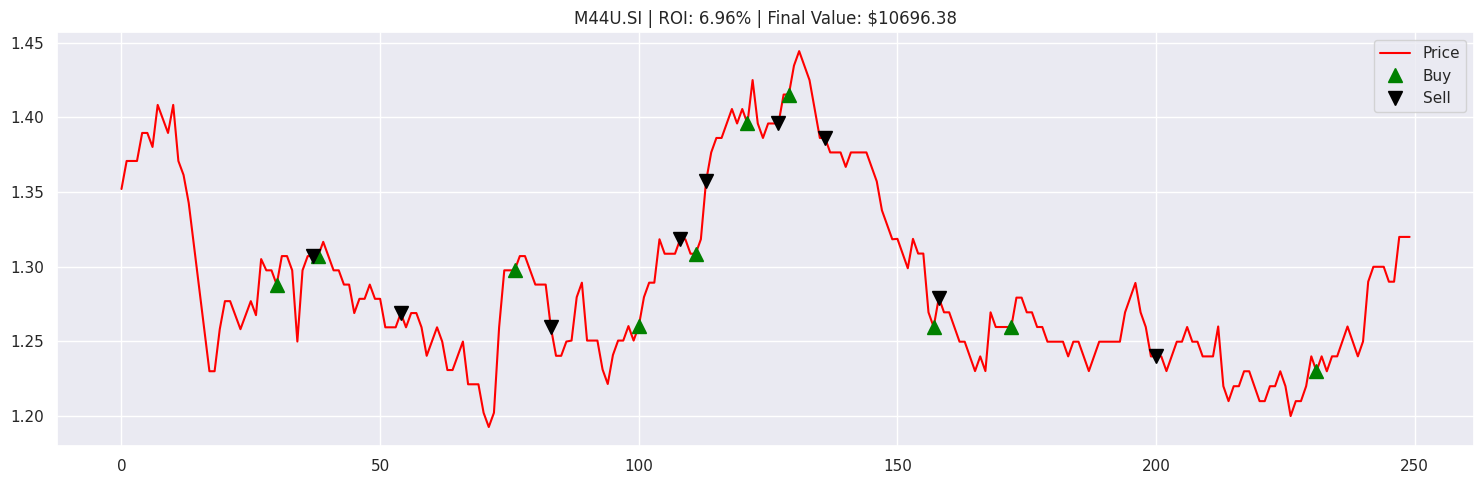


Processing H78.SI...


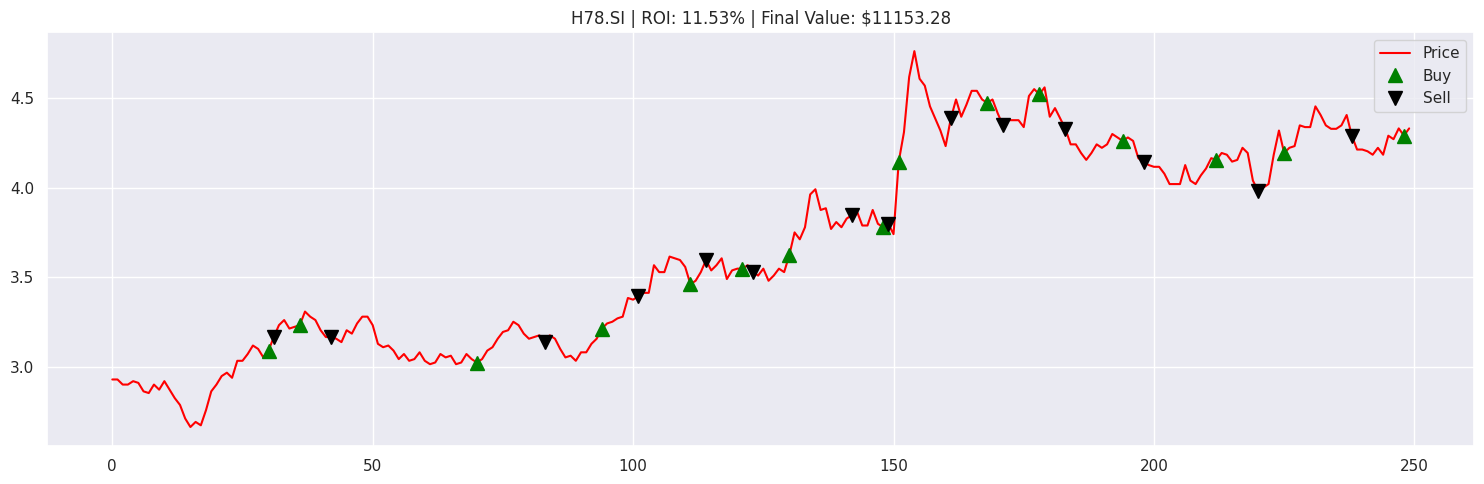


Processing ME8U.SI...


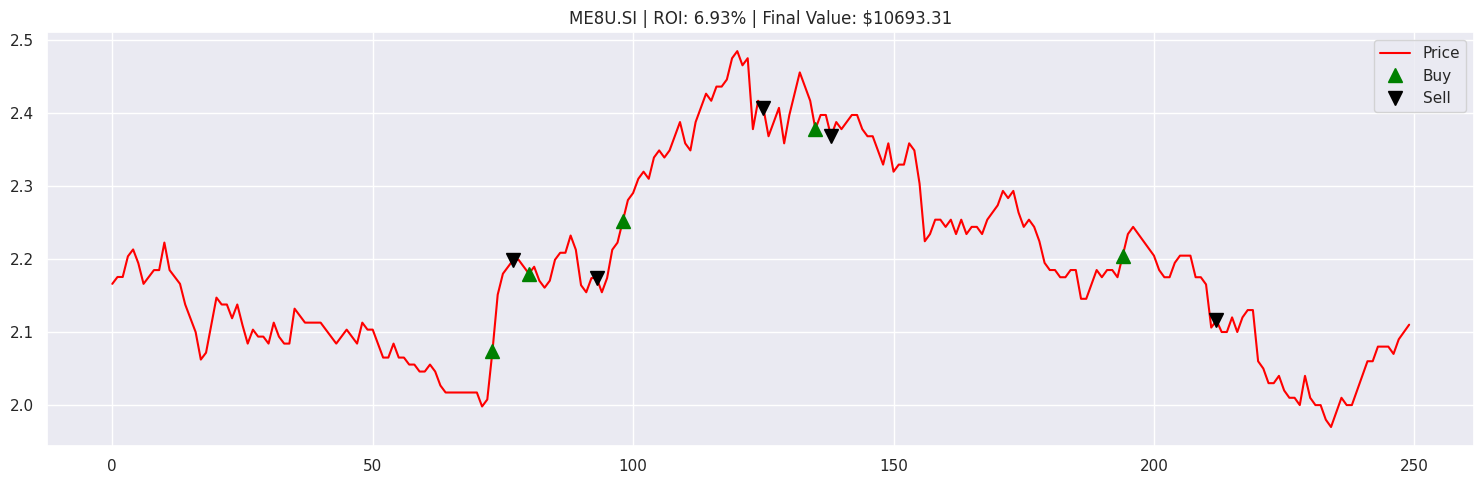


Processing S58.SI...


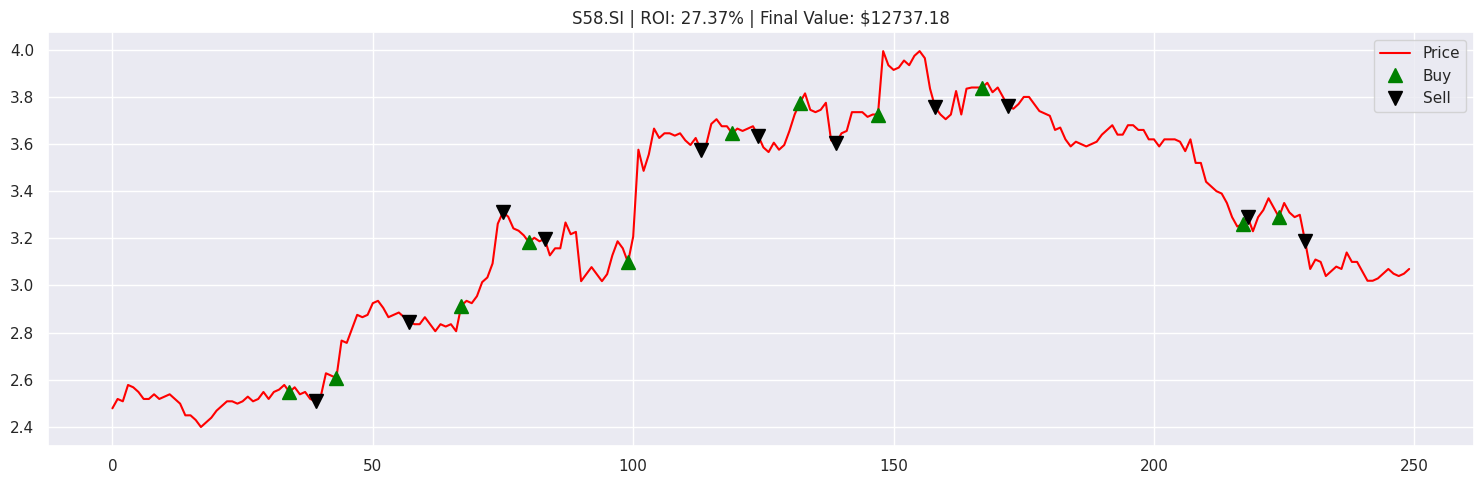


Processing U96.SI...


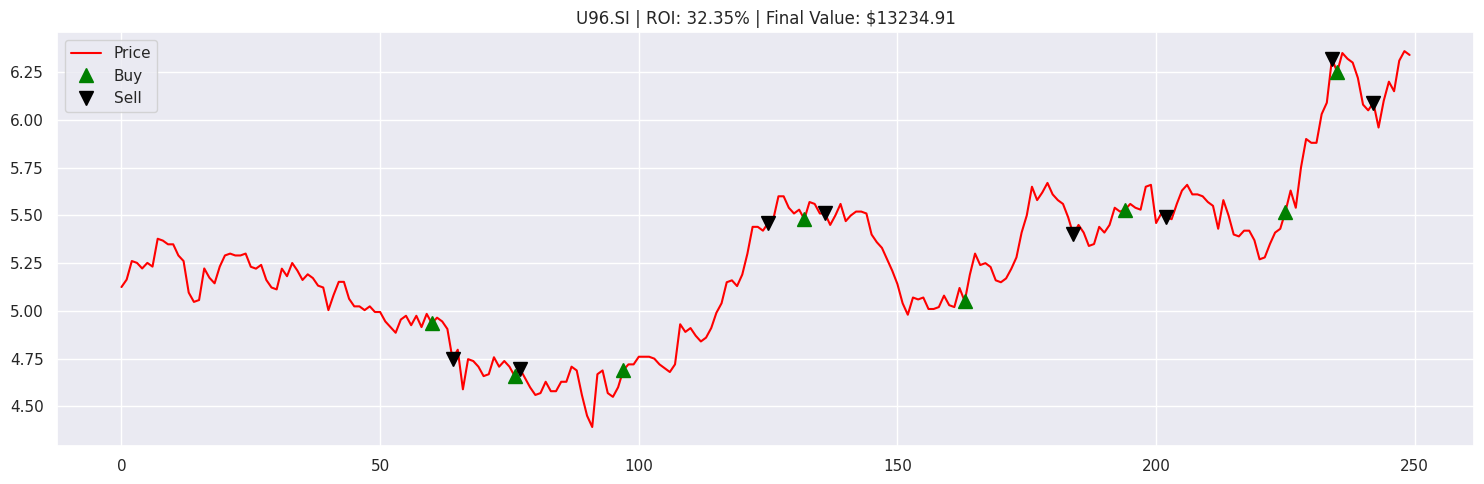


Processing AJBU.SI...


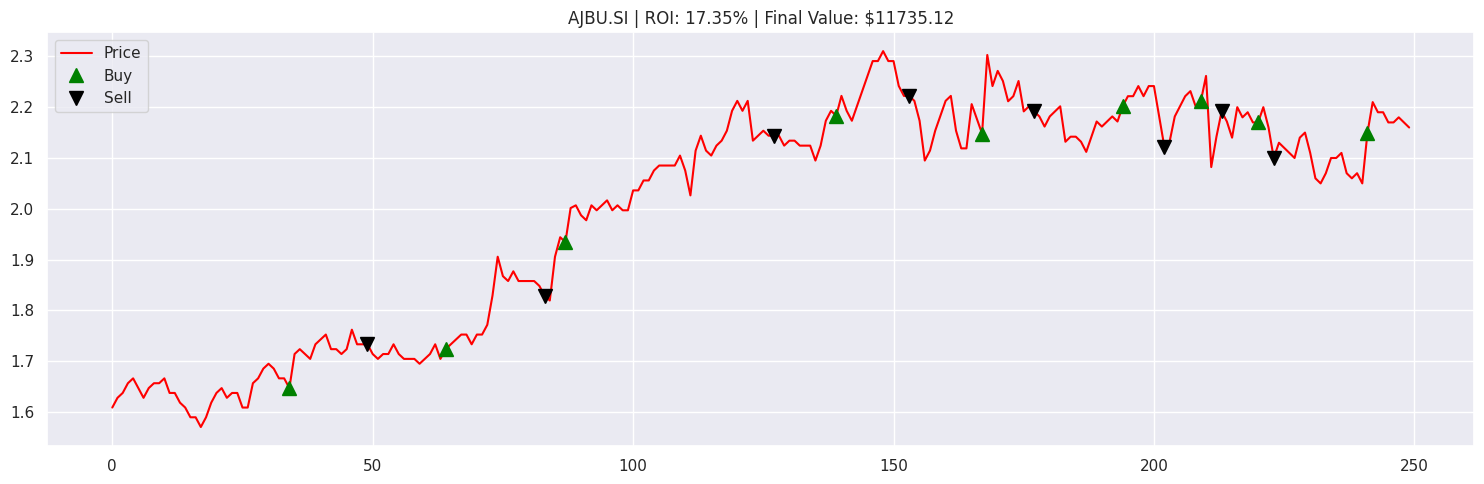


Processing F34.SI...


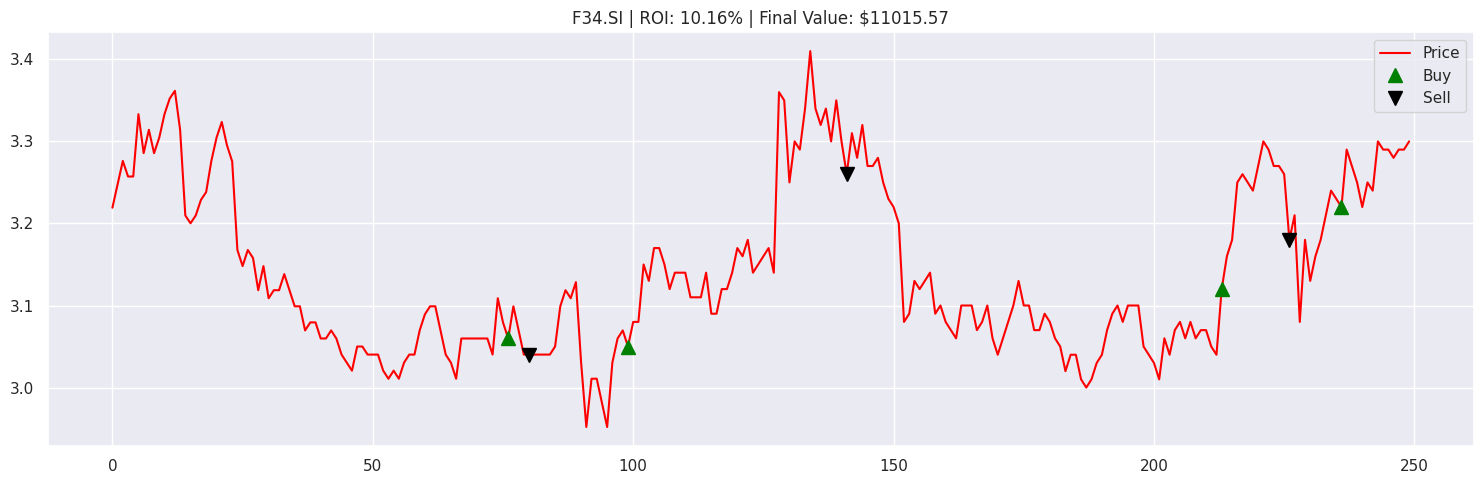


Processing D05.SI...


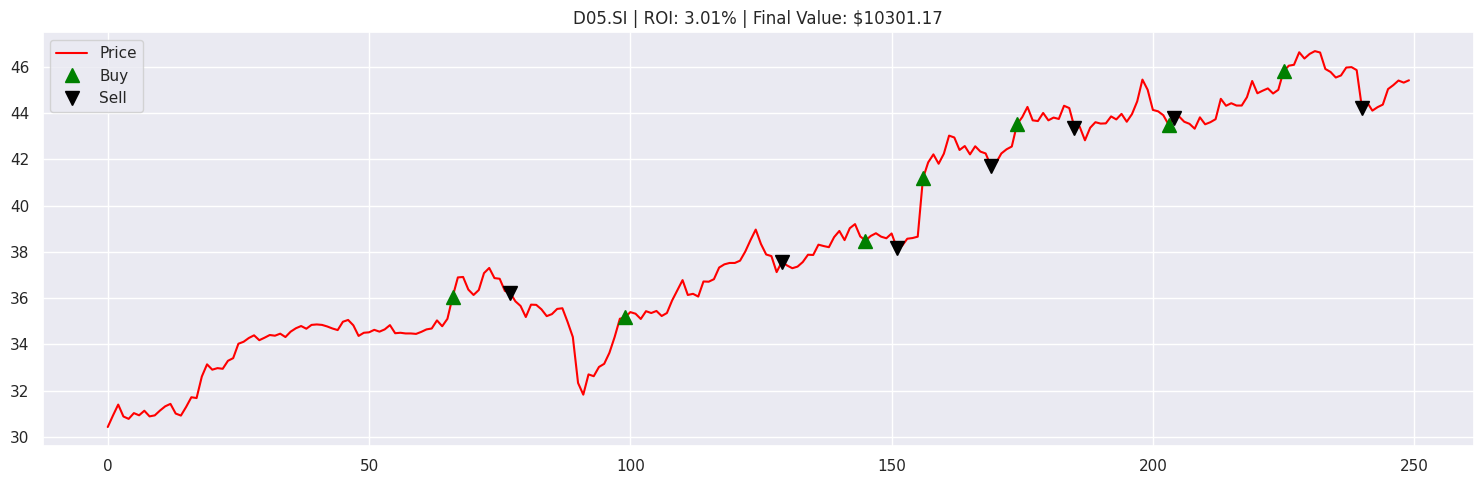


Processing Y92.SI...


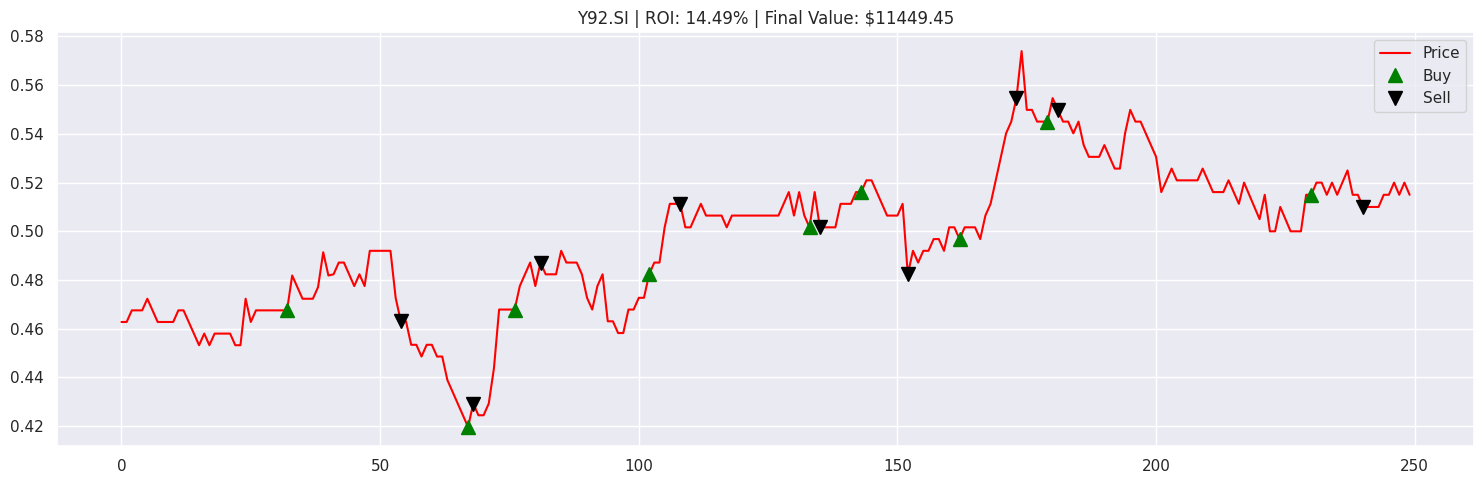


Processing S63.SI...


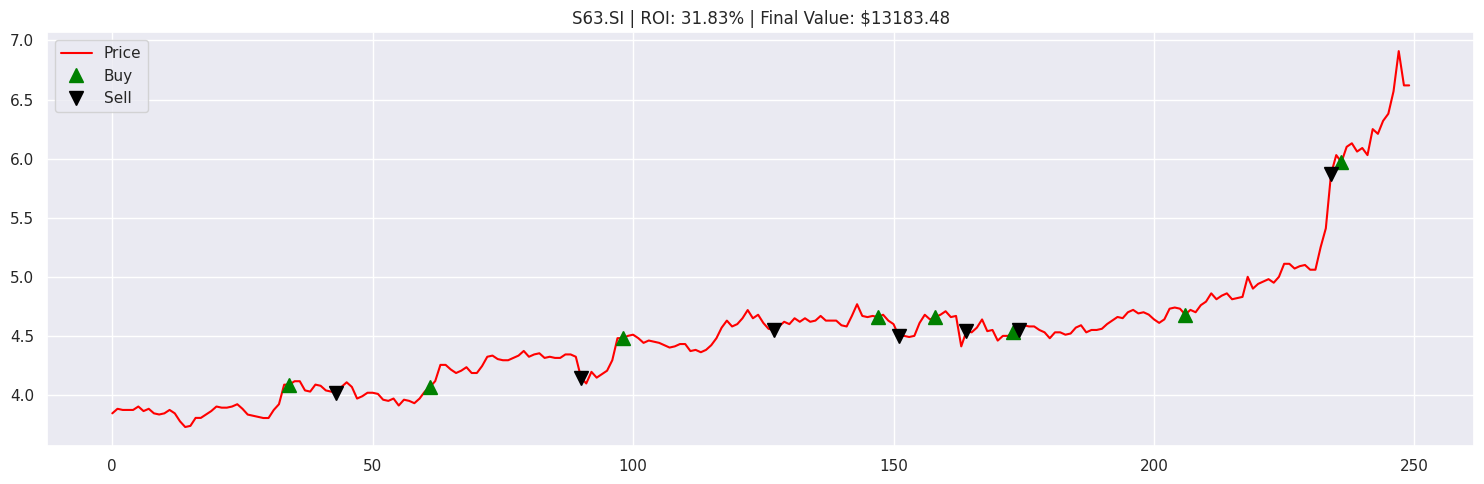


Processing U11.SI...


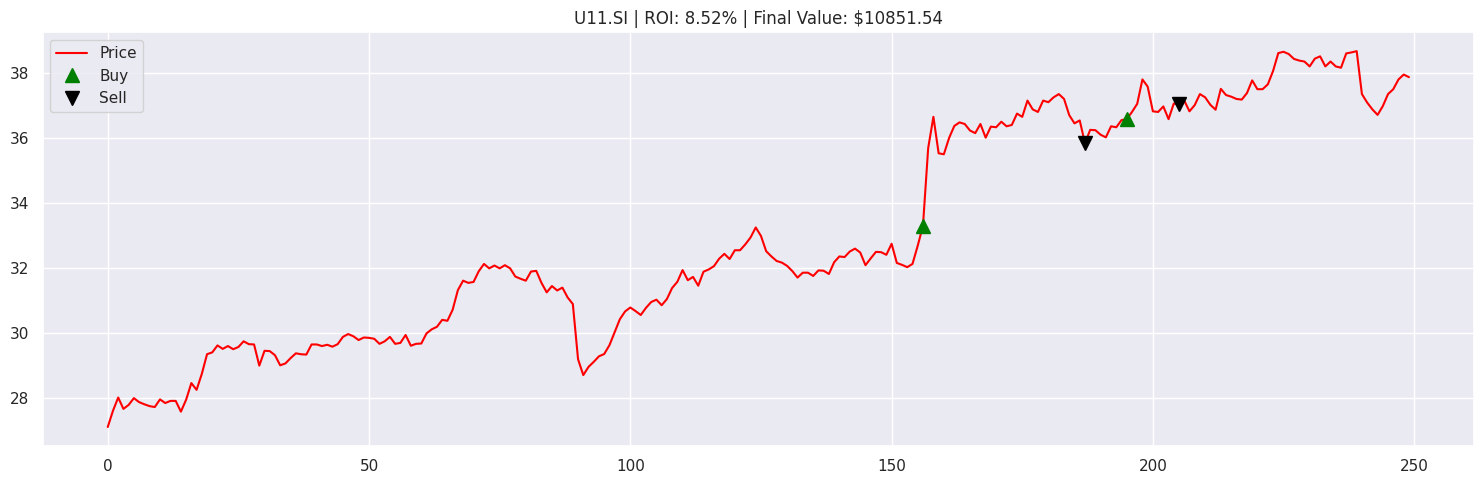


Processing 9CI.SI...


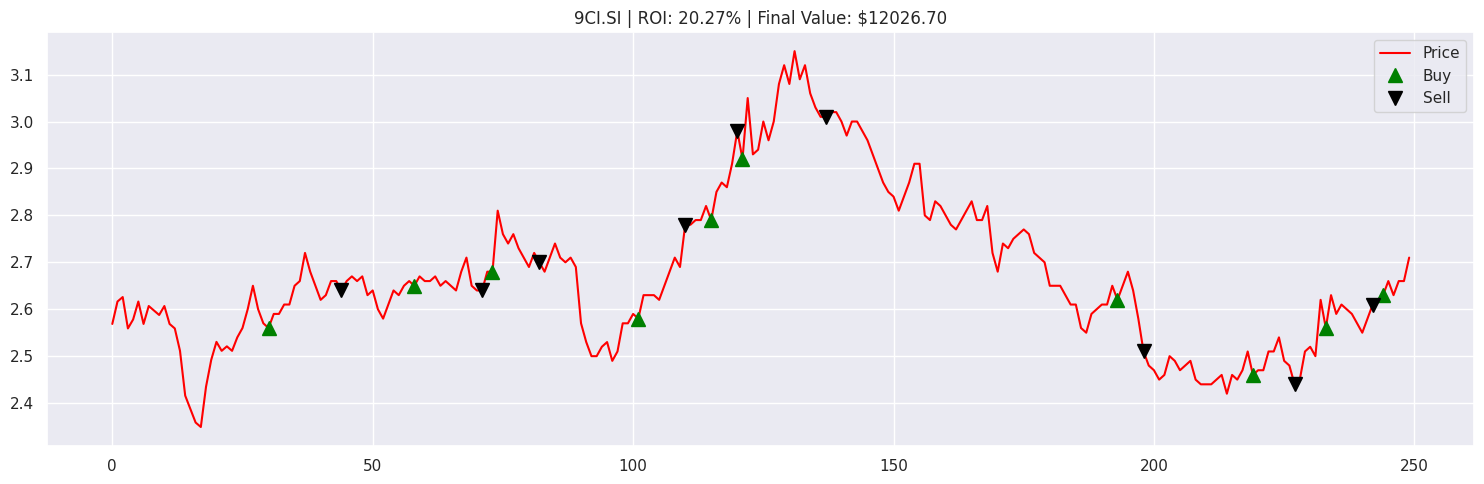


Processing G07.SI...


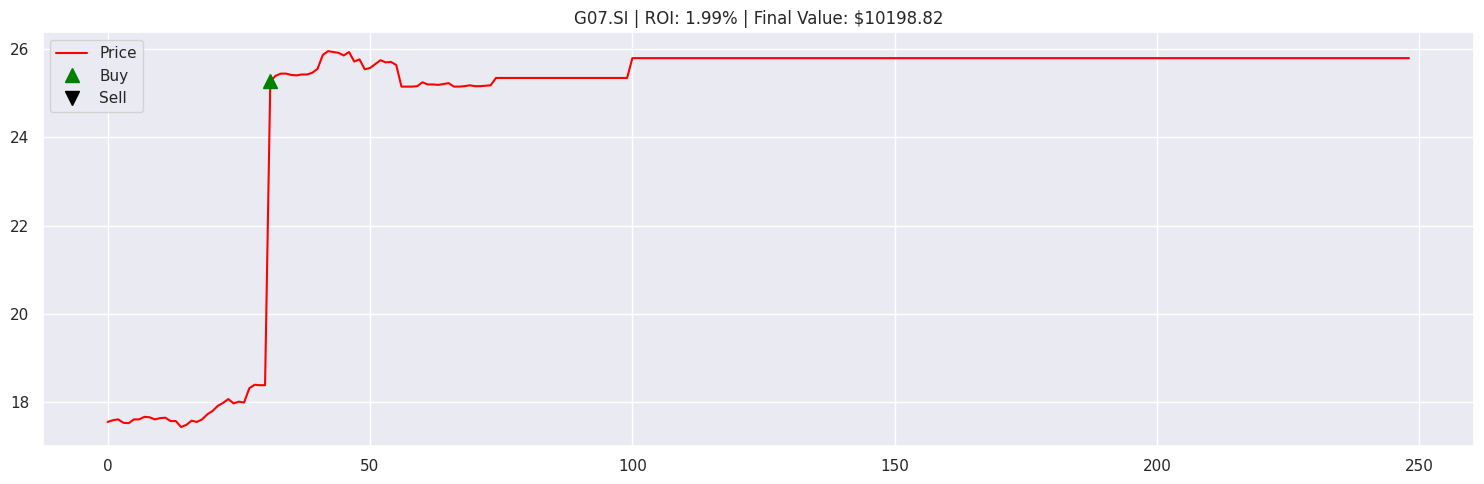


Processing Z74.SI...


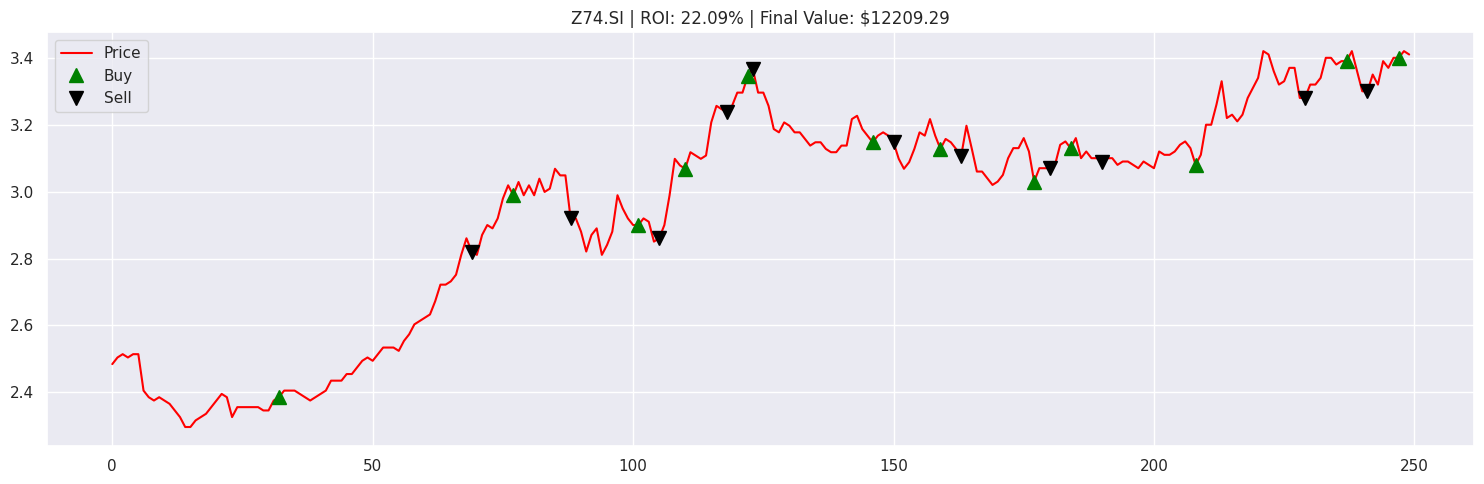


Processing S68.SI...


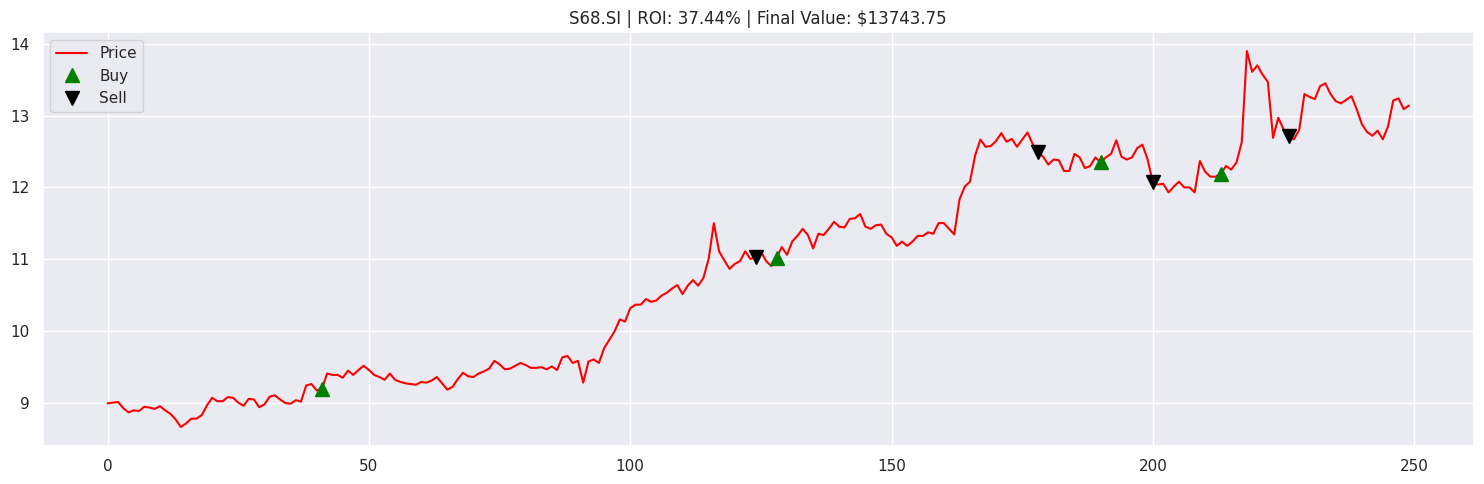


Processing A17U.SI...


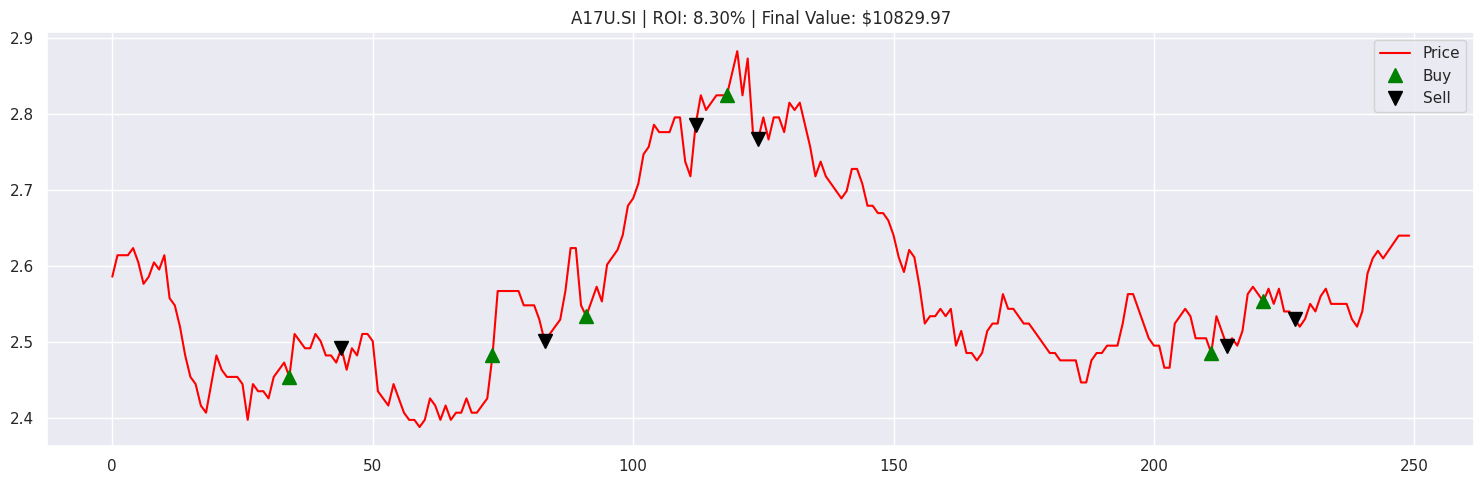


Portfolio Summary:
               ROI   Final Value
J36.SI   17.897513  11789.751345
C38U.SI  16.030481  11603.048066
Q0F.SI   12.312329  11231.232937
5E2.SI   27.361368  12736.136776
BS6.SI   -1.925002   9807.499831
G13.SI    2.759693  10275.969346
N2IU.SI   9.338259  10933.825927
C07.SI    7.118565  10711.856473
O39.SI    4.523427  10452.342681
BN4.SI    7.019948  10701.994771
M44U.SI   6.963792  10696.379179
H78.SI   11.532800  11153.279983
ME8U.SI   6.933076  10693.307615
S58.SI   27.371811  12737.181060
U96.SI   32.349054  13234.905351
AJBU.SI  17.351166  11735.116584
F34.SI   10.155705  11015.570540
D05.SI    3.011745  10301.174531
Y92.SI   14.494496  11449.449638
S63.SI   31.834828  13183.482814
U11.SI    8.515397  10851.539650
9CI.SI   20.267043  12026.704299
G07.SI    1.988166  10198.816580
Z74.SI   22.092950  12209.294974
S68.SI   37.437457  13743.745668
A17U.SI   8.299676  10829.967614


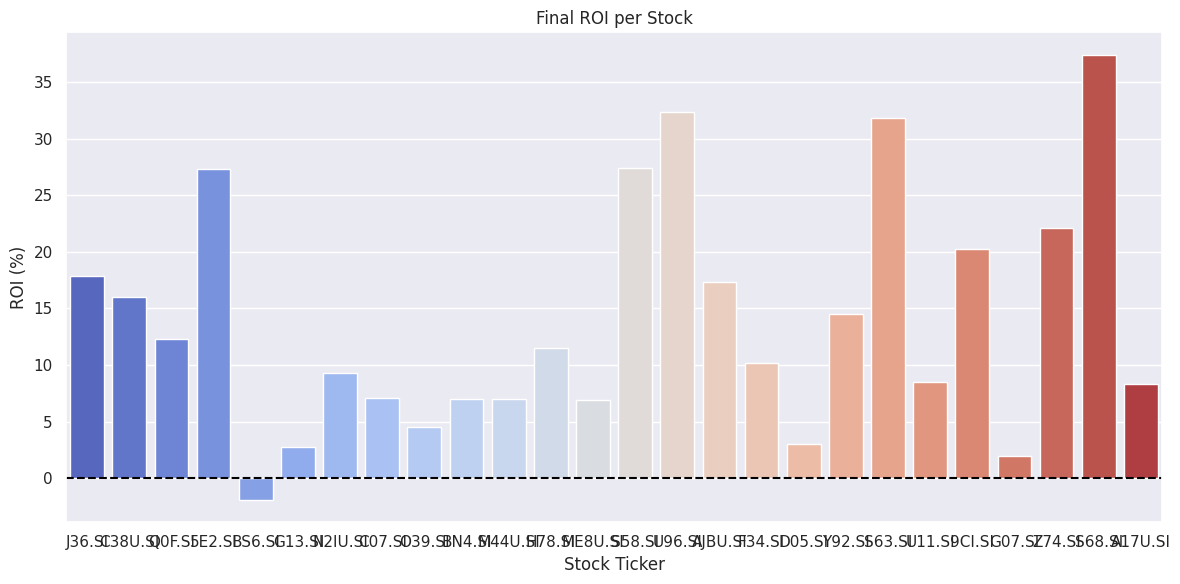

In [5]:
# # ✅ Further Enhanced: Long-Term RL Strategy with Adaptive Signal Blending, Trend Confirmation & Dynamic Scaling

# import numpy as np
# import pandas as pd
# import tensorflow as tf
# import matplotlib.pyplot as plt
# import seaborn as sns
# from collections import deque
# import random

# sns.set()

# # Parameters
# initial_money = 10000
# window_size = 30
# commission = 0.001
# alpha_threshold = 0.004  # Adaptive MACD sensitivity
# beta_threshold = -0.004
# risk_rsi_low = 30
# risk_rsi_high = 70
# min_trade_profit = 0.002
# volatility_buffer = 0.008
# trend_confirm_window = 10
# macd_weight = 0.5
# rsi_weight = 0.3
# trend_weight = 0.2


# def RMA(series, period):
#     rma = [series[0]]
#     alpha = 1 / period
#     for price in series[1:]:
#         rma.append((1 - alpha) * rma[-1] + alpha * price)
#     return np.array(rma)


# def apply_second_order_rma(prices):
#     return RMA(RMA(prices, 25), 9)


# def compute_macd(prices, short=12, long=26, signal=9):
#     ema_short = pd.Series(prices).ewm(span=short).mean()
#     ema_long = pd.Series(prices).ewm(span=long).mean()
#     macd_line = ema_short - ema_long
#     signal_line = macd_line.ewm(span=signal).mean()
#     return macd_line.values, signal_line.values


# def compute_rsi(prices, period=14):
#     delta = np.diff(prices)
#     up = np.where(delta > 0, delta, 0)
#     down = np.where(delta < 0, -delta, 0)
#     avg_gain = pd.Series(up).rolling(window=period).mean()
#     avg_loss = pd.Series(down).rolling(window=period).mean()
#     rs = avg_gain / avg_loss
#     rsi = 100 - (100 / (1 + rs))
#     return np.concatenate([np.full(period, np.nan), rsi[period:]])


# def compute_volatility(prices):
#     returns = np.diff(prices) / prices[:-1]
#     return np.std(returns[-10:])


# def is_uptrend(prices):
#     trend = np.polyfit(range(len(prices)), prices, 1)[0]
#     return trend > 0


# class Actor(tf.keras.Model):
#     def __init__(self, input_size, output_size, size_layer):
#         super(Actor, self).__init__()
#         self.lstm = tf.keras.layers.LSTM(size_layer, return_sequences=True, return_state=True)
#         self.dense = tf.keras.layers.Dense(output_size)

#     def call(self, inputs, hidden_state):
#         rnn_output, h, c = self.lstm(inputs, initial_state=hidden_state)
#         logits = self.dense(rnn_output[:, -1])
#         return logits, (h, c)


# class Critic(tf.keras.Model):
#     def __init__(self, input_size, size_layer):
#         super(Critic, self).__init__()
#         self.lstm = tf.keras.layers.LSTM(size_layer, return_sequences=True, return_state=True)
#         self.dense = tf.keras.layers.Dense(1)

#     def call(self, inputs, hidden_state):
#         rnn_output, h, c = self.lstm(inputs, initial_state=hidden_state)
#         value = self.dense(rnn_output[:, -1])
#         return value, (h, c)


# class A2CAgent:
#     def __init__(self, state_size, action_size, size_layer=256):
#         self.state_size = state_size
#         self.action_size = action_size
#         self.size_layer = size_layer
#         self.actor = Actor(state_size, action_size, size_layer)
#         self.critic = Critic(state_size, size_layer)
#         self.actor_optimizer = tf.keras.optimizers.Adam(0.001)
#         self.critic_optimizer = tf.keras.optimizers.Adam(0.001)
#         self.memory = deque(maxlen=1000)

#     def get_state(self, t, trend):
#         d = t - window_size + 1
#         block = trend[d:t+1] if d >= 0 else -d * [trend[0]] + trend[0:t+1]
#         delta = [block[i+1] - block[i] for i in range(window_size - 1)]
#         rma2 = apply_second_order_rma(block)[-1]
#         macd_line, signal_line = compute_macd(block)
#         rsi = compute_rsi(block)
#         macd_diff = macd_line[-1] - signal_line[-1] if len(macd_line) else 0
#         rsi_val = rsi[-1] if not np.isnan(rsi[-1]) else 50
#         return np.array(delta + [rma2, macd_diff, rsi_val])

#     def get_action(self, state):
#         state = np.array(state).reshape(1, self.state_size, 1)
#         hidden = [tf.zeros((1, self.size_layer)), tf.zeros((1, self.size_layer))]
#         logits, _ = self.actor(state, hidden)
#         return tf.argmax(logits[0]).numpy()


# portfolio_results = {}
# # tickers = {"Q0F.SI", "C6L.SI", "C38U.SI", "9CI.SI", "C07.SI", "G13.SI", "O39.SI", "S68.SI", "G07.SI"}
# tickers ={
#     "D05.SI",
#     "O39.SI",
#     "U11.SI",
#     "Z74.SI",
#     "F34.SI",
#     "Q0F.SI",
#     "S63.SI",
#     "J36.SI",
#     "S68.SI",
#     "C38U.SI",
#     "Y92.SI",
#     "H78.SI",
#     "9CI.SI",
#     "G07.SI",
#     "BN4.SI",
#     "BS6.SI",
#     "A17U.SI",
#     "C07.SI",
#     "U96.SI",
#     "G13.SI",
#     "5E2.SI",
#     "N2IU.SI",
#     "M44U.SI",
#     "ME8U.SI",
#     "S58.SI",
#     "AJBU.SI"
# }


# for ticker in tickers:
#     print(f"\nProcessing {ticker}...")
#     df = pd.read_csv(f"/home/priya/Desktop/fyp/Agents/data_store/{ticker}.csv")
#     close = df['Close'].values.tolist()
#     if len(close) < window_size + 20:
#         print(f"Skipping {ticker} due to insufficient data.")
#         continue

#     agent = A2CAgent(window_size - 1 + 3, 3)
#     portfolio = initial_money
#     shares_held = 0
#     states_buy, states_sell = [], []

#     for t in range(window_size, len(close) - 1):
#         state = agent.get_state(t, close)
#         macd_line, signal_line = compute_macd(close[max(0, t-50):t+1])
#         macd_diff = macd_line[-1] - signal_line[-1] if len(macd_line) else 0
#         rsi = compute_rsi(close[max(0, t-50):t+1])
#         rsi_val = rsi[-1] if not np.isnan(rsi[-1]) else 50
#         vol = compute_volatility(close[max(0, t-20):t+1])
#         trend_score = 1 if is_uptrend(close[max(0, t-trend_confirm_window):t+1]) else -1

#         weighted_signal = macd_weight * macd_diff + rsi_weight * ((50 - rsi_val) / 50) + trend_weight * trend_score
#         current_price = close[t]
#         expected_profit = close[t+1] * (1 - commission) - current_price * (1 + commission)

#         action = 0
#         if weighted_signal > alpha_threshold and expected_profit > min_trade_profit * current_price and vol > volatility_buffer:
#             action = 1
#         elif weighted_signal < beta_threshold and shares_held > 0 and vol > volatility_buffer:
#             action = 2

#         if action == 1 and portfolio >= current_price * (1 + commission):
#             shares_to_buy = portfolio // (current_price * (1 + commission))
#             portfolio -= shares_to_buy * current_price * (1 + commission)
#             shares_held += shares_to_buy
#             states_buy.append(t)

#         elif action == 2 and shares_held > 0:
#             portfolio += shares_held * current_price * (1 - commission)
#             shares_held = 0
#             states_sell.append(t)

#     portfolio_value = portfolio + shares_held * close[-1]
#     roi = (portfolio_value - initial_money) / initial_money * 100
#     portfolio_results[ticker] = {"ROI": roi, "Final Value": portfolio_value}

#     plt.figure(figsize=(15, 5))
#     plt.plot(close, label='Price', color='red')
#     plt.plot(close, '^', markersize=10, color='green', label='Buy', markevery=states_buy)
#     plt.plot(close, 'v', markersize=10, color='black', label='Sell', markevery=states_sell)
#     plt.title(f"{ticker} | ROI: {roi:.2f}% | Final Value: ${portfolio_value:.2f}")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

# results_df = pd.DataFrame(portfolio_results).T
# print("\nPortfolio Summary:")
# print(results_df)
# results_df.to_csv('results_actorcritic.csv')

# plt.figure(figsize=(12, 6))
# sns.barplot(x=results_df.index, y=results_df["ROI"], hue=results_df.index, dodge=False, palette="coolwarm", legend=False)
# plt.axhline(y=0, color='black', linestyle='--')
# plt.title("Final ROI per Stock")
# plt.ylabel("ROI (%)")
# plt.xlabel("Stock Ticker")
# plt.tight_layout()
# plt.show()


Processing U11.SI...


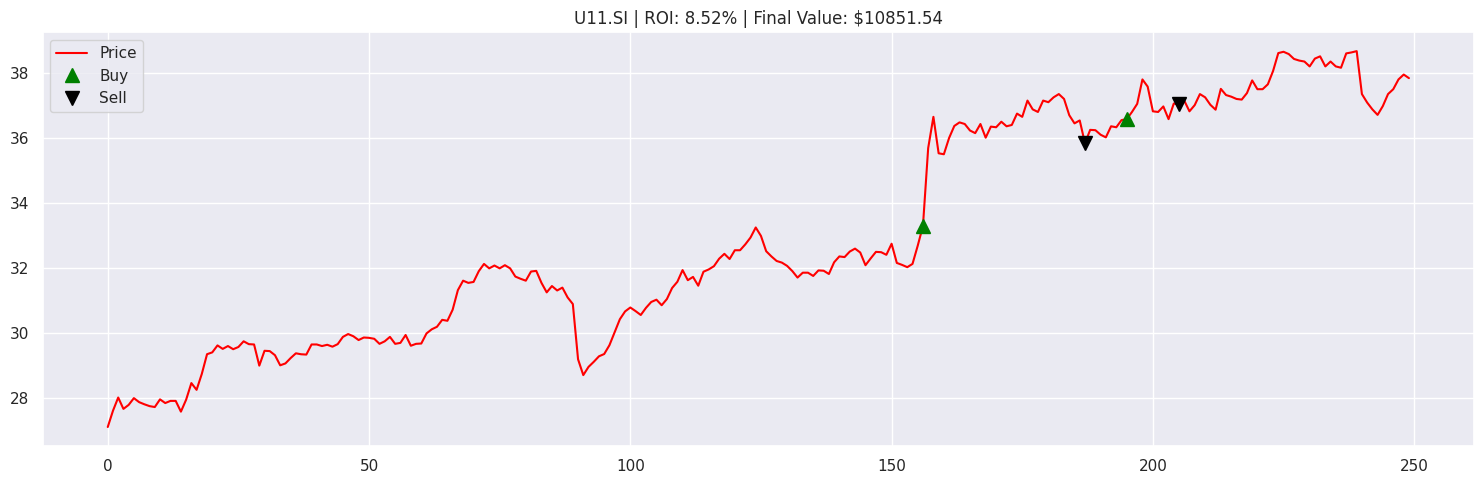


Processing C38U.SI...


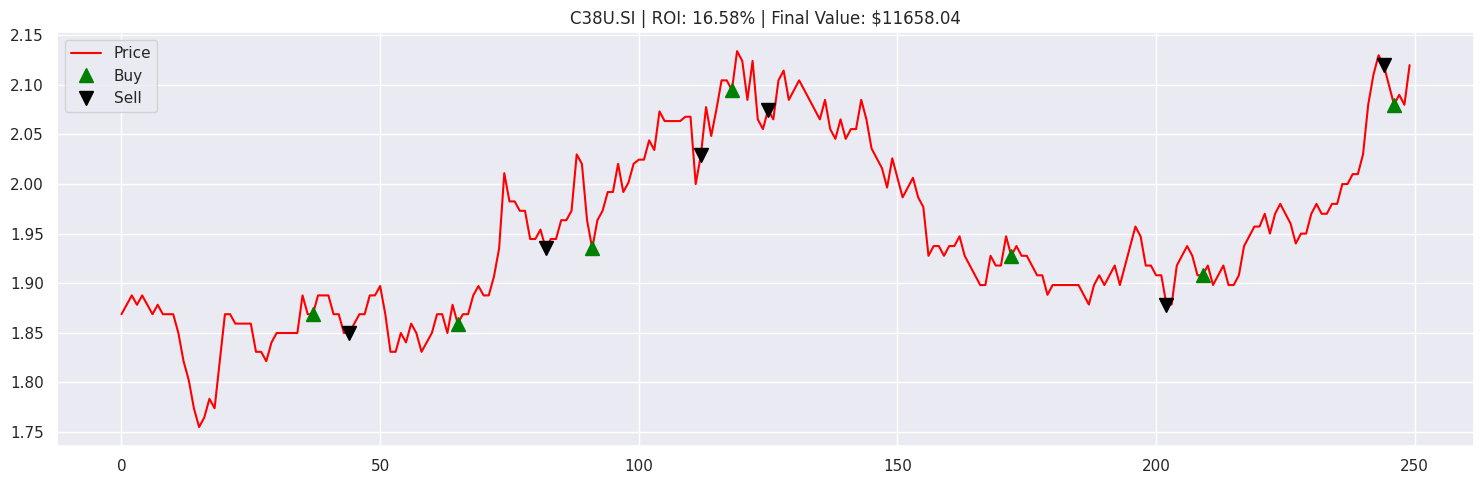


Processing Q0F.SI...


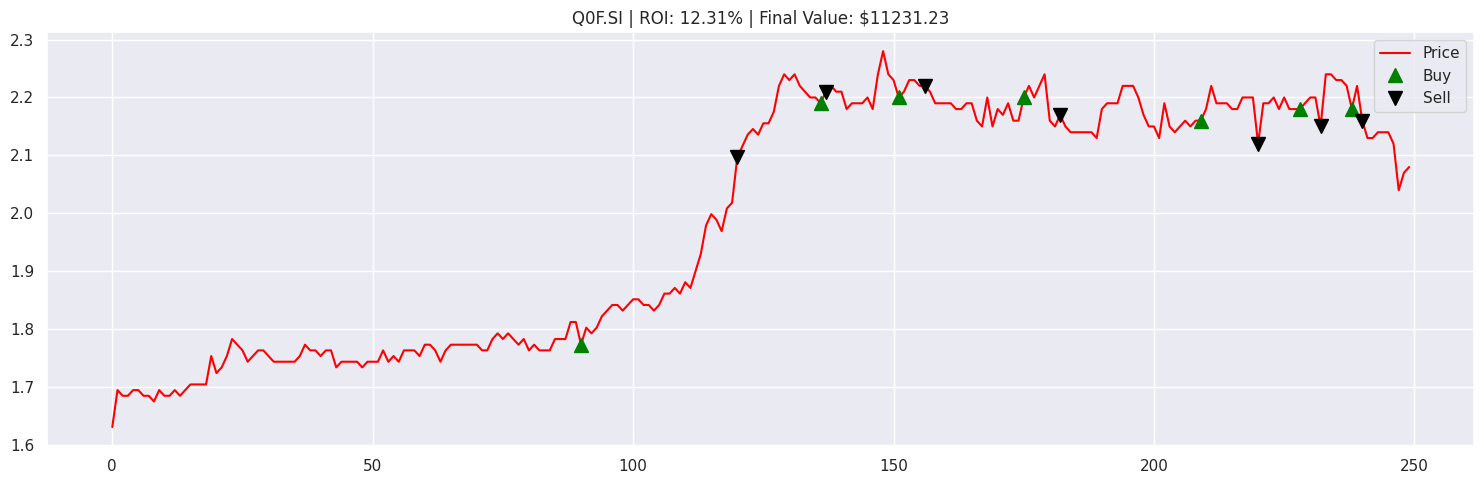


Processing S68.SI...


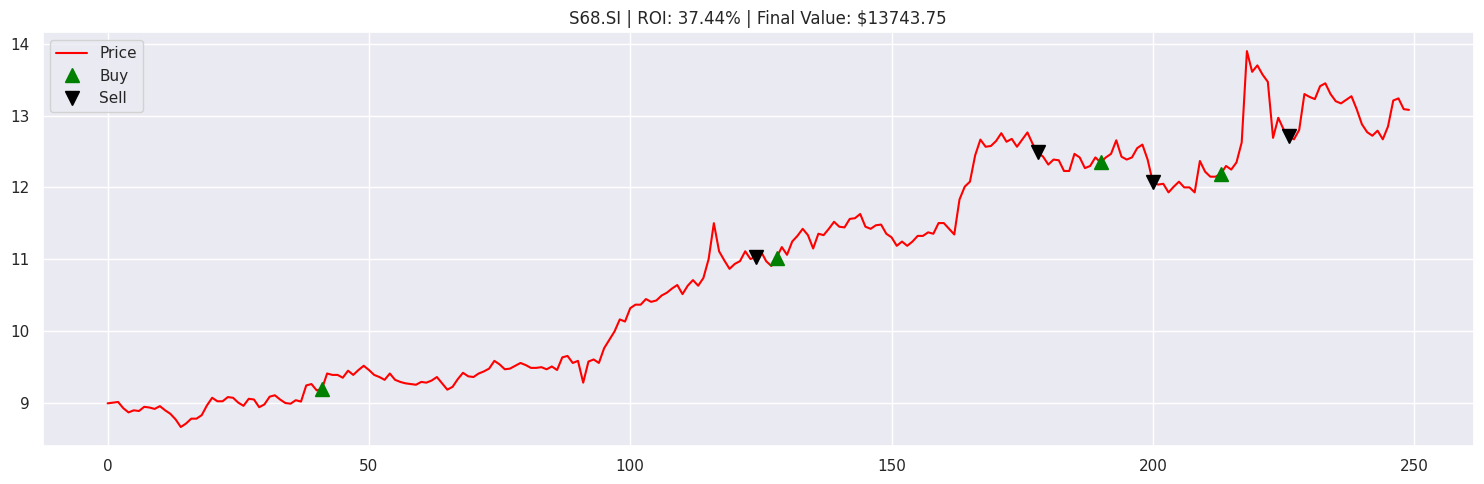


Processing S63.SI...


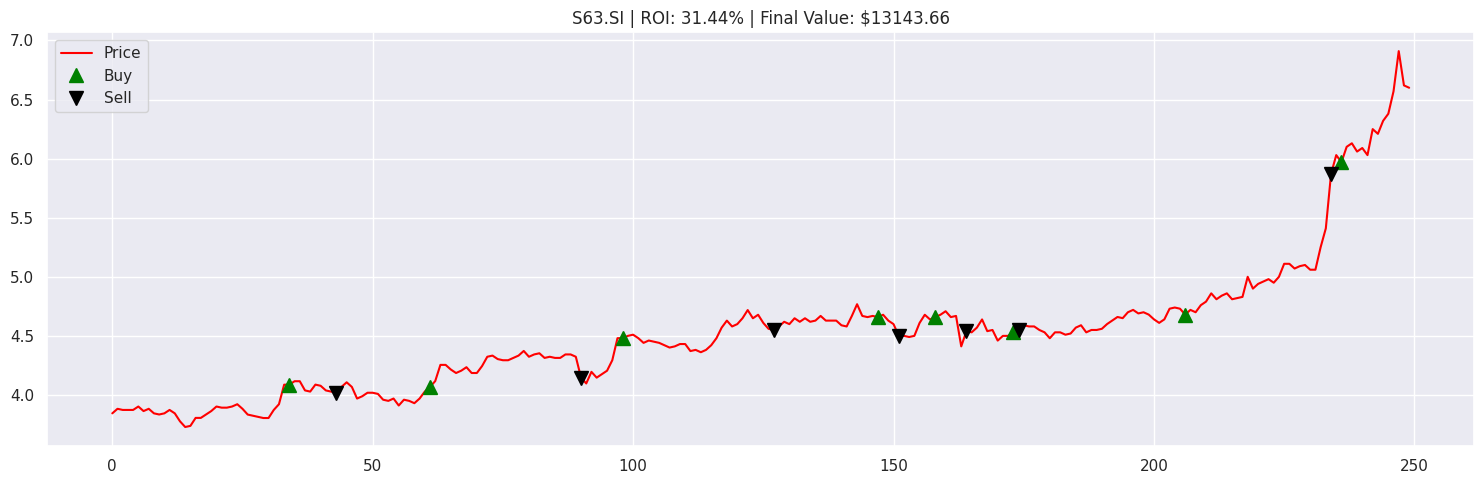


Processing AJBU.SI...


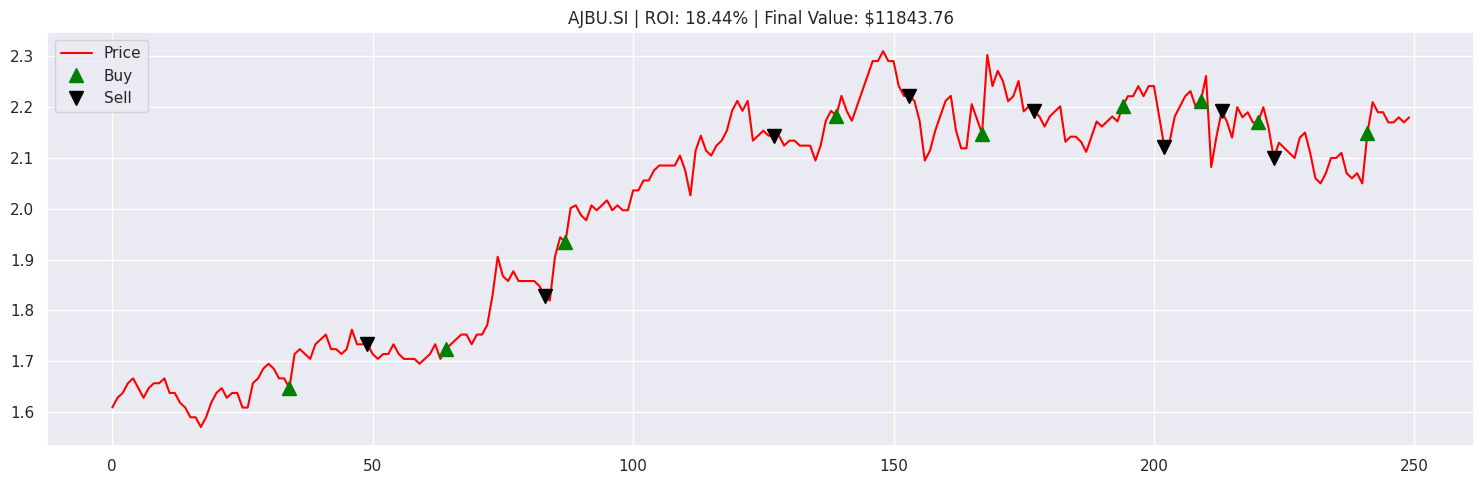


Portfolio Summary:
               ROI   Final Value
U11.SI    8.515397  10851.539650
C38U.SI  16.580393  11658.039276
Q0F.SI   12.312329  11231.232937
S68.SI   37.437457  13743.745668
S63.SI   31.436639  13143.663914
AJBU.SI  18.437579  11843.757931


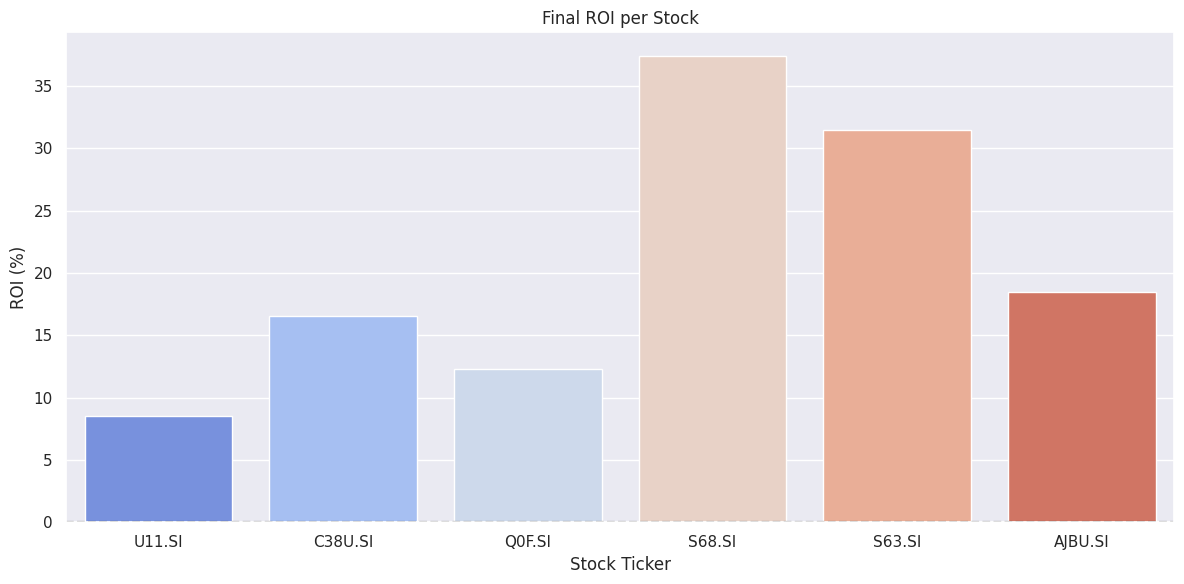

In [3]:
# ✅ Further Enhanced: Long-Term RL Strategy with Adaptive Signal Blending, Trend Confirmation & Dynamic Scaling

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import random

sns.set()

# Parameters
initial_money = 10000
window_size = 30
commission = 0.001
alpha_threshold = 0.004  # Adaptive MACD sensitivity
beta_threshold = -0.004
risk_rsi_low = 30
risk_rsi_high = 70
min_trade_profit = 0.002
volatility_buffer = 0.008
trend_confirm_window = 10
macd_weight = 0.5
rsi_weight = 0.3
trend_weight = 0.2


def RMA(series, period):
    rma = [series[0]]
    alpha = 1 / period
    for price in series[1:]:
        rma.append((1 - alpha) * rma[-1] + alpha * price)
    return np.array(rma)


def apply_second_order_rma(prices):
    return RMA(RMA(prices, 25), 9)


def compute_macd(prices, short=12, long=26, signal=9):
    ema_short = pd.Series(prices).ewm(span=short).mean()
    ema_long = pd.Series(prices).ewm(span=long).mean()
    macd_line = ema_short - ema_long
    signal_line = macd_line.ewm(span=signal).mean()
    return macd_line.values, signal_line.values


def compute_rsi(prices, period=14):
    delta = np.diff(prices)
    up = np.where(delta > 0, delta, 0)
    down = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(up).rolling(window=period).mean()
    avg_loss = pd.Series(down).rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return np.concatenate([np.full(period, np.nan), rsi[period:]])


def compute_volatility(prices):
    returns = np.diff(prices) / prices[:-1]
    return np.std(returns[-10:])


def is_uptrend(prices):
    trend = np.polyfit(range(len(prices)), prices, 1)[0]
    return trend > 0


class Actor(tf.keras.Model):
    def __init__(self, input_size, output_size, size_layer):
        super(Actor, self).__init__()
        self.lstm = tf.keras.layers.LSTM(size_layer, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(output_size)

    def call(self, inputs, hidden_state):
        rnn_output, h, c = self.lstm(inputs, initial_state=hidden_state)
        logits = self.dense(rnn_output[:, -1])
        return logits, (h, c)


class Critic(tf.keras.Model):
    def __init__(self, input_size, size_layer):
        super(Critic, self).__init__()
        self.lstm = tf.keras.layers.LSTM(size_layer, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(1)

    def call(self, inputs, hidden_state):
        rnn_output, h, c = self.lstm(inputs, initial_state=hidden_state)
        value = self.dense(rnn_output[:, -1])
        return value, (h, c)


class A2CAgent:
    def __init__(self, state_size, action_size, size_layer=256):
        self.state_size = state_size
        self.action_size = action_size
        self.size_layer = size_layer
        self.actor = Actor(state_size, action_size, size_layer)
        self.critic = Critic(state_size, size_layer)
        self.actor_optimizer = tf.keras.optimizers.Adam(0.001)
        self.critic_optimizer = tf.keras.optimizers.Adam(0.001)
        self.memory = deque(maxlen=1000)

    def get_state(self, t, trend):
        d = t - window_size + 1
        block = trend[d:t+1] if d >= 0 else -d * [trend[0]] + trend[0:t+1]
        delta = [block[i+1] - block[i] for i in range(window_size - 1)]
        rma2 = apply_second_order_rma(block)[-1]
        macd_line, signal_line = compute_macd(block)
        rsi = compute_rsi(block)
        macd_diff = macd_line[-1] - signal_line[-1] if len(macd_line) else 0
        rsi_val = rsi[-1] if not np.isnan(rsi[-1]) else 50
        return np.array(delta + [rma2, macd_diff, rsi_val])

    def get_action(self, state):
        state = np.array(state).reshape(1, self.state_size, 1)
        hidden = [tf.zeros((1, self.size_layer)), tf.zeros((1, self.size_layer))]
        logits, _ = self.actor(state, hidden)
        return tf.argmax(logits[0]).numpy()


portfolio_results = {}
# tickers = {"Q0F.SI", "C6L.SI", "C38U.SI", "9CI.SI", "C07.SI", "G13.SI", "O39.SI", "S68.SI", "G07.SI"}
tickers ={
    "U11.SI": "UOB Bank",
    "C38U.SI": "CapitaLand Integrated Commercial Trust",
    "Q0F.SI": "IHH Healthcare",
    "S68.SI": "SGX",
    "S63.SI": "ST Engineering",
    "AJBU.SI": "Keppel DC REIT"
}

for ticker in tickers:
    print(f"\nProcessing {ticker}...")
    df = pd.read_csv(f"/home/priya/Desktop/fyp/Agents/data_store/{ticker}.csv")
    close = df['Close'].values.tolist()
    if len(close) < window_size + 20:
        print(f"Skipping {ticker} due to insufficient data.")
        continue

    agent = A2CAgent(window_size - 1 + 3, 3)
    portfolio = initial_money
    shares_held = 0
    states_buy, states_sell = [], []

    for t in range(window_size, len(close) - 1):
        state = agent.get_state(t, close)
        macd_line, signal_line = compute_macd(close[max(0, t-50):t+1])
        macd_diff = macd_line[-1] - signal_line[-1] if len(macd_line) else 0
        rsi = compute_rsi(close[max(0, t-50):t+1])
        rsi_val = rsi[-1] if not np.isnan(rsi[-1]) else 50
        vol = compute_volatility(close[max(0, t-20):t+1])
        trend_score = 1 if is_uptrend(close[max(0, t-trend_confirm_window):t+1]) else -1

        weighted_signal = macd_weight * macd_diff + rsi_weight * ((50 - rsi_val) / 50) + trend_weight * trend_score
        current_price = close[t]
        expected_profit = close[t+1] * (1 - commission) - current_price * (1 + commission)

        action = 0
        if weighted_signal > alpha_threshold and expected_profit > min_trade_profit * current_price and vol > volatility_buffer:
            action = 1
        elif weighted_signal < beta_threshold and shares_held > 0 and vol > volatility_buffer:
            action = 2

        if action == 1 and portfolio >= current_price * (1 + commission):
            shares_to_buy = portfolio // (current_price * (1 + commission))
            portfolio -= shares_to_buy * current_price * (1 + commission)
            shares_held += shares_to_buy
            states_buy.append(t)

        elif action == 2 and shares_held > 0:
            portfolio += shares_held * current_price * (1 - commission)
            shares_held = 0
            states_sell.append(t)

    portfolio_value = portfolio + shares_held * close[-1]
    roi = (portfolio_value - initial_money) / initial_money * 100
    portfolio_results[ticker] = {"ROI": roi, "Final Value": portfolio_value}

    plt.figure(figsize=(15, 5))
    plt.plot(close, label='Price', color='red')
    plt.plot(close, '^', markersize=10, color='green', label='Buy', markevery=states_buy)
    plt.plot(close, 'v', markersize=10, color='black', label='Sell', markevery=states_sell)
    plt.title(f"{ticker} | ROI: {roi:.2f}% | Final Value: ${portfolio_value:.2f}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

results_df = pd.DataFrame(portfolio_results).T
print("\nPortfolio Summary:")
print(results_df)
results_df.to_csv('results_actorcritic.csv')

plt.figure(figsize=(12, 6))
sns.barplot(x=results_df.index, y=results_df["ROI"], hue=results_df.index, dodge=False, palette="coolwarm", legend=False)
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Final ROI per Stock")
plt.ylabel("ROI (%)")
plt.xlabel("Stock Ticker")
plt.tight_layout()
plt.show()


Processing U11.SI...


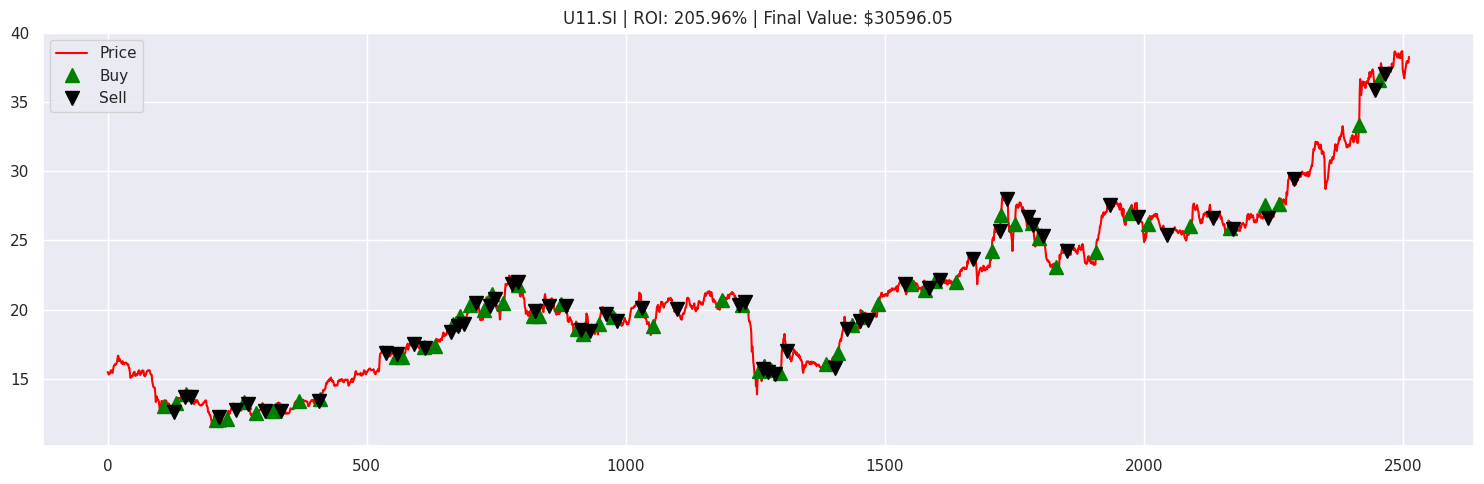


Processing C38U.SI...


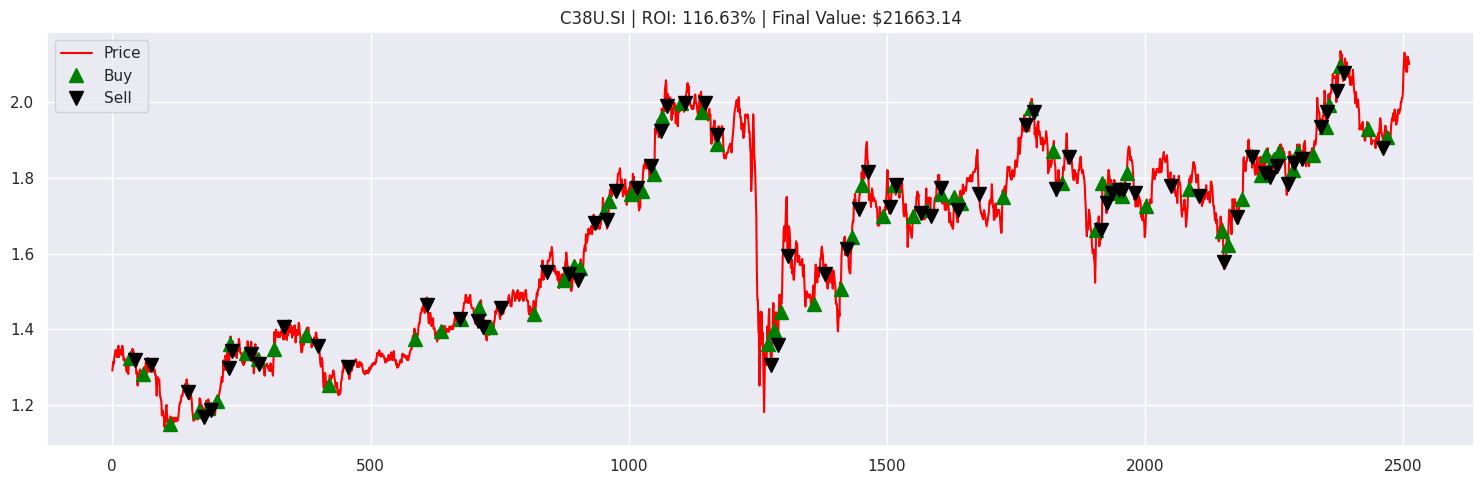


Processing Q0F.SI...


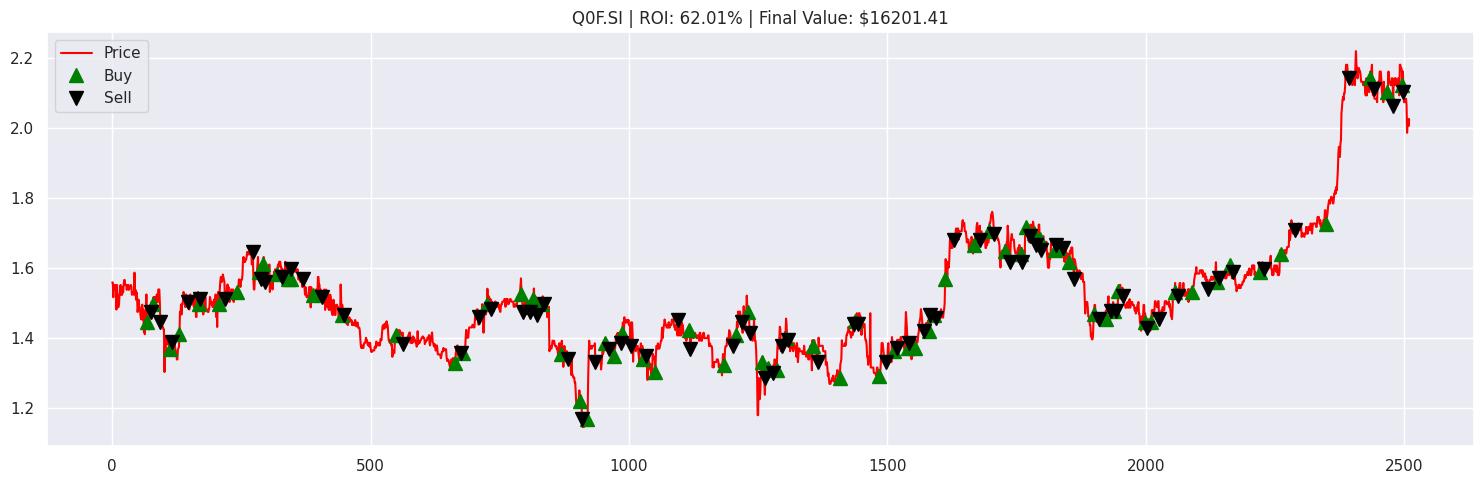


Processing S68.SI...


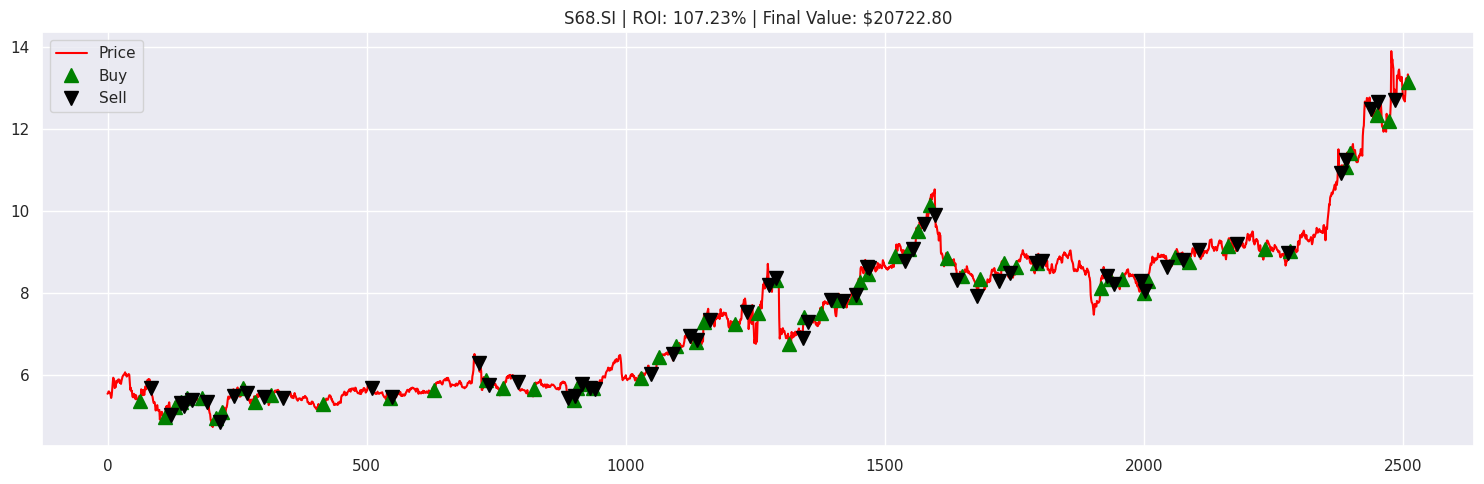


Processing S63.SI...


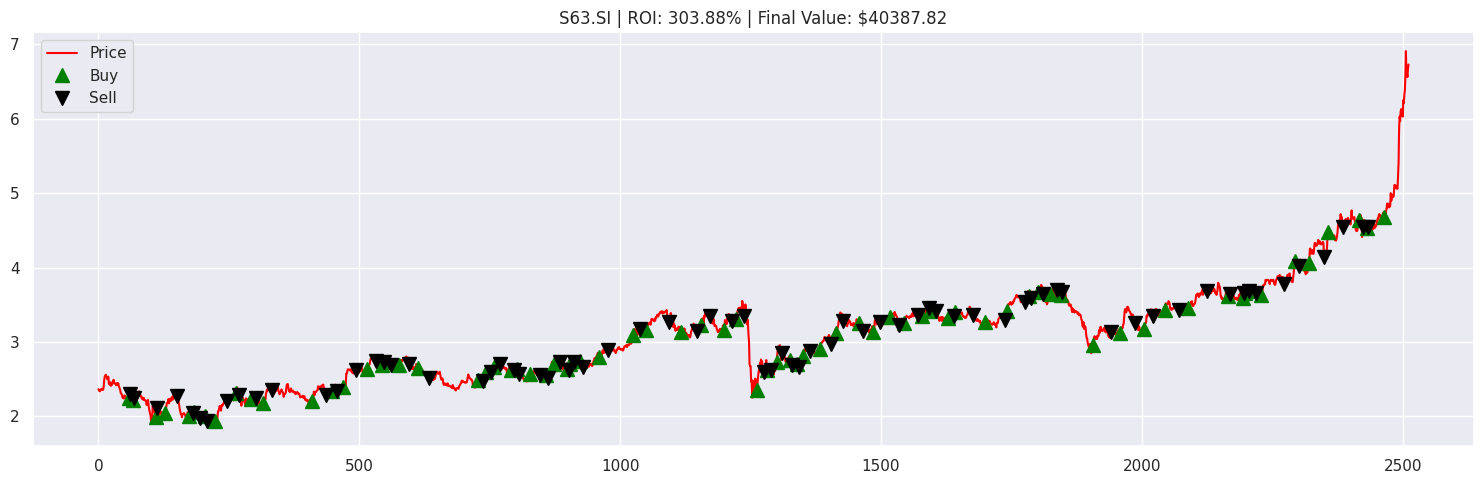


Processing AJBU.SI...


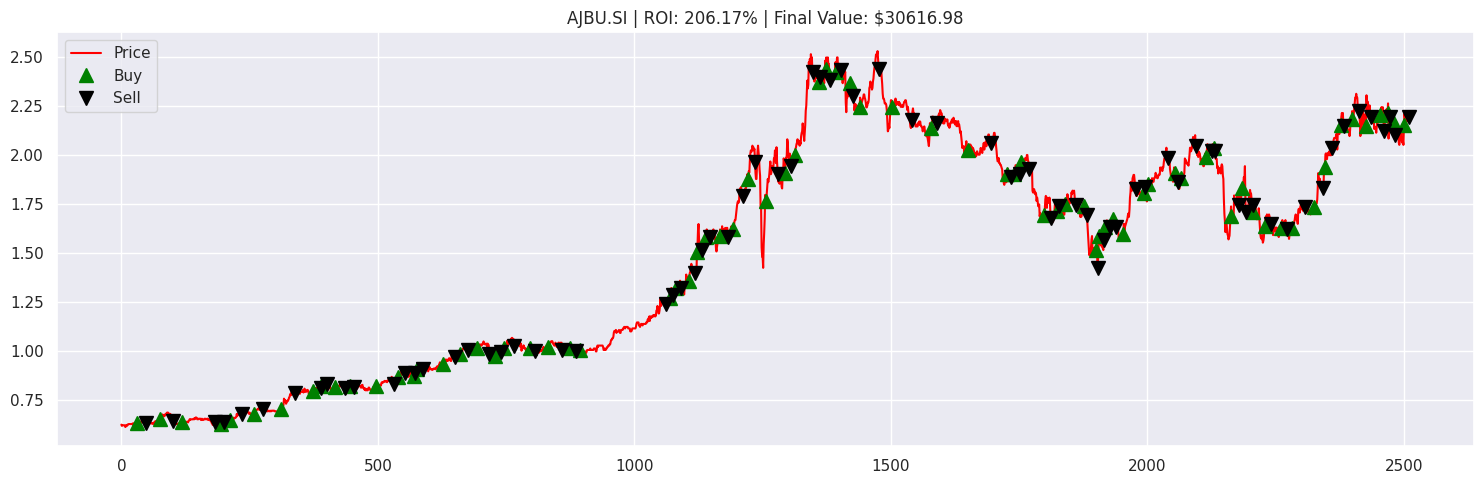


Portfolio Summary:
                ROI   Final Value
U11.SI   205.960461  30596.046145
C38U.SI  116.631359  21663.135900
Q0F.SI    62.014149  16201.414920
S68.SI   107.227957  20722.795700
S63.SI   303.878187  40387.818725
AJBU.SI  206.169797  30616.979743


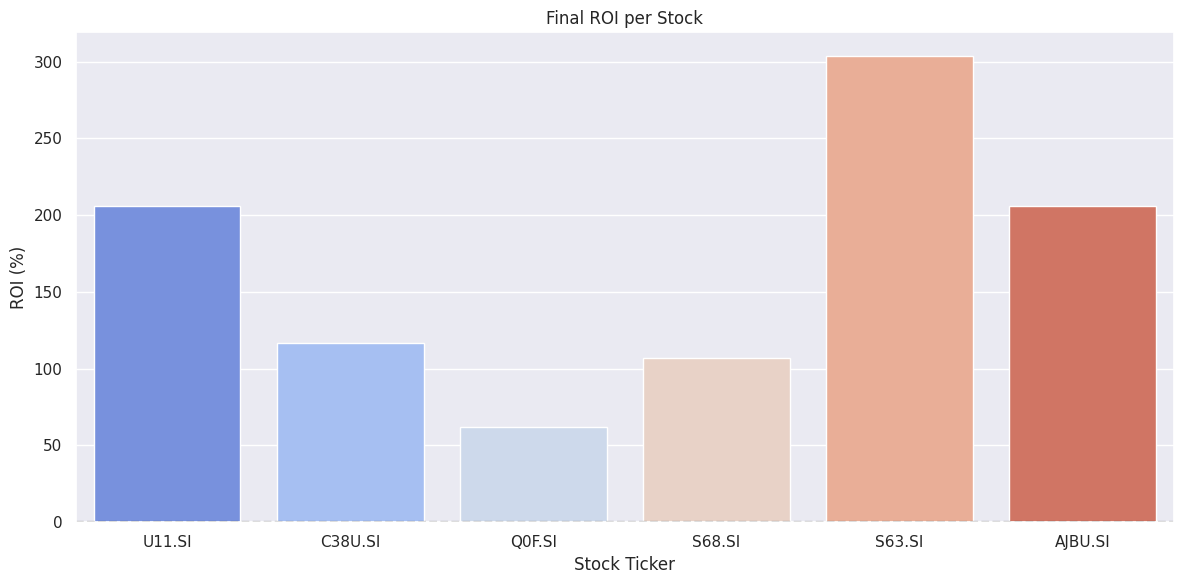

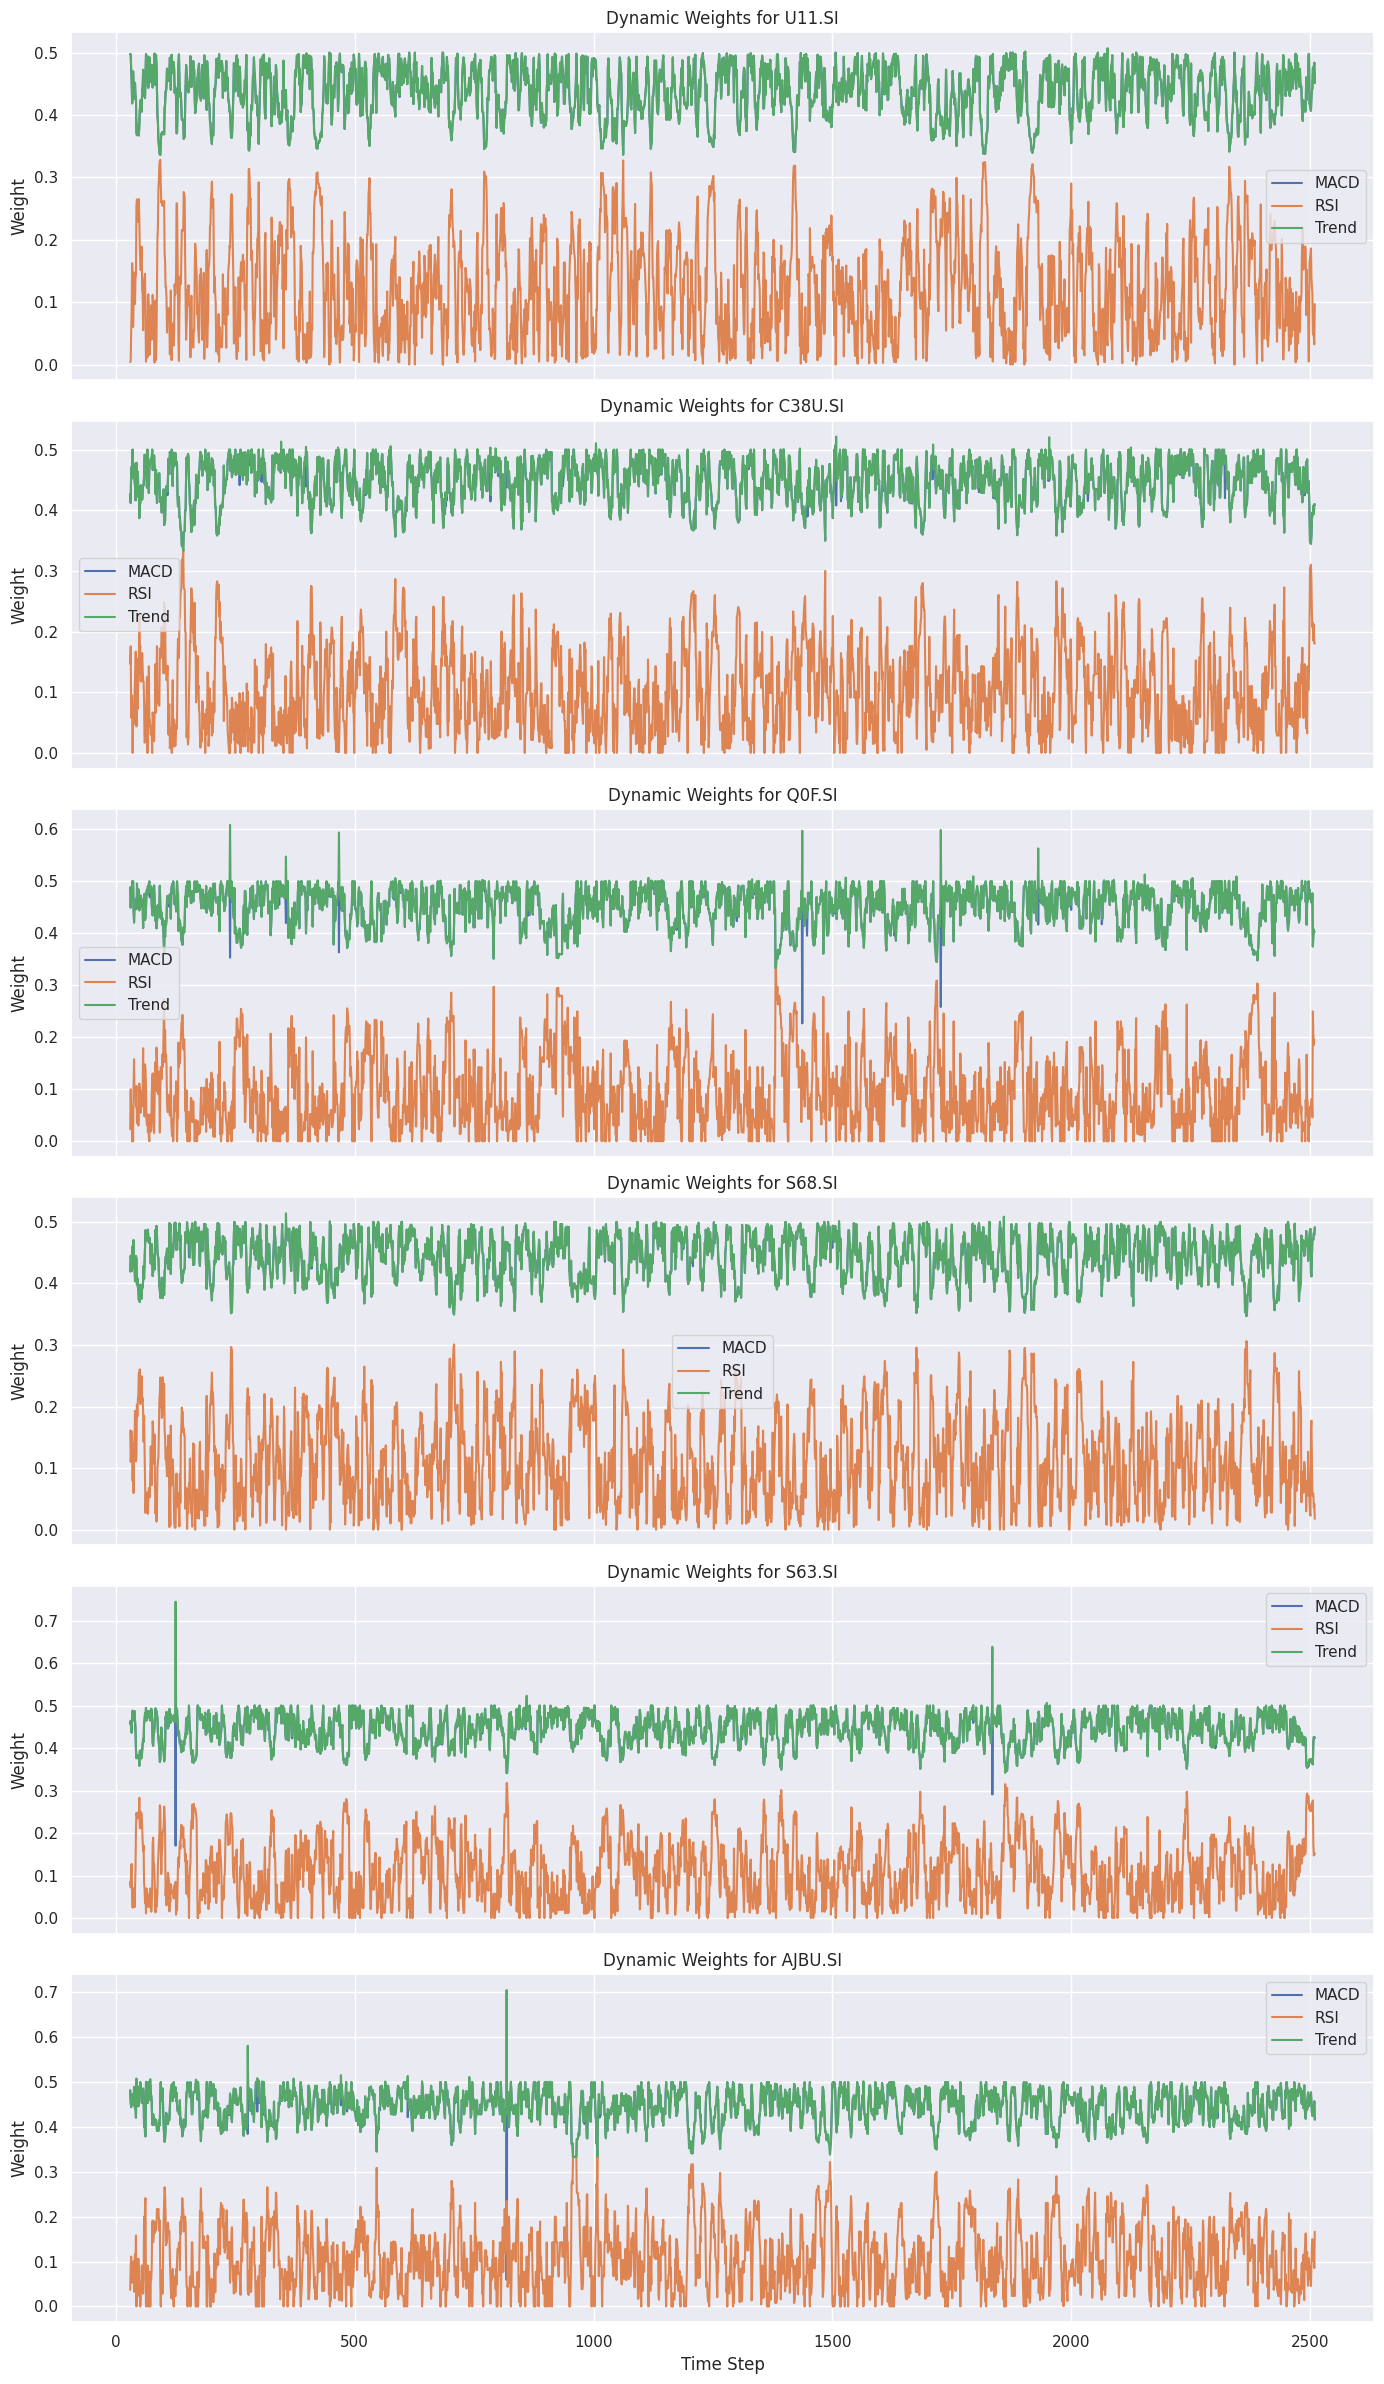

In [3]:
# ✅ Further Enhanced: Long-Term RL Strategy with Adaptive Signal Blending, Trend Confirmation & Dynamic Scaling

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import random

sns.set()

# Parameters
initial_money = 10000
window_size = 30
commission = 0.001
alpha_threshold = 0.004
beta_threshold = -0.004
min_trade_profit = 0.002
volatility_buffer = 0.008
trend_confirm_window = 10

# Result containers
portfolio_results = {}
dynamic_weights_log = {}

# Ticker info
tickers = {
    "U11.SI": "UOB Bank",
    "C38U.SI": "CapitaLand Integrated Commercial Trust",
    "Q0F.SI": "IHH Healthcare",
    "S68.SI": "SGX",
    "S63.SI": "ST Engineering",
    "AJBU.SI": "Keppel DC REIT"
}

# Functions for technical indicators
def RMA(series, period):
    rma = [series[0]]
    alpha = 1 / period
    for price in series[1:]:
        rma.append((1 - alpha) * rma[-1] + alpha * price)
    return np.array(rma)

def apply_second_order_rma(prices):
    return RMA(RMA(prices, 25), 9)

def compute_macd(prices, short=12, long=26, signal=9):
    ema_short = pd.Series(prices).ewm(span=short).mean()
    ema_long = pd.Series(prices).ewm(span=long).mean()
    macd_line = ema_short - ema_long
    signal_line = macd_line.ewm(span=signal).mean()
    return macd_line.values, signal_line.values

def compute_rsi(prices, period=14):
    delta = np.diff(prices)
    up = np.where(delta > 0, delta, 0)
    down = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(up).rolling(window=period).mean()
    avg_loss = pd.Series(down).rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return np.concatenate([np.full(period, np.nan), rsi[period:]])

def compute_volatility(prices):
    returns = np.diff(prices) / prices[:-1]
    return np.std(returns[-10:])

def is_uptrend(prices):
    trend = np.polyfit(range(len(prices)), prices, 1)[0]
    return trend > 0

# A2C components
class Actor(tf.keras.Model):
    def __init__(self, input_size, output_size, size_layer):
        super(Actor, self).__init__()
        self.lstm = tf.keras.layers.LSTM(size_layer, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(output_size)

    def call(self, inputs, hidden_state):
        rnn_output, h, c = self.lstm(inputs, initial_state=hidden_state)
        logits = self.dense(rnn_output[:, -1])
        return logits, (h, c)

class Critic(tf.keras.Model):
    def __init__(self, input_size, size_layer):
        super(Critic, self).__init__()
        self.lstm = tf.keras.layers.LSTM(size_layer, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(1)

    def call(self, inputs, hidden_state):
        rnn_output, h, c = self.lstm(inputs, initial_state=hidden_state)
        value = self.dense(rnn_output[:, -1])
        return value, (h, c)

class A2CAgent:
    def __init__(self, state_size, action_size, size_layer=256):
        self.state_size = state_size
        self.action_size = action_size
        self.size_layer = size_layer
        self.actor = Actor(state_size, action_size, size_layer)
        self.critic = Critic(state_size, size_layer)
        self.actor_optimizer = tf.keras.optimizers.Adam(0.001)
        self.critic_optimizer = tf.keras.optimizers.Adam(0.001)
        self.memory = deque(maxlen=1000)

    def get_state(self, t, trend):
        d = t - window_size + 1
        block = trend[d:t+1] if d >= 0 else -d * [trend[0]] + trend[0:t+1]
        delta = [block[i+1] - block[i] for i in range(window_size - 1)]
        rma2 = apply_second_order_rma(block)[-1]
        macd_line, signal_line = compute_macd(block)
        rsi = compute_rsi(block)
        macd_diff = macd_line[-1] - signal_line[-1] if len(macd_line) else 0
        rsi_val = rsi[-1] if not np.isnan(rsi[-1]) else 50
        return np.array(delta + [rma2, macd_diff, rsi_val])

    def get_action(self, state):
        state = np.array(state).reshape(1, self.state_size, 1)
        hidden = [tf.zeros((1, self.size_layer)), tf.zeros((1, self.size_layer))]
        logits, _ = self.actor(state, hidden)
        return tf.argmax(logits[0]).numpy()

# Run simulation
for ticker in tickers:
    print(f"\nProcessing {ticker}...")
    df = pd.read_csv(f"/home/priya/Desktop/fyp/Agents/data_store/{ticker}.csv")
    close = df['Close'].dropna().values.tolist()
    if len(close) < window_size + 20:
        print(f"Skipping {ticker} due to insufficient data.")
        continue

    dynamic_weights_log[ticker] = {'time': [], 'macd_weight': [], 'rsi_weight': [], 'trend_weight': []}

    agent = A2CAgent(window_size - 1 + 3, 3)
    portfolio = initial_money
    shares_held = 0
    states_buy, states_sell = [], []

    for t in range(window_size, len(close) - 1):
        state = agent.get_state(t, close)
        macd_line, signal_line = compute_macd(close[max(0, t-50):t+1])
        macd_diff = macd_line[-1] - signal_line[-1] if len(macd_line) else 0
        rsi = compute_rsi(close[max(0, t-50):t+1])
        rsi_val = rsi[-1] if not np.isnan(rsi[-1]) else 50
        vol = compute_volatility(close[max(0, t-20):t+1])
        trend_score = 1 if is_uptrend(close[max(0, t-trend_confirm_window):t+1]) else -1

        macd_score = macd_diff / (abs(macd_diff) + 1e-6)
        rsi_score = ((50 - rsi_val) / 50)
        trend_score_norm = trend_score

        total_signal_strength = abs(macd_score) + abs(rsi_score) + abs(trend_score_norm)
        w_macd = abs(macd_score) / total_signal_strength
        w_rsi = abs(rsi_score) / total_signal_strength
        w_trend = abs(trend_score_norm) / total_signal_strength

        weighted_signal = w_macd * macd_score + w_rsi * rsi_score + w_trend * trend_score_norm

        dynamic_weights_log[ticker]['time'].append(t)
        dynamic_weights_log[ticker]['macd_weight'].append(w_macd)
        dynamic_weights_log[ticker]['rsi_weight'].append(w_rsi)
        dynamic_weights_log[ticker]['trend_weight'].append(w_trend)

        current_price = close[t]
        expected_profit = close[t+1] * (1 - commission) - current_price * (1 + commission)

        action = 0
        if weighted_signal > alpha_threshold and expected_profit > min_trade_profit * current_price and vol > volatility_buffer:
            action = 1
        elif weighted_signal < beta_threshold and shares_held > 0 and vol > volatility_buffer:
            action = 2

        if action == 1 and portfolio >= current_price * (1 + commission):
            shares_to_buy = portfolio // (current_price * (1 + commission))
            portfolio -= shares_to_buy * current_price * (1 + commission)
            shares_held += shares_to_buy
            states_buy.append(t)

        elif action == 2 and shares_held > 0:
            portfolio += shares_held * current_price * (1 - commission)
            shares_held = 0
            states_sell.append(t)

    portfolio_value = portfolio + shares_held * close[-1]
    roi = (portfolio_value - initial_money) / initial_money * 100
    portfolio_results[ticker] = {"ROI": roi, "Final Value": portfolio_value}
        # Save Buy/Sell Dates as CSV
    dates = df.index.tolist()
    buy_dates = [dates[i] for i in states_buy]
    sell_dates = [dates[i] for i in states_sell]

    buy_df = pd.DataFrame({'Buy_Dates': buy_dates})
    sell_df = pd.DataFrame({'Sell_Dates': sell_dates})

    buy_df.to_csv(f'buy_dates_{ticker}.csv', index=False)
    sell_df.to_csv(f'sell_dates_{ticker}.csv', index=False)

    plt.figure(figsize=(15, 5))
    plt.plot(close, label='Price', color='red')
    plt.plot(close, '^', markersize=10, color='green', label='Buy', markevery=states_buy)
    plt.plot(close, 'v', markersize=10, color='black', label='Sell', markevery=states_sell)
    plt.title(f"{ticker} | ROI: {roi:.2f}% | Final Value: ${portfolio_value:.2f}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Summary
results_df = pd.DataFrame(portfolio_results).T
print("\nPortfolio Summary:")
print(results_df)
results_df.to_csv('results_actorcritic.csv')

plt.figure(figsize=(12, 6))
sns.barplot(x=results_df.index, y=results_df["ROI"], hue=results_df.index, dodge=False, palette="coolwarm", legend=False)
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Final ROI per Stock")
plt.ylabel("ROI (%)")
plt.xlabel("Stock Ticker")
plt.tight_layout()
plt.show()

# Plot dynamic weights for each stock
total_steps = max(len(log['time']) for log in dynamic_weights_log.values())
fig, axs = plt.subplots(len(dynamic_weights_log), 1, figsize=(14, 4 * len(dynamic_weights_log)), sharex=True)
for i, (ticker, log) in enumerate(dynamic_weights_log.items()):
    axs[i].plot(log['time'], log['macd_weight'], label='MACD')
    axs[i].plot(log['time'], log['rsi_weight'], label='RSI')
    axs[i].plot(log['time'], log['trend_weight'], label='Trend')
    axs[i].set_title(f"Dynamic Weights for {ticker}")
    axs[i].set_ylabel("Weight")
    axs[i].legend()
    axs[i].grid(True)
axs[-1].set_xlabel("Time Step")
plt.tight_layout()
plt.show()



Processing U11.SI...


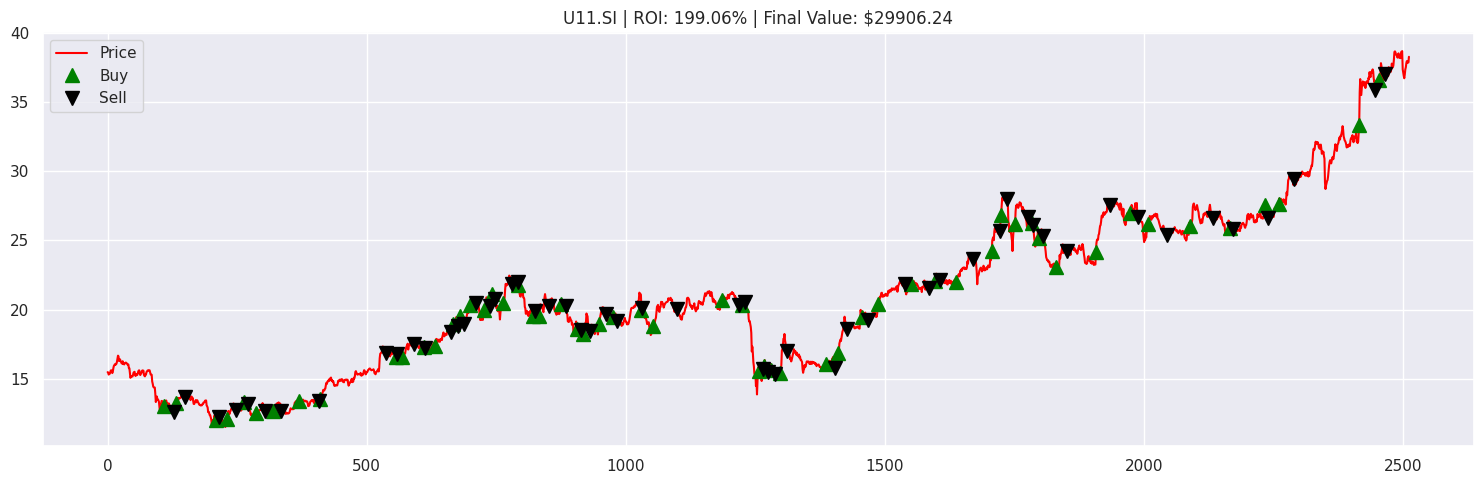


Processing C38U.SI...


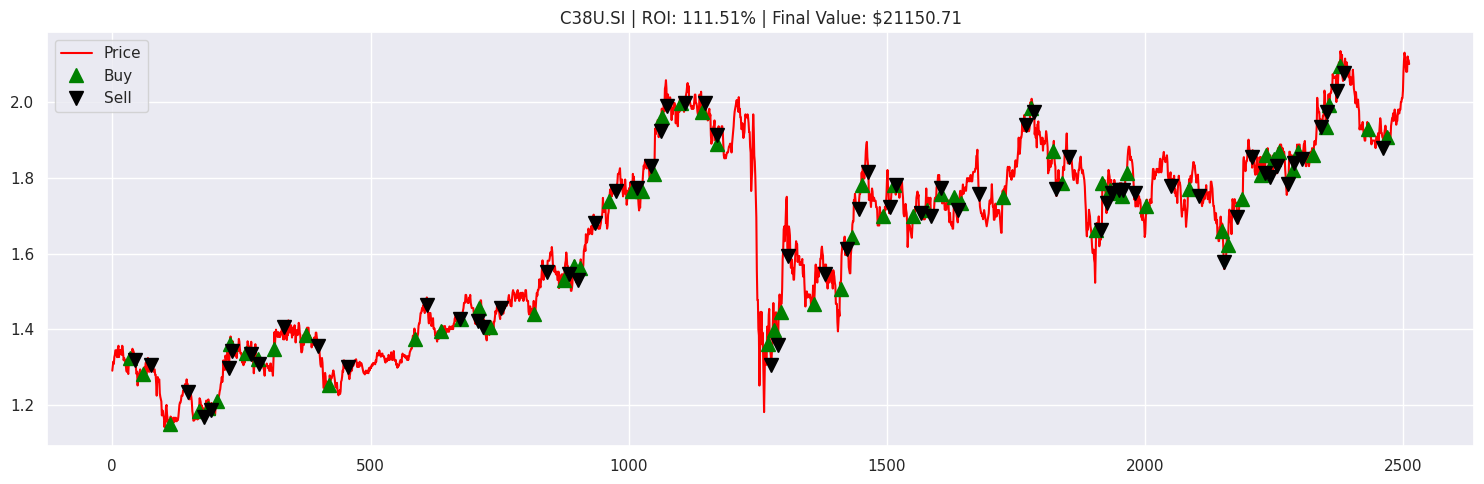


Processing Q0F.SI...


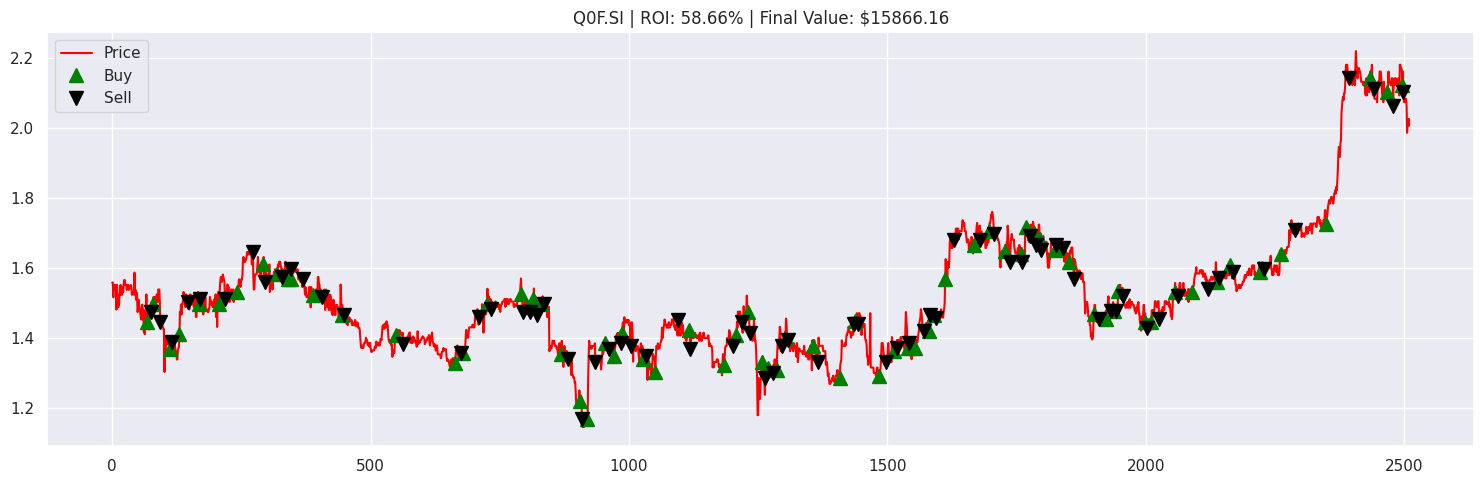


Processing S68.SI...


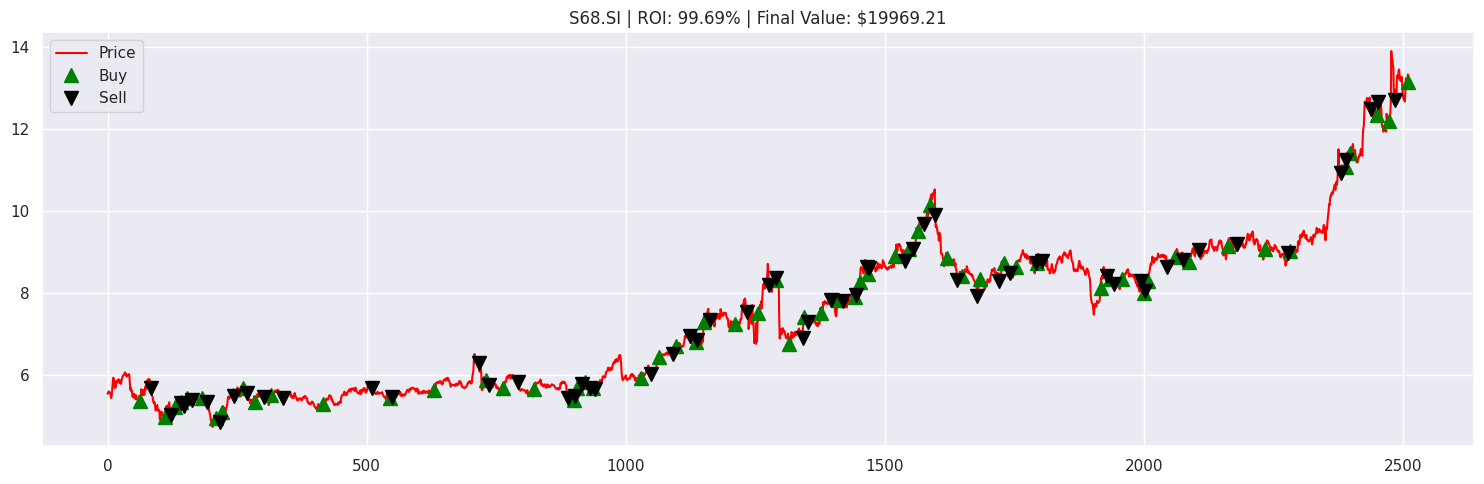


Processing S63.SI...


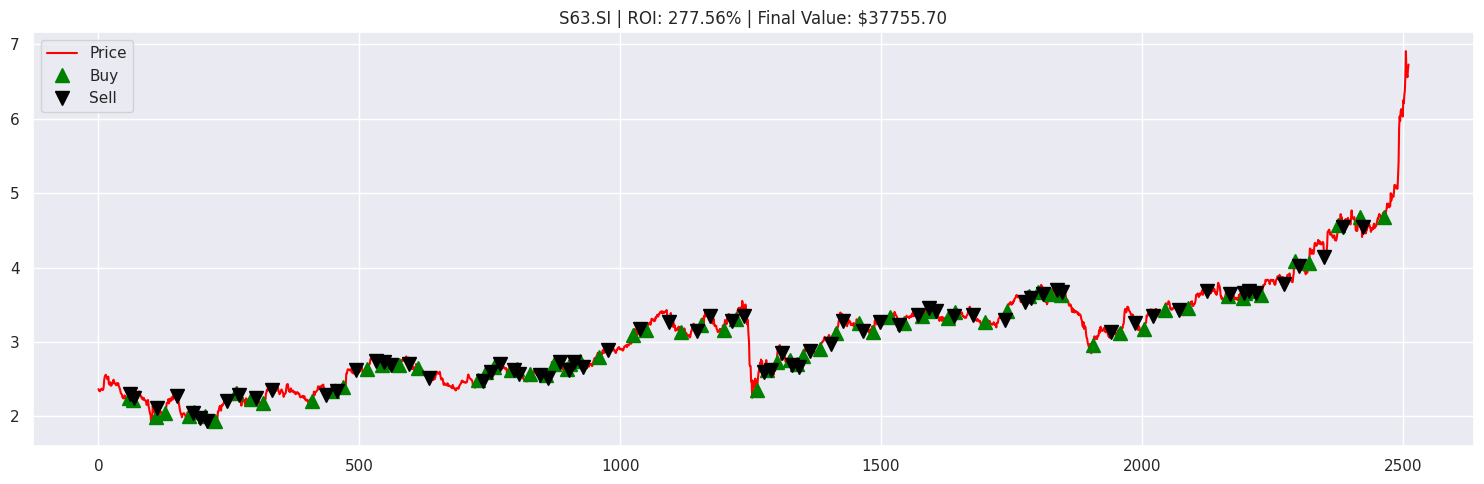


Processing AJBU.SI...


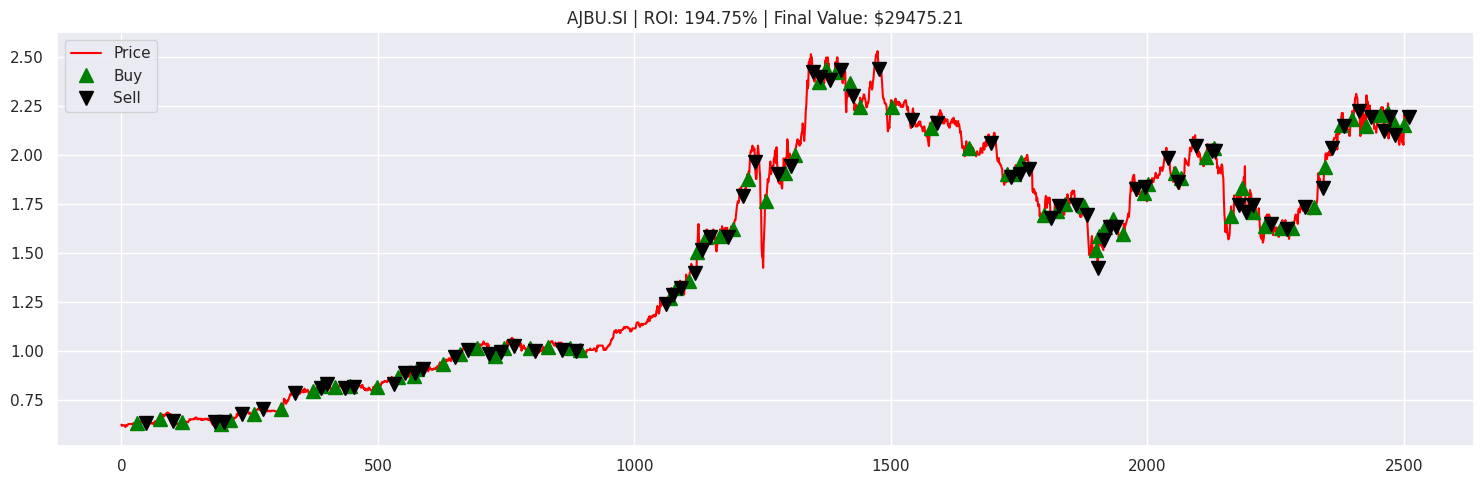


Portfolio Summary:
                ROI   Final Value
U11.SI   199.062413  29906.241324
C38U.SI  111.507097  21150.709722
Q0F.SI    58.661638  15866.163784
S68.SI    99.692092  19969.209197
S63.SI   277.556989  37755.698909
AJBU.SI  194.752060  29475.206048


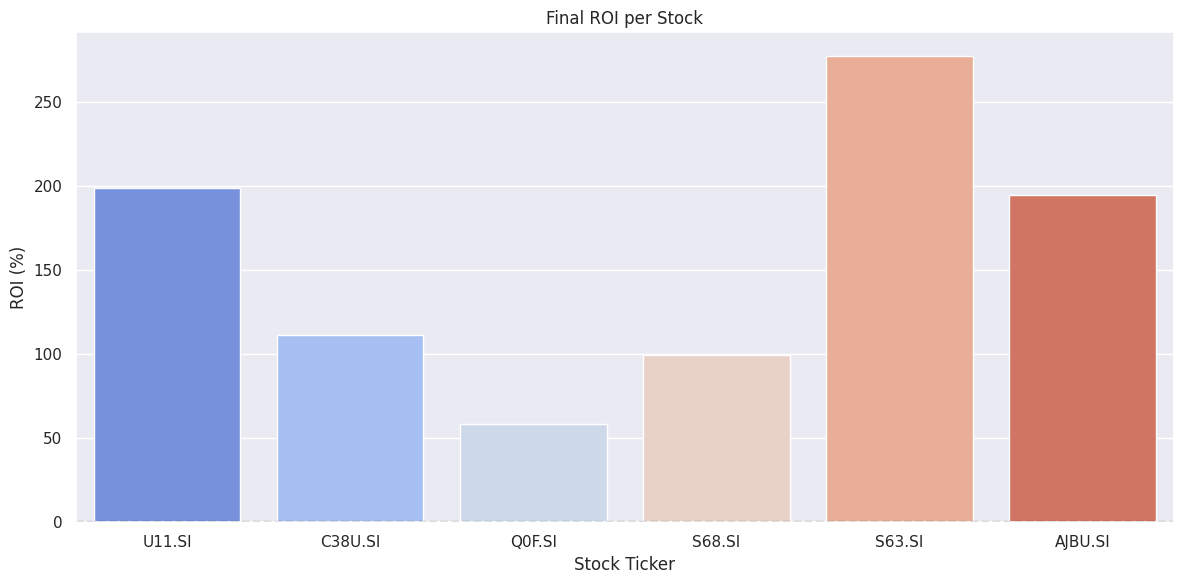

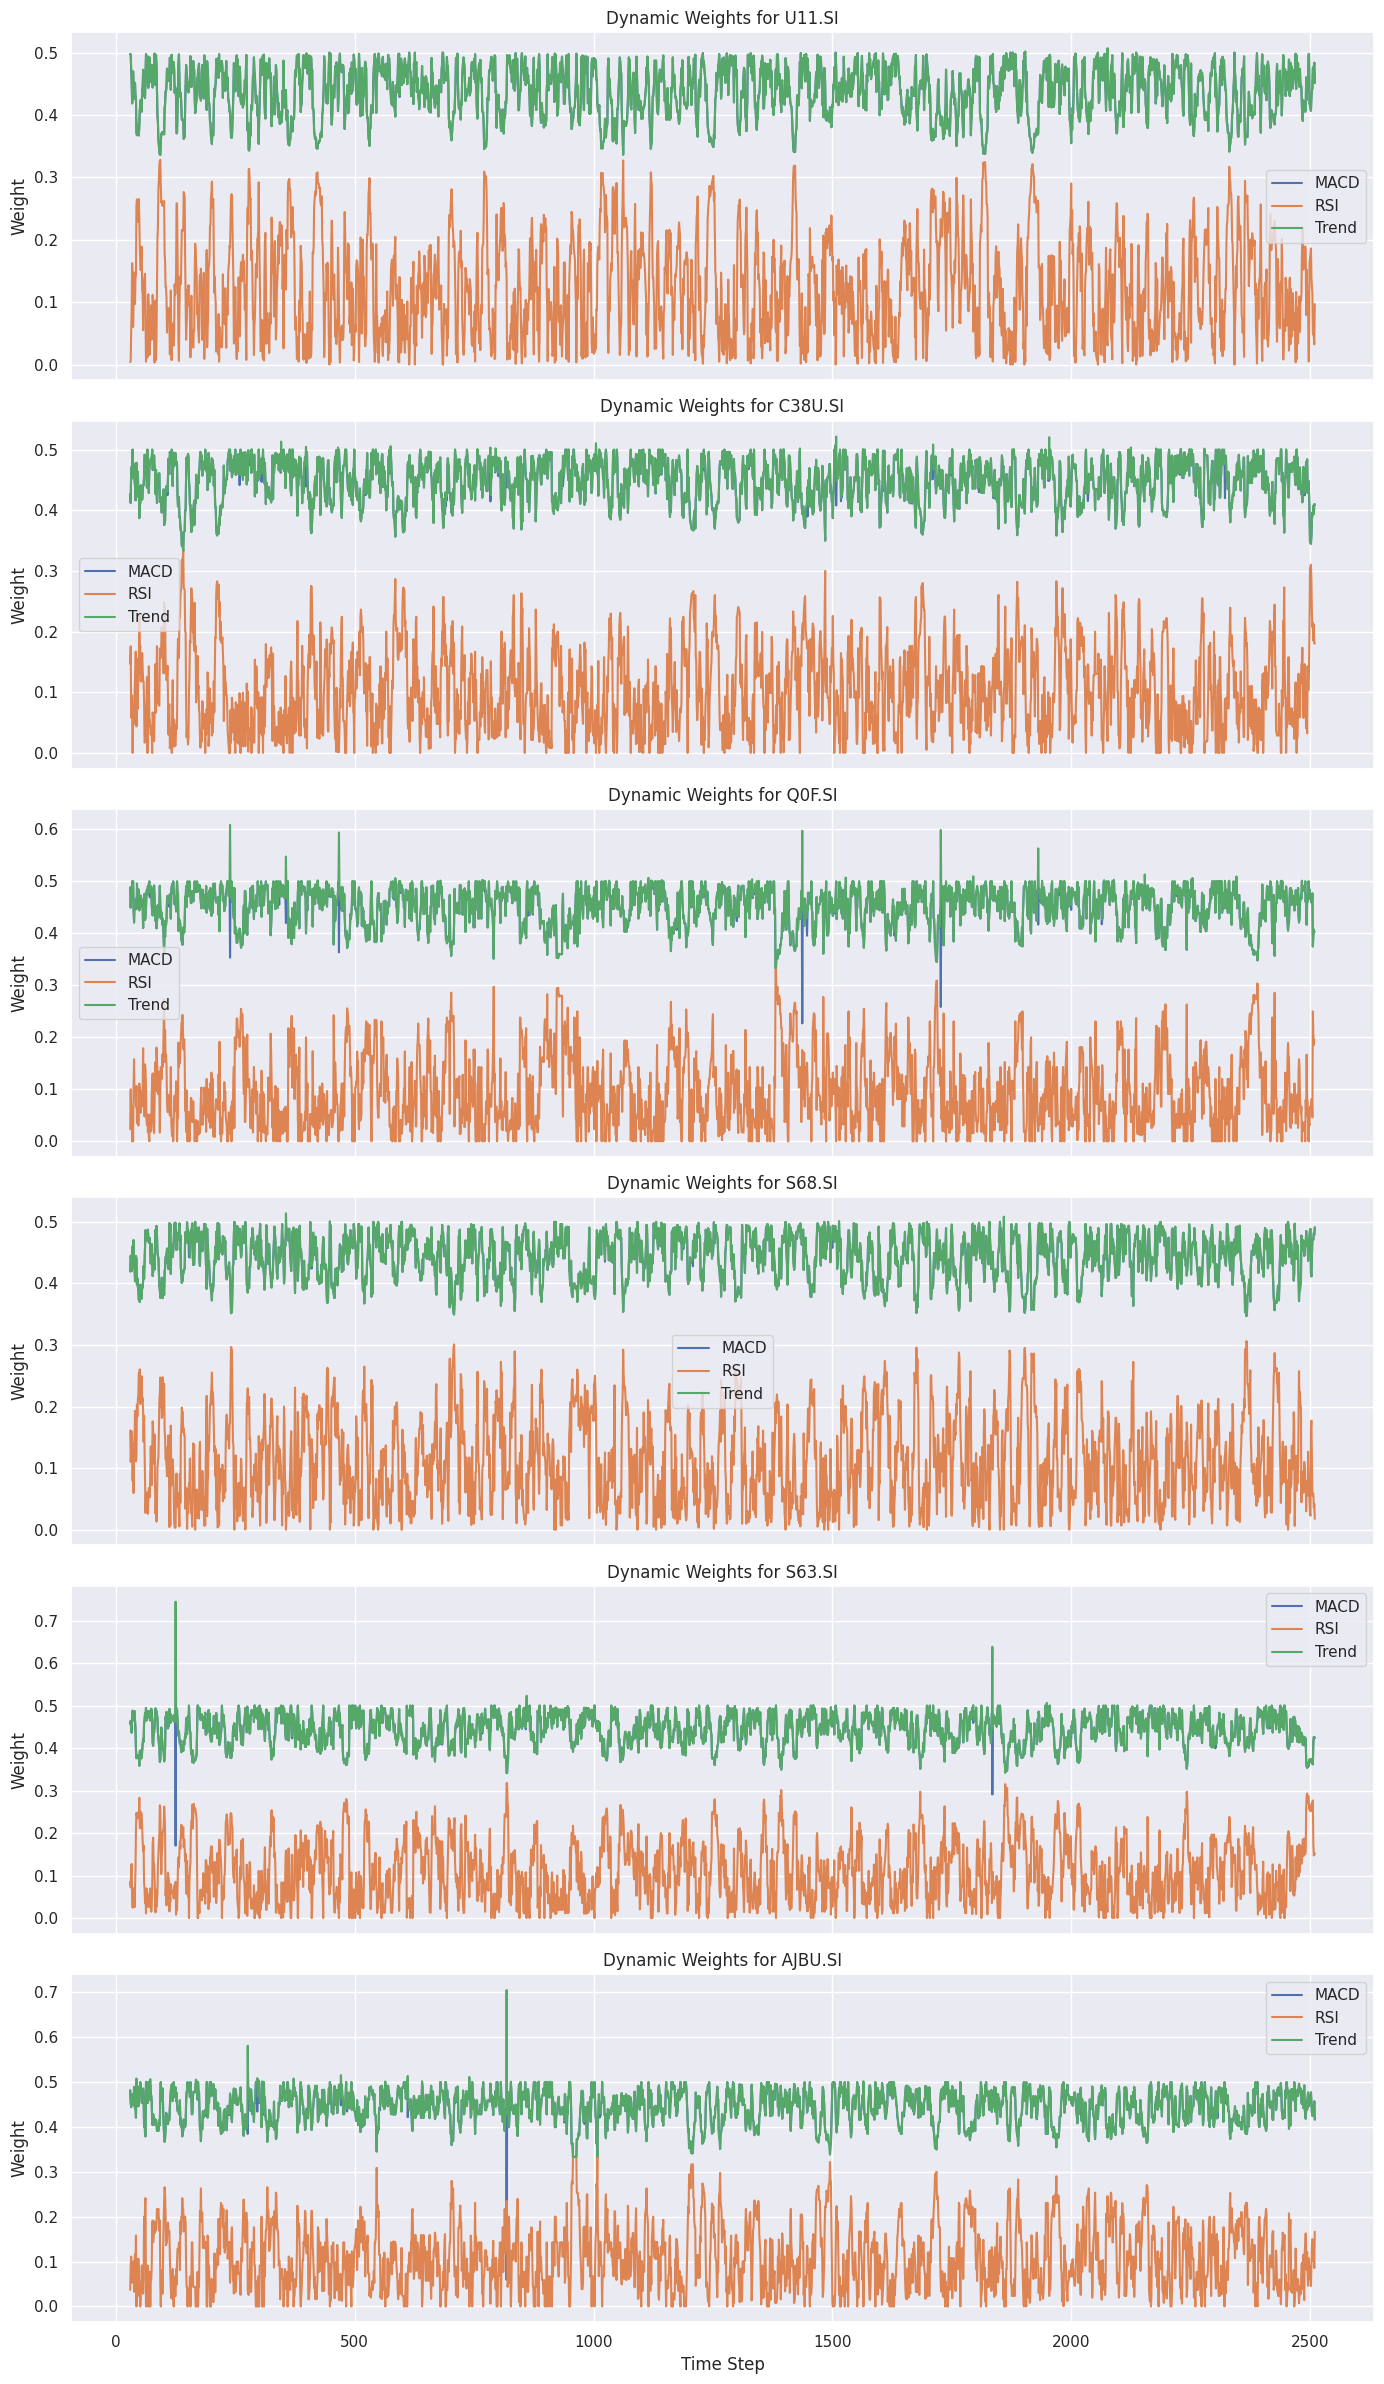

In [4]:
# ✅ Further Enhanced: Long-Term RL Strategy with Adaptive Signal Blending, Trend Confirmation & Dynamic Scaling

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import random

sns.set()

# Parameters
initial_money = 10000
window_size = 30
commission = 0.00125
alpha_threshold = 0.004
beta_threshold = -0.004
min_trade_profit = 0.002
volatility_buffer = 0.008
trend_confirm_window = 10

# Result containers
portfolio_results = {}
dynamic_weights_log = {}

# Ticker info
tickers = {
    "U11.SI": "UOB Bank",
    "C38U.SI": "CapitaLand Integrated Commercial Trust",
    "Q0F.SI": "IHH Healthcare",
    "S68.SI": "SGX",
    "S63.SI": "ST Engineering",
    "AJBU.SI": "Keppel DC REIT"
}

# Functions for technical indicators
def RMA(series, period):
    rma = [series[0]]
    alpha = 1 / period
    for price in series[1:]:
        rma.append((1 - alpha) * rma[-1] + alpha * price)
    return np.array(rma)

def apply_second_order_rma(prices):
    return RMA(RMA(prices, 25), 9)

def compute_macd(prices, short=12, long=26, signal=9):
    ema_short = pd.Series(prices).ewm(span=short).mean()
    ema_long = pd.Series(prices).ewm(span=long).mean()
    macd_line = ema_short - ema_long
    signal_line = macd_line.ewm(span=signal).mean()
    return macd_line.values, signal_line.values

def compute_rsi(prices, period=14):
    delta = np.diff(prices)
    up = np.where(delta > 0, delta, 0)
    down = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(up).rolling(window=period).mean()
    avg_loss = pd.Series(down).rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return np.concatenate([np.full(period, np.nan), rsi[period:]])

def compute_volatility(prices):
    returns = np.diff(prices) / prices[:-1]
    return np.std(returns[-10:])

def is_uptrend(prices):
    trend = np.polyfit(range(len(prices)), prices, 1)[0]
    return trend > 0

# A2C components
class Actor(tf.keras.Model):
    def __init__(self, input_size, output_size, size_layer):
        super(Actor, self).__init__()
        self.lstm = tf.keras.layers.LSTM(size_layer, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(output_size)

    def call(self, inputs, hidden_state):
        rnn_output, h, c = self.lstm(inputs, initial_state=hidden_state)
        logits = self.dense(rnn_output[:, -1])
        return logits, (h, c)

class Critic(tf.keras.Model):
    def __init__(self, input_size, size_layer):
        super(Critic, self).__init__()
        self.lstm = tf.keras.layers.LSTM(size_layer, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(1)

    def call(self, inputs, hidden_state):
        rnn_output, h, c = self.lstm(inputs, initial_state=hidden_state)
        value = self.dense(rnn_output[:, -1])
        return value, (h, c)

class A2CAgent:
    def __init__(self, state_size, action_size, size_layer=256):
        self.state_size = state_size
        self.action_size = action_size
        self.size_layer = size_layer
        self.actor = Actor(state_size, action_size, size_layer)
        self.critic = Critic(state_size, size_layer)
        self.actor_optimizer = tf.keras.optimizers.Adam(0.001)
        self.critic_optimizer = tf.keras.optimizers.Adam(0.001)
        self.memory = deque(maxlen=1000)

    def get_state(self, t, trend):
        d = t - window_size + 1
        block = trend[d:t+1] if d >= 0 else -d * [trend[0]] + trend[0:t+1]
        delta = [block[i+1] - block[i] for i in range(window_size - 1)]
        rma2 = apply_second_order_rma(block)[-1]
        macd_line, signal_line = compute_macd(block)
        rsi = compute_rsi(block)
        macd_diff = macd_line[-1] - signal_line[-1] if len(macd_line) else 0
        rsi_val = rsi[-1] if not np.isnan(rsi[-1]) else 50
        return np.array(delta + [rma2, macd_diff, rsi_val])

    def get_action(self, state):
        state = np.array(state).reshape(1, self.state_size, 1)
        hidden = [tf.zeros((1, self.size_layer)), tf.zeros((1, self.size_layer))]
        logits, _ = self.actor(state, hidden)
        return tf.argmax(logits[0]).numpy()

# Run simulation
for ticker in tickers:
    print(f"\nProcessing {ticker}...")
    df = pd.read_csv(f"/home/priya/Desktop/fyp/Agents/data_store/{ticker}.csv")
    close = df['Close'].dropna().values.tolist()
    if len(close) < window_size + 20:
        print(f"Skipping {ticker} due to insufficient data.")
        continue

    dynamic_weights_log[ticker] = {'time': [], 'macd_weight': [], 'rsi_weight': [], 'trend_weight': []}

    agent = A2CAgent(window_size - 1 + 3, 3)
    portfolio = initial_money
    shares_held = 0
    states_buy, states_sell = [], []

    for t in range(window_size, len(close) - 1):
        state = agent.get_state(t, close)
        macd_line, signal_line = compute_macd(close[max(0, t-50):t+1])
        macd_diff = macd_line[-1] - signal_line[-1] if len(macd_line) else 0
        rsi = compute_rsi(close[max(0, t-50):t+1])
        rsi_val = rsi[-1] if not np.isnan(rsi[-1]) else 50
        vol = compute_volatility(close[max(0, t-20):t+1])
        trend_score = 1 if is_uptrend(close[max(0, t-trend_confirm_window):t+1]) else -1

        macd_score = macd_diff / (abs(macd_diff) + 1e-6)
        rsi_score = ((50 - rsi_val) / 50)
        trend_score_norm = trend_score

        total_signal_strength = abs(macd_score) + abs(rsi_score) + abs(trend_score_norm)
        w_macd = abs(macd_score) / total_signal_strength
        w_rsi = abs(rsi_score) / total_signal_strength
        w_trend = abs(trend_score_norm) / total_signal_strength

        weighted_signal = w_macd * macd_score + w_rsi * rsi_score + w_trend * trend_score_norm

        dynamic_weights_log[ticker]['time'].append(t)
        dynamic_weights_log[ticker]['macd_weight'].append(w_macd)
        dynamic_weights_log[ticker]['rsi_weight'].append(w_rsi)
        dynamic_weights_log[ticker]['trend_weight'].append(w_trend)

        current_price = close[t]
        expected_profit = close[t+1] * (1 - commission) - current_price * (1 + commission)

        action = 0
        if weighted_signal > alpha_threshold and expected_profit > min_trade_profit * current_price and vol > volatility_buffer:
            action = 1
        elif weighted_signal < beta_threshold and shares_held > 0 and vol > volatility_buffer:
            action = 2

        if action == 1 and portfolio >= current_price * (1 + commission):
            shares_to_buy = portfolio // (current_price * (1 + commission))
            portfolio -= shares_to_buy * current_price * (1 + commission)
            shares_held += shares_to_buy
            states_buy.append(t)

        elif action == 2 and shares_held > 0:
            portfolio += shares_held * current_price * (1 - commission)
            shares_held = 0
            states_sell.append(t)

    portfolio_value = portfolio + shares_held * close[-1]
    roi = (portfolio_value - initial_money) / initial_money * 100
    portfolio_results[ticker] = {"ROI": roi, "Final Value": portfolio_value}
        # Save Buy/Sell Dates as CSV
    dates = df.index.tolist()
    buy_dates = [dates[i] for i in states_buy]
    sell_dates = [dates[i] for i in states_sell]

    buy_df = pd.DataFrame({'Buy_Dates': buy_dates})
    sell_df = pd.DataFrame({'Sell_Dates': sell_dates})

    buy_df.to_csv(f'buy_dates_{ticker}.csv', index=False)
    sell_df.to_csv(f'sell_dates_{ticker}.csv', index=False)

    plt.figure(figsize=(15, 5))
    plt.plot(close, label='Price', color='red')
    plt.plot(close, '^', markersize=10, color='green', label='Buy', markevery=states_buy)
    plt.plot(close, 'v', markersize=10, color='black', label='Sell', markevery=states_sell)
    plt.title(f"{ticker} | ROI: {roi:.2f}% | Final Value: ${portfolio_value:.2f}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Summary
results_df = pd.DataFrame(portfolio_results).T
print("\nPortfolio Summary:")
print(results_df)
results_df.to_csv('results_actorcritic.csv')

plt.figure(figsize=(12, 6))
sns.barplot(x=results_df.index, y=results_df["ROI"], hue=results_df.index, dodge=False, palette="coolwarm", legend=False)
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Final ROI per Stock")
plt.ylabel("ROI (%)")
plt.xlabel("Stock Ticker")
plt.tight_layout()
plt.show()

# Plot dynamic weights for each stock
total_steps = max(len(log['time']) for log in dynamic_weights_log.values())
fig, axs = plt.subplots(len(dynamic_weights_log), 1, figsize=(14, 4 * len(dynamic_weights_log)), sharex=True)
for i, (ticker, log) in enumerate(dynamic_weights_log.items()):
    axs[i].plot(log['time'], log['macd_weight'], label='MACD')
    axs[i].plot(log['time'], log['rsi_weight'], label='RSI')
    axs[i].plot(log['time'], log['trend_weight'], label='Trend')
    axs[i].set_title(f"Dynamic Weights for {ticker}")
    axs[i].set_ylabel("Weight")
    axs[i].legend()
    axs[i].grid(True)
axs[-1].set_xlabel("Time Step")
plt.tight_layout()
plt.show()
